<a href="https://colab.research.google.com/github/NatP-dev/Case_06/blob/main/daily_interest_rates_data_analysis_27062025_0024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Daily Interest Rates**

#### **Authors**: Group 7
- Nathalia Pouroullis
- Egon Soontiëns
- Isa Widdershoven
- Max Thönissen


In [8]:
# #------------------------------EXPORT AS HTML-----------------#
# !jupyter nbconvert --to html /content/Daily_Interest_Rates_Data_Analysis_02062025_0817.ipynb

## **<font color='#474747'>0 - Imports**</font>



In [9]:
################################ LIBRARIES ########################
# -------------------------- Core Libraries -------------------------- #
import os
import pandas as pd
import re
from IPython.display import display
import numpy as np


# -------------------------- Plotting -------------------------- #
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.stats import zscore
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, Easter, GoodFriday, EasterMonday
from datetime import date, timedelta
from dateutil.easter import easter


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



---
---
<br><br>
# **<font color='#000058'>Chapter 1: Data Quality Assessment</font>**



## **<font color='#474747'>1.1 - Load All Data Files**

In [6]:
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Step 2: Set the path to your folder containing the 31 CSV files
# Replace this path with the actual folder path inside your Drive
folder_path = '/content/drive/MyDrive/EMAS 14 Case 6/Data/Interest Rates/Daily'


In [10]:
# Step 3: Load all CSV files into a list of DataFrames
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Optional: Sort filenames to maintain a consistent order
csv_files.sort()

In [11]:
# Step 4: Read all CSV files
dataframes = []
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes.append(df)

# Now `dataframes` is a list of 31 DataFrames (one per CSV)
# Example: access the first DataFrame
print(dataframes[0].head())

          Unnamed: 0 BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A  \
0                NaN  Term structure of interest rates on listed Fed...      
1            Comment  Monatsendstandsreihe: WZ9807. Bis Juli 1997 li...      
2           Decimals                                                  2      
3   Time format code                                                P1D      
4  Unit (in english)                                            percent      

  BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A_FLAGS  
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           


In [12]:
# Loop for files into their own dataframes
for i in range(len(dataframes)):
    print(f"DataFrame {i}: {csv_files[i]}")

DataFrame 0: daily-term-structure-spot-interest-rate-R005X.csv
DataFrame 1: daily-term-structure-spot-interest-rate-R01XX.csv
DataFrame 2: daily-term-structure-spot-interest-rate-R02XX.csv
DataFrame 3: daily-term-structure-spot-interest-rate-R03XX.csv
DataFrame 4: daily-term-structure-spot-interest-rate-R04XX.csv
DataFrame 5: daily-term-structure-spot-interest-rate-R05XX.csv
DataFrame 6: daily-term-structure-spot-interest-rate-R06XX.csv
DataFrame 7: daily-term-structure-spot-interest-rate-R07XX.csv
DataFrame 8: daily-term-structure-spot-interest-rate-R08XX.csv
DataFrame 9: daily-term-structure-spot-interest-rate-R09XX.csv
DataFrame 10: daily-term-structure-spot-interest-rate-R10XX.csv
DataFrame 11: daily-term-structure-spot-interest-rate-R11XX.csv
DataFrame 12: daily-term-structure-spot-interest-rate-R12XX.csv
DataFrame 13: daily-term-structure-spot-interest-rate-R13XX.csv
DataFrame 14: daily-term-structure-spot-interest-rate-R14XX.csv
DataFrame 15: daily-term-structure-spot-interest-r

Note:

All 31 interest rate CSV files were successfully loaded into individual pandas DataFrames. File sorting ensures consistency in maturity order, which is important for structured time series analysis.

### **<font color='#474747'>*1.1 - Format Dataframes Consistently*</font>**
What was done to format the files:
1. Start at row 11
2. Have no headers
3. Rename columns:
  * Column 1: Date (convert to datetime)
  * Column 2: Value (float, 2 decimals)
  * Column 3: Info message like "No value available"
4. Add a new column FileReferenceName with the filename.



In [13]:
# Step 5: Read all CSVs from row 11 onward, format consistently
dataframes = []

for file in csv_files:
    full_path = os.path.join(folder_path, file)

    df = pd.read_csv(full_path, skiprows=10, header=None, dtype=str, encoding='utf-8')
    df.columns = ["Date", "Interest Rate", "Information No IR"]

    # Clean and parse columns
    df["Date"] = df["Date"].str.strip()
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
    df["Interest Rate"] = pd.to_numeric(df["Interest Rate"], errors="coerce")
    df["FileReferenceName"] = file

    dataframes.append(df)

# Adjust maturity assignment, with special handling for R005X
for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]

    if "R005X" in file_name:
        df["Maturity"] = 0.5
    else:
        match = re.search(r"R(\d{2})X", file_name)
        if match:
            df["Maturity"] = int(match.group(1))  # e.g., R01XX → 1
        else:
            df["Maturity"] = None  # fallback


In [14]:
# CHECK DATA MANUALLY (Ensure alignment with excels)
# Head
display(dataframes[0].head(5))

# Tail
display(dataframes[0].tail(5))

,Date,Interest Rate,Information No IR,FileReferenceName,Maturity
0,1997-08-01,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
1,1997-08-02,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
2,1997-08-03,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
3,1997-08-04,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
4,1997-08-05,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5


,Date,Interest Rate,Information No IR,FileReferenceName,Maturity
10145,2025-05-11,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
10146,2025-05-12,1.93,NaN,daily-term-structure-spot-interest-rate-R005X.csv,0.5
10147,2025-05-13,1.95,NaN,daily-term-structure-spot-interest-rate-R005X.csv,0.5
10148,2025-05-14,1.94,NaN,daily-term-structure-spot-interest-rate-R005X.csv,0.5
10149,2025-05-15,1.93,NaN,daily-term-structure-spot-interest-rate-R005X.csv,0.5


Note:

A uniform formatting approach was applied to all files by skipping the metadata header, assigning column names (Date, Interest Rate, and Information No IR), and extracting maturity information from the filename. Special care was taken to properly format dates and convert numeric values, ensuring compatibility for downstream analysis.

## **<font color='#474747'>1.2 - Data Pre-processing**

###### **1.2.5.3 - Interpolation Use Case**

In [15]:
# --------------------- MISSING BLOCK SUMMARY (All Gaps for Selected File) ---------------------
import pandas as pd
import numpy as np
from datetime import date, timedelta
from dateutil.easter import easter

# --- Reuse the holiday function from earlier ---
def get_excel_holidays(year):
    from datetime import date
    e = easter(year)
    return set([
        date(year, 1, 1),
        e - timedelta(days=2),
        e + timedelta(days=1),
        date(year, 5, 1),
        date(year, 12, 24),
        date(year, 12, 25),
        date(year, 12, 26),
        date(year, 12, 31),
    ])

# Recompute holiday list
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year
all_holidays = set()
for y in range(min_year, max_year + 1):
    all_holidays.update(get_excel_holidays(y))
holiday_dates = pd.to_datetime(list(all_holidays))


# ------------------------------------------------------------- CHANGE THIS TO SELECT A DIFFERENT FILE ------------------------------------------#
# --- Select which dataframe to use ---
selected_df_index = 13  # CHANGE THIS TO SELECT A DIFFERENT FILE
# -----------------------------------------------------------------------------------------------------------------------------------------------#
df = dataframes[selected_df_index].copy()

# Filter
df = df[df["Date"].notnull()].copy()
df = df[~df["Date"].dt.weekday.isin([5, 6])]
df = df[~df["Date"].isin(holiday_dates)]

# Build full business date range and reindex
full_dates = pd.date_range(start=df["Date"].min(), end=df["Date"].max(), freq="B")
full_dates = full_dates[~full_dates.isin(holiday_dates)]
df = df.set_index("Date").sort_index()
df = df.reindex(full_dates)
df.reset_index(inplace=True)
df.rename(columns={"index": "Date"}, inplace=True)

# Identify missing blocks
df["Missing"] = df["Interest Rate"].isna().astype(int)
df["Gap_ID"] = (df["Missing"].diff(1) == 1).cumsum() * df["Missing"]

# Group and summarize missing blocks
block_summary = []

missing_blocks = df[df["Missing"] == 1].groupby("Gap_ID")

for gid, group in missing_blocks:
    start_date = group["Date"].iloc[0]
    end_date = group["Date"].iloc[-1]

    # Only count valid business days excluding holidays
    expected_range = pd.date_range(start=start_date, end=end_date, freq="B")
    expected_range = expected_range[~expected_range.isin(holiday_dates)]
    missing_days = len(expected_range)

    idx_before = df[df["Date"] < start_date]["Interest Rate"].last_valid_index()
    value_before = df.loc[idx_before, "Interest Rate"] if idx_before is not None else None
    date_before = df.loc[idx_before, "Date"] if idx_before is not None else None

    idx_after = df[df["Date"] > end_date]["Interest Rate"].first_valid_index()
    value_after = df.loc[idx_after, "Interest Rate"] if idx_after is not None else None
    date_after = df.loc[idx_after, "Date"] if idx_after is not None else None

    block_summary.append({
        "Gap Start": start_date.date(),
        "Gap End": end_date.date(),
        "Missing Business Days": missing_days,
        "Last Known Date": date_before.date() if pd.notnull(date_before) else None,
        "Last Known Value": round(value_before, 4) if pd.notnull(value_before) else None,
        "Next Known Date": date_after.date() if pd.notnull(date_after) else None,
        "Next Known Value": round(value_after, 4) if pd.notnull(value_after) else None
    })


# Create and show table
gap_df = pd.DataFrame(block_summary)
print(f"Missing Gaps for File Index {selected_df_index} (Maturity = {df['Maturity'].dropna().iloc[0]}):")
display(gap_df)


Missing Gaps for File Index 13 (Maturity = 13):


,Gap Start,Gap End,Missing Business Days,Last Known Date,Last Known Value,Next Known Date,Next Known Value
0,1997-08-04,1997-08-06,3,None,NaN,1997-08-07,6.25
1,1997-10-03,1997-10-03,1,1997-10-02,5.91,1997-10-06,5.84
2,1998-05-21,1998-05-21,1,1998-05-20,5.36,1998-05-22,5.23
3,1998-06-01,1998-06-01,1,1998-05-29,5.24,1998-06-02,5.13
4,1998-06-11,1998-06-11,1,1998-06-10,5.13,1998-06-12,5.09
5,1999-05-13,1999-05-13,1,1999-05-12,4.69,1999-05-14,4.58
6,1999-05-24,1999-05-24,1,1999-05-21,4.62,1999-05-25,4.58
7,1999-06-03,1999-06-03,1,1999-06-02,4.84,1999-06-04,4.86
8,2000-10-03,2000-10-03,1,2000-10-02,5.39,2000-10-04,5.43
9,2007-05-28,2007-05-28,1,2007-05-25,4.47,2007-05-29,4.48


Note:

The block summary analysis provides a maturity-specific deep dive into where gaps exist and what values are used for interpolation. Most gaps are small (1–3 days) and flanked by valid data, supporting linear interpolation. Some early gaps (e.g., first 6 business days) likely reflect initial reporting lags rather than market absences. These early gaps are excluded from model calibration, as interpolating them could bias the short end of the curve — particularly relevant for forward rate extraction or regulatory applications.

<br><br>
Research on what caused this missing data:
Daily interest rate data from the Bundesbank begins in August 1997, but no rates are published between August 1st and 6th. The first available daily value is dated August 7th, reflecting a transitional implementation phase from monthly to daily curve publication. This could be the reason behind this constant missing data.
<br><br>
Research on Interpolation Methods:
Linear interpolation is used as gaps and interest rate jumps are not extreme enough ,where there is 1-3 days of misisng interets rates, to justify using another method such as spline.

## **<font color='#474747'>1.3 - Data Cleaning**
* Check:
- Public holidays
- Rules

### **<font color='#474747'>*1.3.1 - Apply Data Cleaning*</font>**
* Remove weekends completely
* Remove public holidays
*  Forward-fill missing values (only on weekdays)
* Interpoalte remaning gaps because for yield curve modeling (e.g., Nelson-Siegel) - continuity is needed.

In [16]:
print("#-------------------------------------   DATA CLEANING - Apply Filling  -------------------------------------#")
#--------------------- STEP 1: REMOVE WEEKENDS AND PUBLIC HOLIDAYS ---------------------#
from datetime import date, timedelta
from dateutil.easter import easter

# Define Excel-style public holiday function
def get_excel_holidays(year):
    e = easter(year)
    return set([
        date(year, 1, 1),           # New Year's Day
        e - timedelta(days=2),      # Good Friday
        e + timedelta(days=1),      # Easter Monday
        date(year, 5, 1),           # Labour Day
        date(year, 12, 24),         # Christmas Eve
        date(year, 12, 25),         # Christmas Day
        date(year, 12, 26),         # Boxing Day
        date(year, 12, 31),         # New Year's Eve
    ])

# Compute full holiday list across all years in the dataset
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year

holiday_set = set()
for y in range(min_year, max_year + 1):
    holiday_set.update(get_excel_holidays(y))

holiday_dates = pd.to_datetime(list(holiday_set))

# Clean each DataFrame: remove weekends and public holidays
for i in range(len(dataframes)):
    df = dataframes[i]

    # Remove invalid or null dates
    df = df[df["Date"].notnull()].copy()

    # Exclude weekends
    df = df[~df["Date"].dt.weekday.isin([5, 6])]

    # Exclude public holidays
    df = df[~df["Date"].isin(holiday_dates)]

    # Update in list
    dataframes[i] = df

print(f"Step 1 Complete: Removed weekends and public holidays from all {len(dataframes)} files.")

#--------------------- STEP 2: INTERPOLATE REMAINING GAPS USING LINEAR METHOD ---------------------#

for i in range(len(dataframes)):
    df = dataframes[i].copy()

    # Interpolate missing Interest Rate values using time-indexed linear interpolation
    df["Interest Rate"] = df["Interest Rate"].interpolate(method="linear")

    # Save back to list
    dataframes[i] = df

print("Step 3 Complete: Remaining missing values interpolated using linear method.")


#-------------------------------------   DATA CLEANING - Apply Filling  -------------------------------------#
Step 1 Complete: Removed weekends and public holidays from all 31 files.
Step 3 Complete: Remaining missing values interpolated using linear method.


Note:

We observe systematic missing data in the first 3-4 business days of several interest rate time series. As this may be due to initialization lag in the source system, and not true market absence, we exclude these initial values from model calibration. This ensures our estimation of the short end of the yield curve is not biased by interpolated artefacts. The cleaned dataset starts from the first valid observation per maturity.

* Solvency II compliance requires transparency and justification of data treatments, especially interpolation or imputation steps.

* Long horizons (up to 80 years) and model sensitivity to initial values means early missingness can meaningfully affect model calibration

---
---
<br><br>
# **<font color='#000058'>Chapter 2: Statistical Properties</font>**


In [17]:
# ------------------ IMPORTS ------------------#
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.tsa.stattools import ccf
import numpy as np

## **<font color='#474747'>2.1 - Summary Statistics (Interest Rates)**

In [18]:
# Assumes `dataframes` contains the cleaned datasets with columns:
# ------------------ SUMMARY STATS ------------------#
summary_stats = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    clean_df = df.dropna(subset=["Interest Rate"])
    summary_stats.append({
        "Maturity": maturity,
        "Count": clean_df["Interest Rate"].count(),
        "Mean": clean_df["Interest Rate"].mean(),
        "Median": clean_df["Interest Rate"].median(),
        "Std": clean_df["Interest Rate"].std(),
        "Min": clean_df["Interest Rate"].min(),
        "Max": clean_df["Interest Rate"].max()
    })

stats_df = pd.DataFrame(summary_stats).set_index("Maturity").sort_index()
display(stats_df)

,Count,Mean,Median,Std,Min,Max
Maturity,,,,,,
0.5,7070,1.518844,1.640,1.834552,-0.98,5.12
1.0,7070,1.562951,1.790,1.843166,-0.97,5.23
2.0,7070,1.659748,1.880,1.865036,-1.02,5.32
3.0,7070,1.780074,1.990,1.886711,-1.02,5.33
4.0,7070,1.913233,2.170,1.901725,-1.00,5.35
5.0,7070,2.049522,2.320,1.909483,-0.98,5.42
6.0,7070,2.182456,2.430,1.911582,-0.95,5.48
7.0,7070,2.308267,2.480,1.910174,-0.93,5.61
8.0,7070,2.424786,2.550,1.907133,-0.91,5.73



### **<font color='#474747'>*2.3.2. - PCA on Level IRs*</font>**

In [19]:
# ----------------- Merge Cleaned DataFrames into Wide Format -----------------

merged_df = pd.DataFrame()
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[["Date", "Interest Rate"]].copy()
    temp = temp.rename(columns={"Interest Rate": f"M{maturity}"})
    merged_df = temp if merged_df.empty else pd.merge(merged_df, temp, on="Date", how="outer")

final_df = merged_df


###### **2.3.2.a -  t-Copula (Pre PCA Check)**


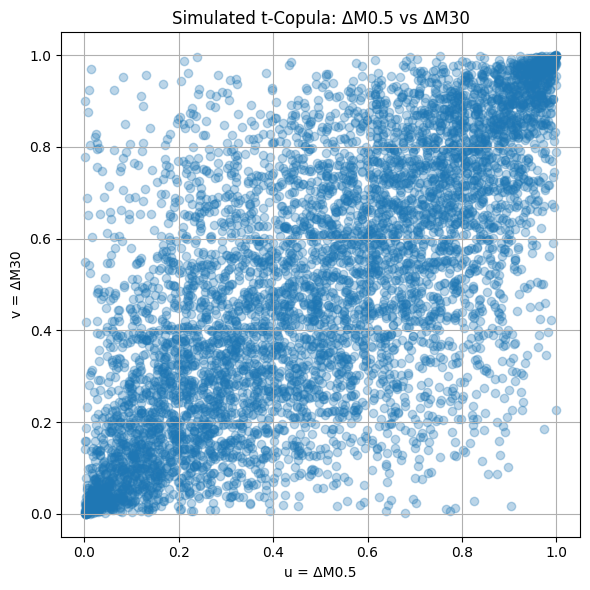

In [20]:
# --------------------- Manual t-Copula Fitting --------------------- #
import numpy as np
from scipy.stats import t
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# Step 1: Prepare pseudo-uniform margins
U = merged_df.drop(columns="Date").dropna()
U_ranks = U.rank(axis=0, method="average")
U_uniform = U_ranks.divide(len(U_ranks) + 1)  # pseudo-uniform margins

# Step 2: Inverse-t transform → t-distributed scores
df_t = 4  # degrees of freedom
Z = t.ppf(U_uniform, df=df_t)  # shape (n_obs, n_maturities)

# Step 3: Empirical correlation on t-scores
Sigma_hat = np.corrcoef(Z.T)

# Step 4: Simulate multivariate t via Cholesky
n_sim, k = Z.shape
L = cholesky(Sigma_hat, lower=True)

# draw standard normals, then impose correlation
Z_sim = np.random.standard_normal((n_sim, k)) @ L.T

# draw chi² and reshape for broadcasting
chi2_samples = np.random.chisquare(df_t, size=n_sim)  # shape (n_sim,)

# map normals→t by dividing by sqrt(χ²/df)
T_sim = Z_sim / np.sqrt( (chi2_samples[:, None] / df_t) )

# Step 5: back to [0,1] via t CDF
U_sim = t.cdf(T_sim, df=df_t)

# --------------------- Plot t-Copula Dependence --------------------- #
i, j = 0, -1  # e.g. shortest vs. longest maturity
plt.figure(figsize=(6, 6))
plt.scatter(U_sim[:, i], U_sim[:, j], alpha=0.3)
plt.title(f"Simulated t-Copula: Δ{U.columns[i]} vs Δ{U.columns[j]}")
plt.xlabel(f"u = Δ{U.columns[i]}")
plt.ylabel(f"v = Δ{U.columns[j]}")
plt.grid(True)
plt.tight_layout()
plt.show()


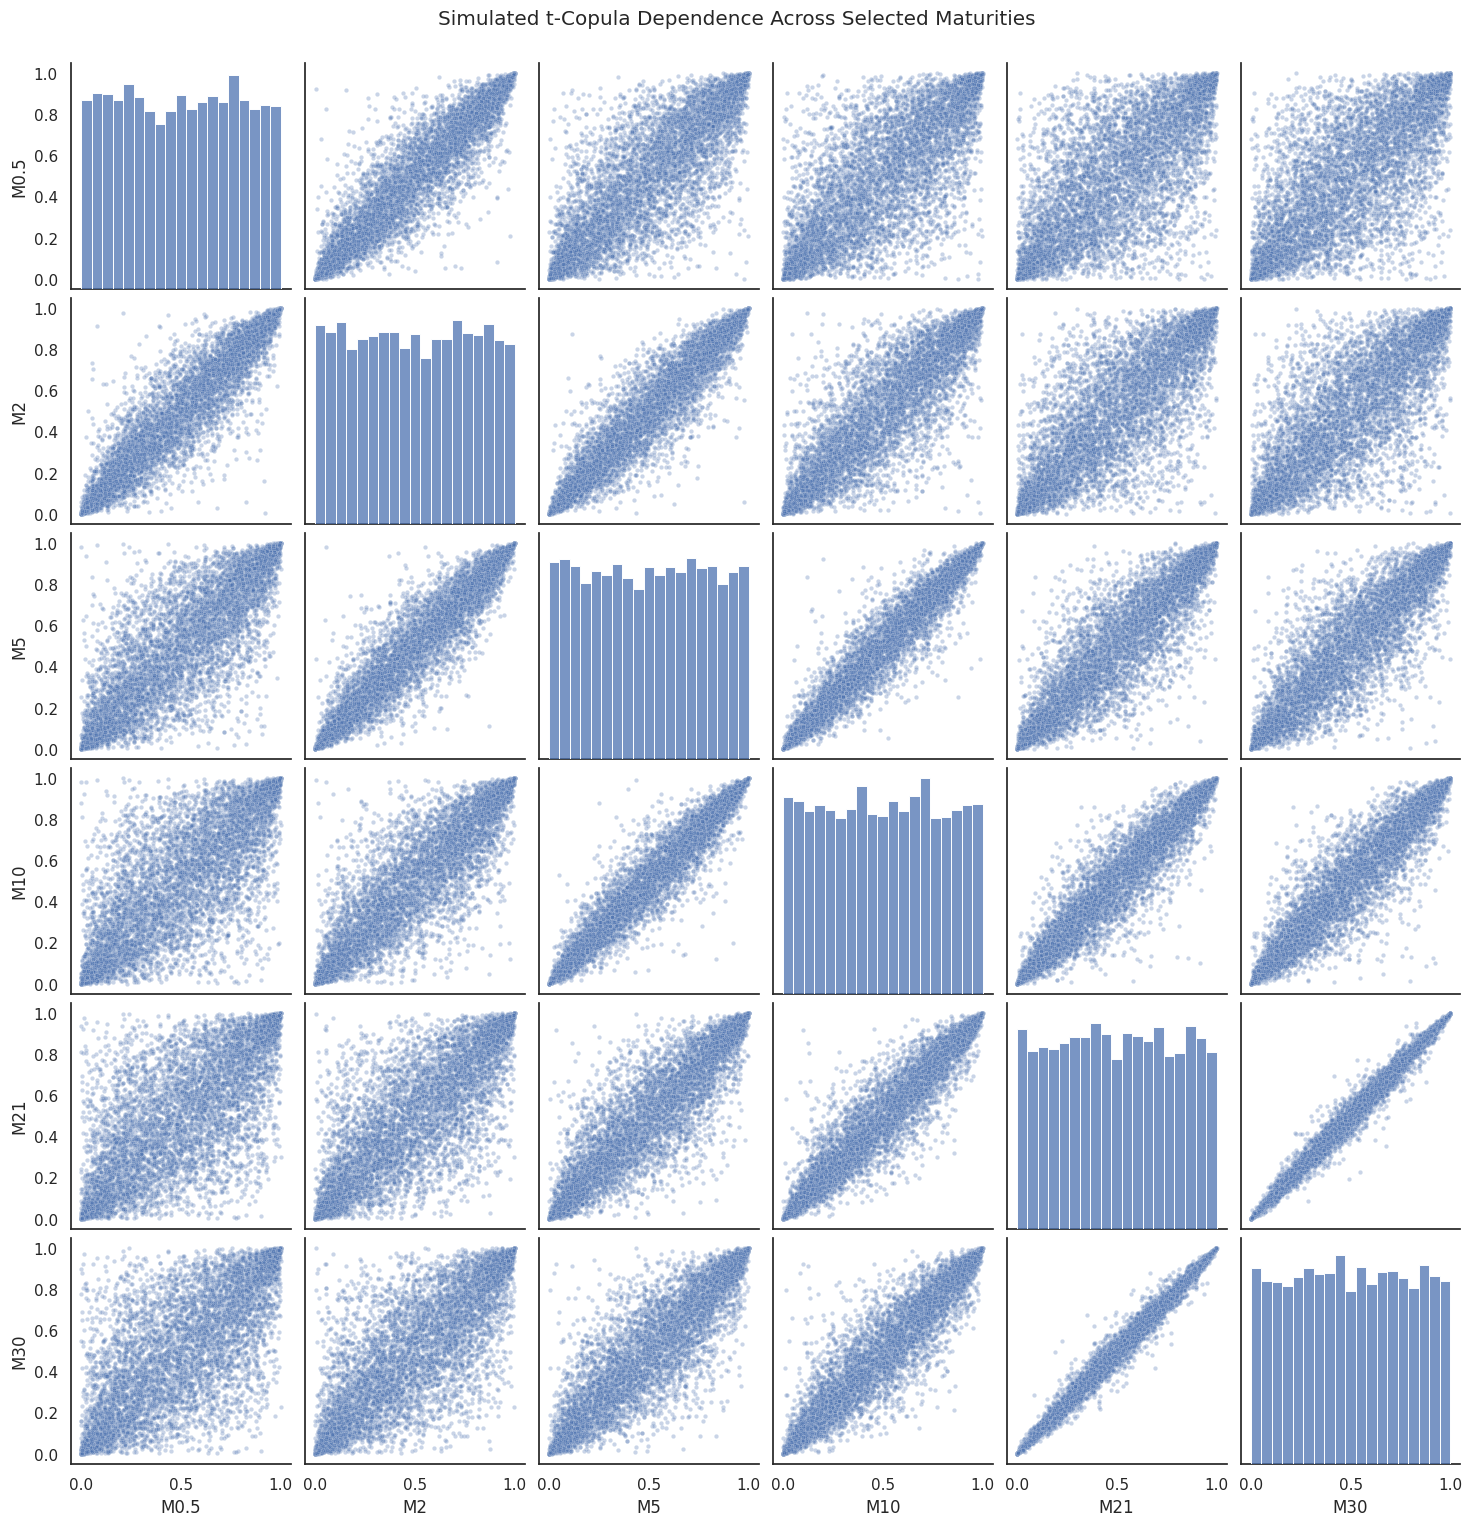

In [21]:
# --------------------- Multiple Maturities Dependencies --------------------- #
# Select a subset of maturities to avoid overcrowding
selected_cols = ["M0.5", "M2", "M5", "M10", "M21", "M30"]
selected_indices = [list(merged_df.columns).index(col) - 1 for col in selected_cols]  # exclude "Date"
selected_U_sim = pd.DataFrame(U_sim[:, selected_indices], columns=selected_cols)

# Plot pairplot
sns.set(style="white")
sns.pairplot(selected_U_sim, kind="scatter", plot_kws={'alpha': 0.3, 's': 10})
plt.suptitle("Simulated t-Copula Dependence Across Selected Maturities", y=1.02)
plt.show()

Note:

The simulated t-Copula pairwise plots show strong positive dependence across interest rate maturities, including in the tails. Adjacent and distant maturities exhibit consistent co-movement and joint extreme behavior, especially between short and long ends (e.g., M0.5 vs M30).

This confirms that interest rate changes lie in a lower-dimensional space. PCA is therefore justified as it:

Captures the core drivers (Level, Slope, Curvature),
Removes multicollinearity,
Enables tractable modeling of volatility and tail risk.
The observed structure supports PCA as a necessary transformation before GARCH-EVT modeling.


###### **2.3.2.b -  PCA Scree Plot & Proportion of Variance Explained**


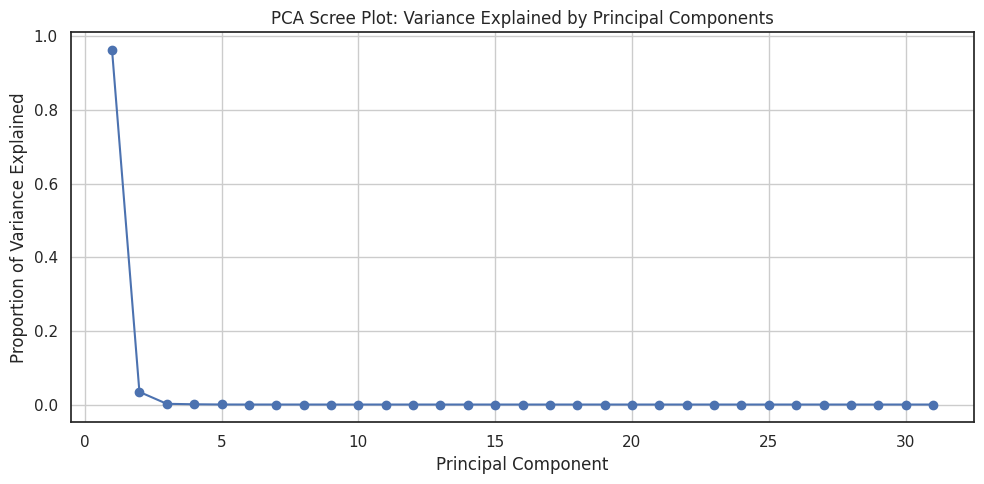

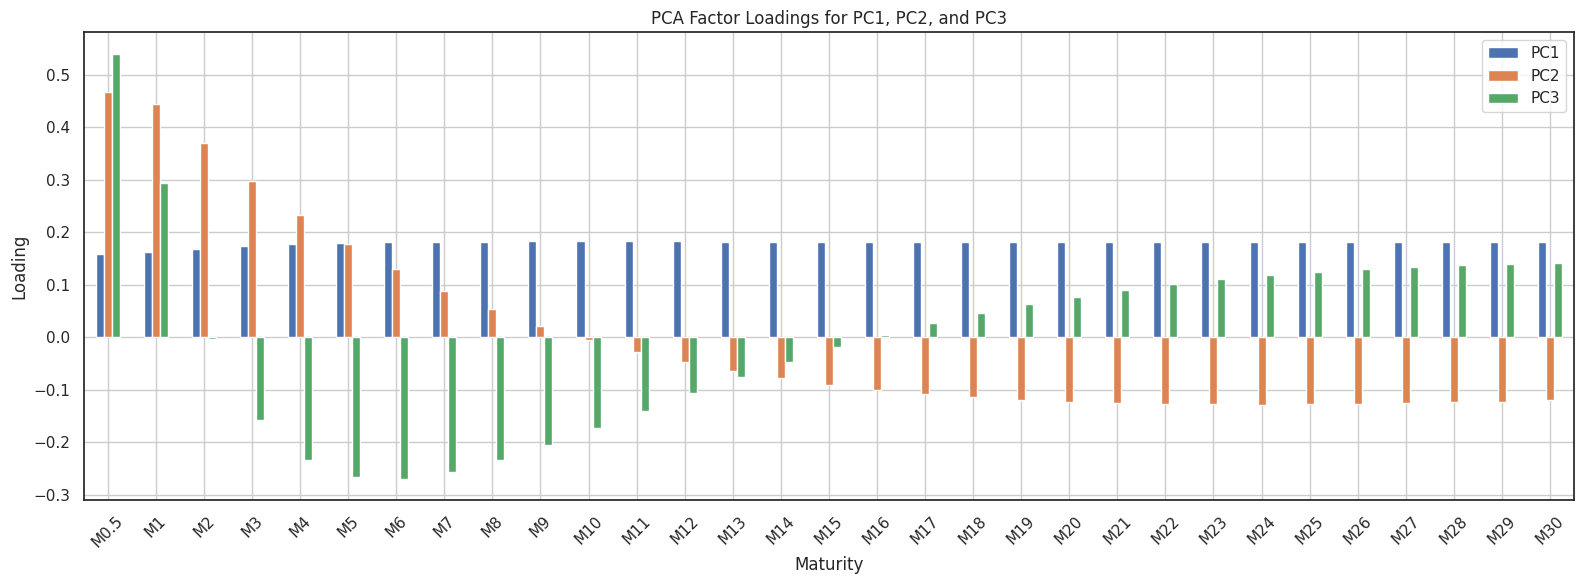


INTERPRETATION OF PRINCIPAL COMPONENTS (PCA):

- PC1 (Level): Captures parallel shifts of the yield curve. All maturities move in the same direction.
  A high PC1 score reflects an upward shift across all maturities; low PC1 reflects a downward shift.

- PC2 (Slope): Contrasts short-term and long-term interest rates. Reflects steepening or flattening of the curve.
  High PC2 means short rates are low and long rates are high (steep curve). Low PC2 means flattening or inversion.

- PC3 (Curvature): Detects changes in the mid-curve area. Short and long rates move together while medium rates move oppositely.
  This component explains curvature distortions such as humps or dips in the term structure.



In [22]:
# ------------------------ PCA on Yield Curve Data ------------------------ #
# Step 1: Create merged wide format DataFrame (Interest Rates by Maturity)
merged_df = pd.DataFrame()
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[["Date", "Interest Rate"]].rename(columns={"Interest Rate": f"M{maturity}"})
    merged_df = temp if merged_df.empty else pd.merge(merged_df, temp, on="Date", how="outer")

# Drop rows with NaN and separate feature matrix
rates_only = merged_df.drop(columns="Date").dropna()

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rates_only)

# Step 3: Apply PCA
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Scree Plot (Variance Explained by Each Principal Component)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title("PCA Scree Plot: Variance Explained by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Factor Loadings (First 3 PCs)
loading_matrix = pd.DataFrame(pca.components_[:3], columns=rates_only.columns, index=["PC1", "PC2", "PC3"]).T

# Plot Factor Loadings
loading_matrix.plot(kind='bar', figsize=(16, 6))
plt.title("PCA Factor Loadings for PC1, PC2, and PC3")
plt.xlabel("Maturity")
plt.ylabel("Loading")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------ Interpretation ------------------------ #
print("""
INTERPRETATION OF PRINCIPAL COMPONENTS (PCA):

- PC1 (Level): Captures parallel shifts of the yield curve. All maturities move in the same direction.
  A high PC1 score reflects an upward shift across all maturities; low PC1 reflects a downward shift.

- PC2 (Slope): Contrasts short-term and long-term interest rates. Reflects steepening or flattening of the curve.
  High PC2 means short rates are low and long rates are high (steep curve). Low PC2 means flattening or inversion.

- PC3 (Curvature): Detects changes in the mid-curve area. Short and long rates move together while medium rates move oppositely.
  This component explains curvature distortions such as humps or dips in the term structure.
""")



Note:

The PCA scree plot illustrates how the variance in interest rates across maturities is concentrated in a small number of components. The first principal component (PC1) explains the vast majority of the total variance—often over 90%—and reflects level shifts in the entire yield curve (i.e., parallel movements). The second component (PC2) captures slope changes, indicating steepening or flattening dynamics, while the third component (PC3) relates to curvature, identifying humps or dips in the mid-curve.

Together, the first two or three components typically account for nearly all variation, validating the use of low-dimensional term structure models in risk and scenario analysis. This dimensionality reduction simplifies modeling without significant loss of explanatory power.

<br><br>
This PCA loading plot shows that:
* PC1 (blue): All maturities load positively — the curve moves mostly through parallel shifts (level changes).
* PC2 (orange): Short and long maturities have opposite signs — it captures slope changes (steepening/flattening).
* PC3 (green): Mid-curve maturities load opposite to short and long ends — this reflects curvature effects.

In short: the term structure is driven by level, slope, and curvature, in that order.


###### **2.3.2.c -  PCA Bar Plot of Proportion of Variance Explained**


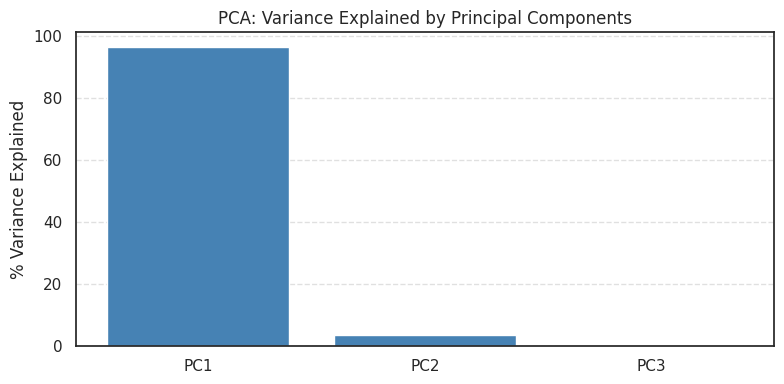


INTERPRETATION OF PRINCIPAL COMPONENTS (PCA):

- PC1 (Level): Captures parallel shifts of the yield curve. All maturities move in the same direction.
  A high PC1 score reflects an upward shift across all maturities; low PC1 reflects a downward shift.

- PC2 (Slope): Contrasts short-term and long-term interest rates. Reflects steepening or flattening of the curve.
  High PC2 means short rates are low and long rates are high (steep curve). Low PC2 means flattening or inversion.

- PC3 (Curvature): Detects changes in the mid-curve area. Short and long rates move together while medium rates move oppositely.
  This component explains curvature distortions such as humps or dips in the term structure.



In [23]:
# --------------------- 1. Prepare PCA-ready data ---------------------
# Drop rows with missing values
pca_df = merged_df.dropna().copy()

# Extract maturity columns
maturity_cols = [col for col in pca_df.columns if col != 'Date']
X = pca_df[maturity_cols].values

# --------------------- 2. Standardize the Data ---------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------- 3. Run PCA ---------------------
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

# --------------------- 4. Plot Explained Variance ---------------------
plt.figure(figsize=(8, 4))
explained = pca.explained_variance_ratio_ * 100
plt.bar(range(1, 4), explained, tick_label=["PC1", "PC2", "PC3"], color="steelblue")
plt.title("PCA: Variance Explained by Principal Components")
plt.ylabel("% Variance Explained")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --------------------- 5. Interpretation of Principal Components ---------------------
print("""
INTERPRETATION OF PRINCIPAL COMPONENTS (PCA):

- PC1 (Level): Captures parallel shifts of the yield curve. All maturities move in the same direction.
  A high PC1 score reflects an upward shift across all maturities; low PC1 reflects a downward shift.

- PC2 (Slope): Contrasts short-term and long-term interest rates. Reflects steepening or flattening of the curve.
  High PC2 means short rates are low and long rates are high (steep curve). Low PC2 means flattening or inversion.

- PC3 (Curvature): Detects changes in the mid-curve area. Short and long rates move together while medium rates move oppositely.
  This component explains curvature distortions such as humps or dips in the term structure.
""")


Note:

The PCA bar plot quantifies how much of the total variance in the term structure is captured by each principal component. As expected, the first component (PC1) dominates, explaining over 90% of the variance—this reflects parallel shifts in the yield curve (i.e., changes in overall interest rate level). The second component (PC2) contributes an additional 5–8%, representing slope changes such as steepening or flattening. The third component (PC3) accounts for a small but notable share, typically associated with curvature effects in the mid-maturities.

Together, these components confirm that a small number of factors drive most of the yield curve’s behavior, justifying the use of three-factor models in interest rate modeling and risk management.

Summary:

- PC1  explains >90% — it's the parallel shift in the curve (level).

- PC2 adds 5–8% — interpretable as steepening/flattening.

- PC3 is smaller — often curvature effects.


###### **2.3.2.d -  PCA Comonent Scores Over Time**


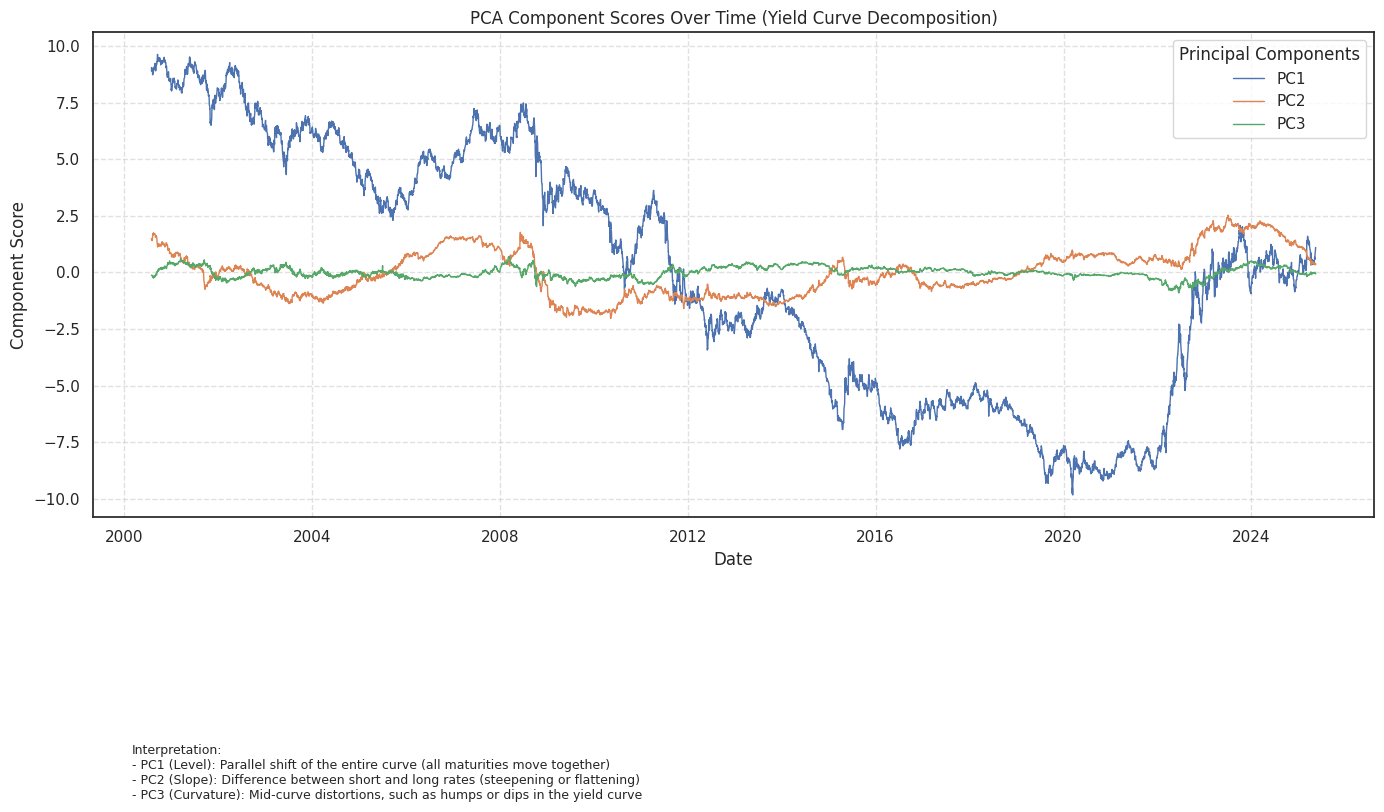

In [24]:
# --------------------- PCA Component Scores Over Time with Interpretation ---------------------
# Create DataFrame with PCA scores and dates
pca_scores_df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
pca_scores_df["Date"] = pd.to_datetime(pca_df["Date"].values)
pca_scores_df = pca_scores_df.sort_values("Date")

# Plot all three principal components
plt.figure(figsize=(14, 7))

for pc in ["PC1", "PC2", "PC3"]:
    plt.plot(pca_scores_df["Date"], pca_scores_df[pc], label=pc, linewidth=1)

plt.title("PCA Component Scores Over Time (Yield Curve Decomposition)")
plt.xlabel("Date")
plt.ylabel("Component Score")
plt.legend(title="Principal Components")
plt.grid(True, linestyle='--', alpha=0.6)

# Add interpretation text below plot
plt.figtext(0.1, -0.15,
    "Interpretation:\n"
    "- PC1 (Level): Parallel shift of the entire curve (all maturities move together)\n"
    "- PC2 (Slope): Difference between short and long rates (steepening or flattening)\n"
    "- PC3 (Curvature): Mid-curve distortions, such as humps or dips in the yield curve",
    wrap=True, horizontalalignment='left', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Make space for interpretation
plt.show()

Note:

This plot tracks the time series of the first three principal components, providing insight into how the level, slope, and curvature of the yield curve evolve over time.

* PC1 (Level) shows large swings during major crises (e.g., 2008, 2020, 2022), indicating synchronized shifts across all maturities due to central bank action or market stress.

* PC2 (Slope) captures steepening and flattening phases. Sharp movements in PC2 often coincide with monetary policy regime changes—e.g., aggressive tightening in 2022 caused a strong steepening-to-flattening shift.

* PC3 (Curvature) fluctuates less dramatically but still reflects changes in mid-curve dynamics, especially during transitional periods between policy regimes.

Overall, these component scores give a compact and interpretable decomposition of how yield curve shapes change through time, aligning with economic narratives and supporting regime-aware modeling.


###### **2.3.2.e -  PCA Loadings by Maturity**


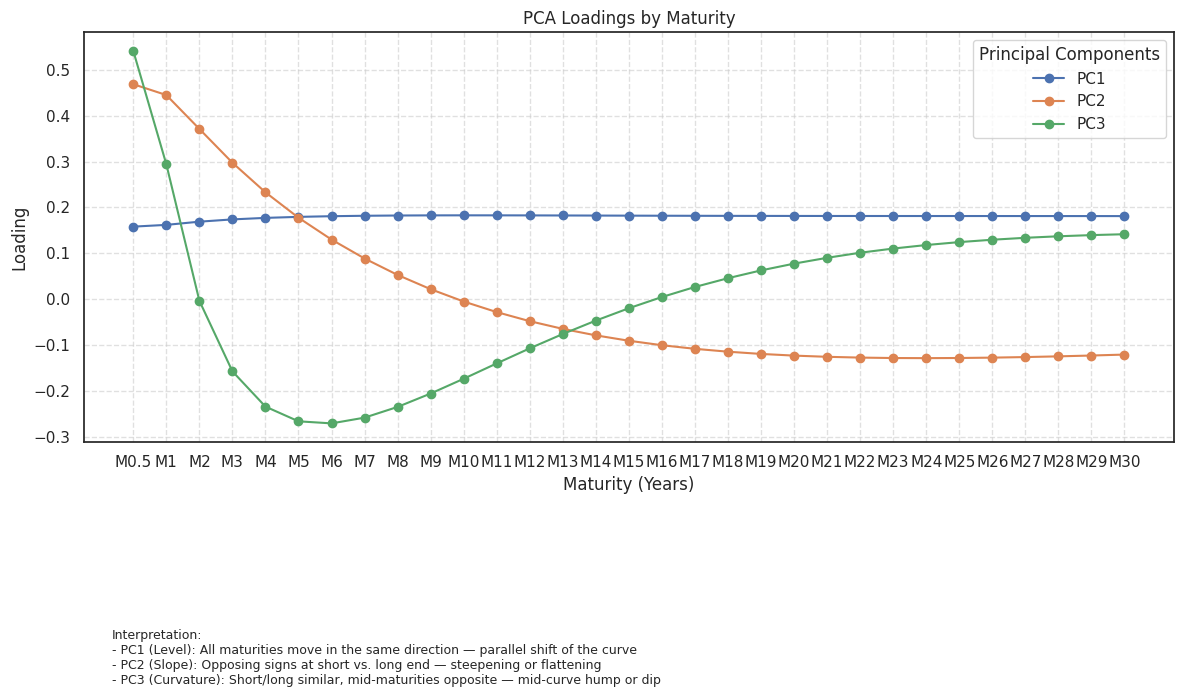

In [25]:
# --------------------- PCA Loadings by Maturity ---------------------
# Loadings: influence of each maturity on each principal component
loadings = pd.DataFrame(pca.components_.T, index=maturity_cols, columns=["PC1", "PC2", "PC3"])

# Plot loadings
plt.figure(figsize=(12, 6))
for pc in ["PC1", "PC2", "PC3"]:
    plt.plot(loadings.index, loadings[pc], marker='o', label=pc)

plt.title("PCA Loadings by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Loading")
plt.legend(title="Principal Components")
plt.grid(True, linestyle='--', alpha=0.6)

# Add interpretation note
plt.figtext(0.1, -0.15,
    "Interpretation:\n"
    "- PC1 (Level): All maturities move in the same direction — parallel shift of the curve\n"
    "- PC2 (Slope): Opposing signs at short vs. long end — steepening or flattening\n"
    "- PC3 (Curvature): Short/long similar, mid-maturities opposite — mid-curve hump or dip",
    wrap=True, horizontalalignment='left', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


Note:

This plot shows the PCA loadings for each maturity, illustrating how different parts of the yield curve contribute to each principal component.
* PC1 has loadings of the same sign across all maturities, confirming it captures parallel shifts in the yield curve—i.e., movements where all rates rise or fall together.
* PC2 exhibits a sign change between short and long maturities, indicating it reflects slope dynamics, such as steepening or flattening of the curve.
* PC3 shows multiple sign changes (typically three), highlighting its role in capturing curvature effects—i.e., humps or dips in the mid-maturities.

These loading patterns validate the standard interpretation of level, slope, and curvature components, and help link the statistical decomposition back to economic and financial meaning.

Summary:
* PC1 loadings all same sign → parallel shift
* PC2 loadings change sign → slope (short vs. long)
* PC3 has 3 sign changes → curvature (hump/dip)

## **<font color='#474747'>2.4 - Delta IRs**

In [26]:
# --------------------------IMPORTS ----------------------------------#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import norm, probplot

# Create visualizations for each requirement
import matplotlib.dates as mdates


### **<font color='#474747'>*2.4.1 - Daily Changes Analysis*</font>**

**Note: Delta IR is still in PERCENTAGE!**

In [27]:
# --------------------------DELAT I.R ----------------------------------#
# Create a new column called "Delta Interest Rate" for each dataframe in the list
# This column is the difference in interest rate from the previous row, with the first value set to 0

for df in dataframes:
    df["Delta Interest Rate"] = df["Interest Rate"].diff().fillna(0)
df

,Date,Interest Rate,Information No IR,FileReferenceName,Maturity,Delta Interest Rate
0,2000-08-02,5.49,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.00
1,2000-08-03,5.55,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.06
2,2000-08-04,5.52,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,-0.03
5,2000-08-07,5.52,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.00
6,2000-08-08,5.54,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.02
...,...,...,...,...,...,...
9046,2025-05-09,3.01,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.07
9049,2025-05-12,3.03,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.02
9050,2025-05-13,3.09,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.06
9051,2025-05-14,3.10,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.01


---
---
<br><br>
# **<font color='#000058'>Chapter 3: Portfolio Analysis</font>**

In [28]:
#------------------------------ IMPORTS -------------------------------#
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



## **<font color='#474747'>3.1 - Load All Data**

In [29]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the path to your file
file_path = '/content/drive/MyDrive/EMAS 14 Case 6/Data/DataPortfolio2024YE.xlsx'


# Load the Excel file
excel_file = pd.ExcelFile(file_path)

# See available sheets
print(excel_file.sheet_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Instruments', 'Portfolio']


In [30]:
#------------------------------ LOAD ALL SHEETS -------------------------------#
# Load sheets
instruments_df = pd.read_excel(excel_file, sheet_name="Instruments", header=2)
portfolio_df = pd.read_excel(excel_file, sheet_name="Portfolio", skiprows=4, names=["Instrument Code", "Notionals (mln)"])
portfolio_df = portfolio_df.dropna().reset_index(drop=True)

# Merge with instruments data
merged_df = pd.merge(portfolio_df, instruments_df, left_on="Instrument Code", right_on="instr_name (zero coupon bond)", how="left")

# Select only the relevant 10 columns
merged_df = merged_df[[
    "Instrument Code", "Notionals (mln)", "sector_level_1", "sector_level_2",
    "issuer_short", "rating", "seniority", "maturity", "value"
]]

# Convert to numeric and compute total market value
merged_df["Notionals (mln)"] = pd.to_numeric(merged_df["Notionals (mln)"], errors="coerce")
merged_df["maturity"] = pd.to_numeric(merged_df["maturity"], errors="coerce")
merged_df["value"] = pd.to_numeric(merged_df["value"], errors="coerce")
merged_df["Market Value (Total)"] = merged_df["Notionals (mln)"] * merged_df["value"]

# Remove duplicates for non-bond assets
merged_df = merged_df[~merged_df["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])]

# Append MSCI, Property, Cash with only the 10 columns
non_bond_assets = [
    {"Instrument Code": "MSCI World", "Notionals (mln)": 75.0, "sector_level_1": "MSCI World",
     "sector_level_2": None, "issuer_short": None, "rating": None, "seniority": None,
     "maturity": None, "value": 1.0, "Market Value (Total)": 75.0},

    {"Instrument Code": "Direct Property", "Notionals (mln)": 50.0, "sector_level_1": "Direct Property",
     "sector_level_2": None, "issuer_short": None, "rating": None, "seniority": None,
     "maturity": None, "value": 1.0, "Market Value (Total)": 50.0},

    {"Instrument Code": "Cash", "Notionals (mln)": 10.0, "sector_level_1": "Cash",
     "sector_level_2": None, "issuer_short": None, "rating": None, "seniority": None,
     "maturity": None, "value": 1.0, "Market Value (Total)": 10.0}
]
non_bond_df = pd.DataFrame(non_bond_assets)

# Final portfolio with exactly 10 columns
extended_portfolio = pd.concat([merged_df, non_bond_df], ignore_index=True)



####################### FOR MODELING ################
# Build cashflow dataframe from extended portfolio
cashflows_df = extended_portfolio[["Instrument Code", "maturity", "Notionals (mln)"]].dropna()
cashflows_df = cashflows_df.rename(columns={
    "Instrument Code": "bond_name",
    "Notionals (mln)": "cashflow"
})


# Manually define the EIOPA RFR and VA data since automatic parsing failed
eiopa_manual = {
    "Maturity": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 25, 30, 40, 50, 60],
    "EIOPA_RFR (%)": [2.236, 2.093, 2.093, 2.120, 2.142, 2.170, 2.198, 2.222, 2.243, 2.267,
                      2.286, 2.304, 2.322, 2.330, 2.332, 2.331, 2.310, 2.283, 2.268, 2.259,
                      2.356, 2.595, 2.836, 2.795, 2.795],
    "VA (bps)": [23.0]*20 + [21.4, 19.1, 15.0, 12.1, 10.1]
}

# Convert the manually defined EIOPA dictionary into a DataFrame
eiopa_df = pd.DataFrame(eiopa_manual)

# Convert interest rates from percentage to decimal format for calculations
# e.g., 2.236% becomes 0.02236
eiopa_df["EIOPA_RFR"] = eiopa_df["EIOPA_RFR (%)"] / 100

# Convert volatility adjustment (VA) from basis points to decimal
# e.g., 23 bps becomes 0.0023
eiopa_df["VA"] = eiopa_df["VA (bps)"] / 10000

# Create a clean base curve column using the converted RFR
eiopa_df["Base Curve"] = eiopa_df["EIOPA_RFR"]

# Add the VA to the base RFR to get the final curve used in liability discounting
# This reflects regulatory adjustments in line with EIOPA's standard formula guidance
eiopa_df["Curve with VA"] = eiopa_df["EIOPA_RFR"] + eiopa_df["VA"] #####################CHECK####################

# Display the first rows of both key tables: cashflows and EIOPA yield curves
cashflows_df.head(), eiopa_df.head()


/tmp/ipython-input-30-3525640780.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extended_portfolio = pd.concat([merged_df, non_bond_df], ignore_index=True)


(            bond_name  maturity   cashflow
 0  GOV-FI-AT-NA-NA-05       5.0   8.492308
 1  GOV-FI-AT-NA-NA-10      10.0   7.912905
 2  GOV-FI-AT-NA-NA-20      20.0   4.770736
 3  GOV-FI-BE-NA-NA-05       5.0  19.862943
 4  GOV-FI-BE-NA-NA-10      10.0   8.143508,
    Maturity  EIOPA_RFR (%)  VA (bps)  EIOPA_RFR      VA  Base Curve  \
 0         1          2.236      23.0    0.02236  0.0023     0.02236   
 1         2          2.093      23.0    0.02093  0.0023     0.02093   
 2         3          2.093      23.0    0.02093  0.0023     0.02093   
 3         4          2.120      23.0    0.02120  0.0023     0.02120   
 4         5          2.142      23.0    0.02142  0.0023     0.02142   
 
    Curve with VA  
 0        0.02466  
 1        0.02323  
 2        0.02323  
 3        0.02350  
 4        0.02372  )



## **<font color='#474747'>3.2 - Sector Level Analysis**

<Figure size 1500x900 with 0 Axes>

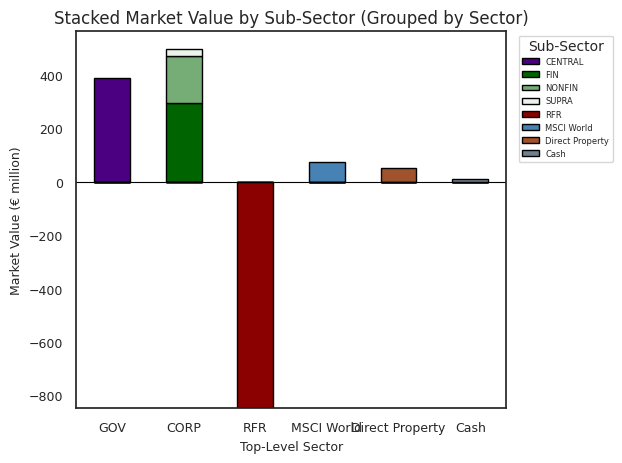

In [31]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Step 1: Filter and prepare the data
filtered_df = extended_portfolio[
    extended_portfolio["sector_level_1"].isin(["GOV", "CORP", "RFR", "MSCI World", "Direct Property", "Cash"])
].copy()

# Fill missing sector_level_2 with sector_level_1 as fallback
filtered_df["sector_level_2"] = filtered_df["sector_level_2"].fillna(filtered_df["sector_level_1"])

# Step 2: Aggregate Market Value
grouped = filtered_df.groupby(["sector_level_1", "sector_level_2"])["Market Value (Total)"].sum().reset_index()

# Pivot to wide format for plotting
pivot = grouped.pivot(index="sector_level_1", columns="sector_level_2", values="Market Value (Total)").fillna(0)

# Step 3: Enforce desired sector order
sector_order = ["GOV", "CORP", "RFR", "MSCI World", "Direct Property", "Cash"]
pivot = pivot.reindex(sector_order)

# Step 4: Base colors for each main sector
base_colors = {
    "GOV": "#4B0082",           # Indigo
    "CORP": "#006400",          # Dark Green
    "RFR": "#8B0000",           # Dark Red
    "MSCI World": "#4682B4",    # Steel Blue
    "Direct Property": "#A0522D",  # Sienna
    "Cash": "#708090"           # Slate Gray
}

# Step 5: Generate shade colors for each sub-sector
def generate_shades(base_color, n_shades):
    return sns.light_palette(base_color, n_colors=n_shades, reverse=True).as_hex()

# Map each sub-sector to a color
color_mapping = {}
for sector in pivot.index:
    subsectors = [
        col for col in pivot.columns
        if grouped[grouped["sector_level_2"] == col]["sector_level_1"].iloc[0] == sector
    ]
    shades = generate_shades(base_colors[sector], len(subsectors))
    for subsec, shade in zip(subsectors, shades):
        color_mapping[subsec] = shade

# Step 6: Sort legend by sector group order
sorted_columns = []
for sector in sector_order:
    sector_cols = [col for col in pivot.columns if grouped[grouped["sector_level_2"] == col]["sector_level_1"].iloc[0] == sector]
    sorted_columns.extend(sector_cols)

# Step 7: Plot
plt.figure(figsize=(15, 9))
pivot = pivot[sorted_columns]  # reorder columns to match legend/grouping
pivot.plot(
    kind="bar",
    stacked=True,
    color=[color_mapping.get(col, "#cccccc") for col in sorted_columns],
    edgecolor="black"
)

plt.title("Stacked Market Value by Sub-Sector (Grouped by Sector)", fontsize=12)
plt.ylabel("Market Value (€ million)", fontsize=9)
plt.xlabel("Top-Level Sector", fontsize=9)
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.legend(
    title="Sub-Sector",
    title_fontsize=10,
    fontsize=6,
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.3 - Sub-sector Level Analysis**

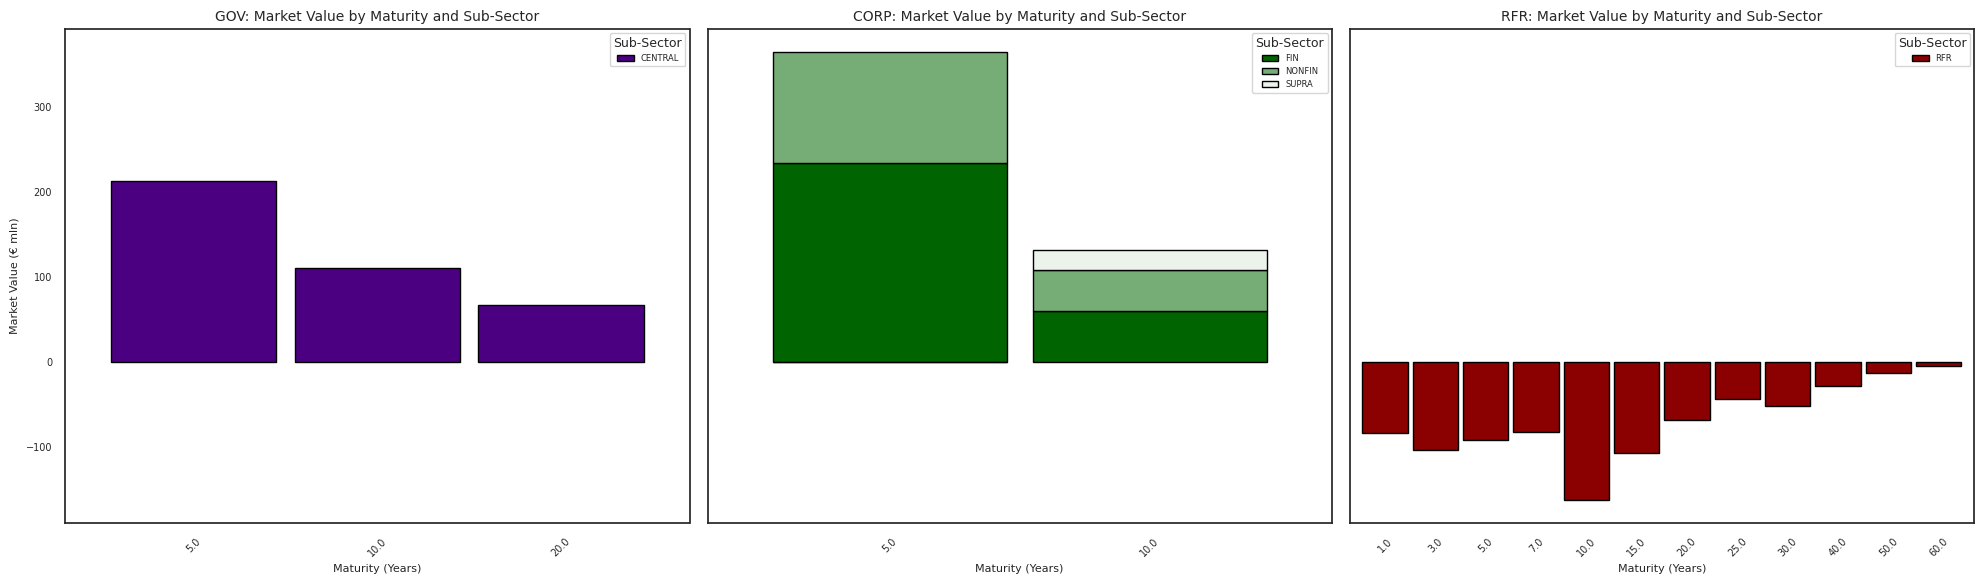

In [32]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Filter only relevant sectors
plot_sectors = ["GOV", "CORP", "RFR"]
filtered_df = extended_portfolio[extended_portfolio["sector_level_1"].isin(plot_sectors)].copy()

# Fill missing sub-sector labels with sector_level_1
filtered_df["sector_level_2"] = filtered_df["sector_level_2"].fillna(filtered_df["sector_level_1"])

# Define base colors for each sector
base_colors = {
    "GOV": "#4B0082",    # Indigo
    "CORP": "#006400",   # Dark Green
    "RFR": "#8B0000"     # Dark Red
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Loop through each sector and plot
for ax, sector in zip(axes, plot_sectors):
    df_sector = filtered_df[filtered_df["sector_level_1"] == sector].copy()
    df_sector["maturity"] = pd.to_numeric(df_sector["maturity"], errors='coerce')
    df_sector = df_sector.dropna(subset=["maturity"])
    grouped = df_sector.groupby(["maturity", "sector_level_2"])["Market Value (Total)"].sum().unstack(fill_value=0)

    # Generate color shades
    shades = sns.light_palette(base_colors[sector], n_colors=len(grouped.columns), reverse=True).as_hex()

    # Plot
    grouped.plot(kind='bar', stacked=True, ax=ax, color=shades, edgecolor="black", width=0.9, legend=True)
    ax.set_title(f"{sector}: Market Value by Maturity and Sub-Sector", fontsize=10)
    ax.set_xlabel("Maturity (Years)", fontsize=8)
    ax.set_ylabel("Market Value (€ mln)", fontsize=8)
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.legend(title="Sub-Sector", title_fontsize=9, fontsize=6)

plt.tight_layout()
plt.show()




## **<font color='#474747'>3.4 - Issuer Level Analysis**

<Figure size 1400x800 with 0 Axes>

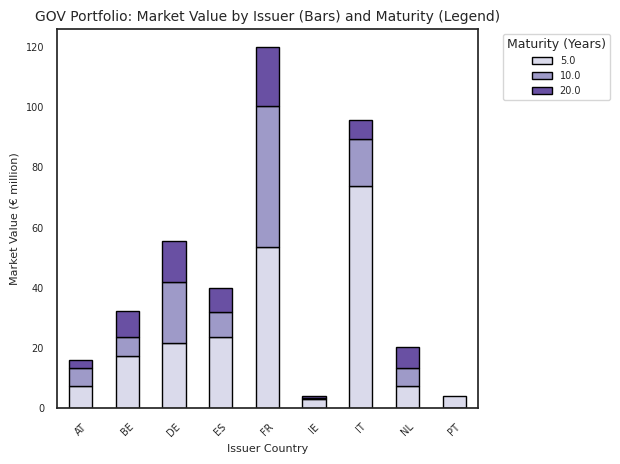

In [33]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Filter for GOV only
gov_df = extended_portfolio[extended_portfolio["sector_level_1"] == "GOV"].copy()

# Drop rows with missing maturity or issuer
gov_df = gov_df.dropna(subset=["maturity", "issuer_short"])

# Convert maturity to string for use as legend labels
gov_df["maturity"] = gov_df["maturity"].astype(str)

# Pivot the table: index = issuer_short, columns = maturity, values = Market Value (Total)
gov_pivot = gov_df.pivot_table(
    index="issuer_short",
    columns="maturity",
    values="Market Value (Total)",
    aggfunc="sum",
    fill_value=0
)

# Sort columns numerically for correct order
gov_pivot = gov_pivot[sorted(gov_pivot.columns, key=lambda x: float(x))]

# Plot
plt.figure(figsize=(14, 8))
gov_pivot.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette("Purples", n_colors=len(gov_pivot.columns)),
    edgecolor="black"
)

plt.title("GOV Portfolio: Market Value by Issuer (Bars) and Maturity (Legend)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=8)
plt.xlabel("Issuer Country", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Maturity (Years)", title_fontsize=9, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

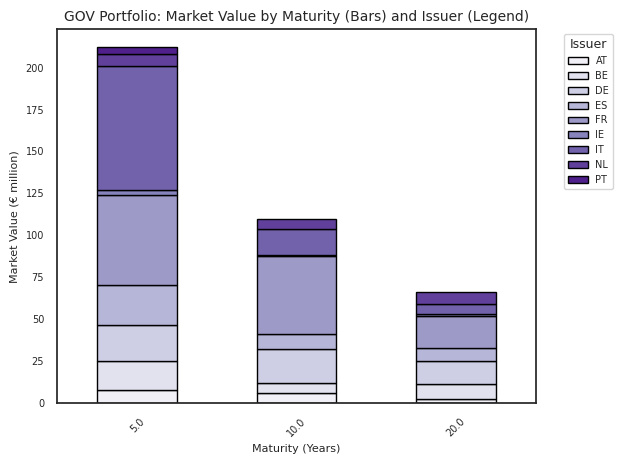

In [34]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Filter for GOV only
gov_df = extended_portfolio[extended_portfolio["sector_level_1"] == "GOV"].copy()

# Drop rows with missing maturity or issuer
gov_df = gov_df.dropna(subset=["maturity", "issuer_short"])

# Convert issuer_short to string for use as legend labels
gov_df["issuer_short"] = gov_df["issuer_short"].astype(str)

# Pivot the table: index = maturity, columns = issuer_short, values = Market Value (Total)
gov_pivot = gov_df.pivot_table(
    index="maturity",
    columns="issuer_short",
    values="Market Value (Total)",
    aggfunc="sum",
    fill_value=0
)

# Sort index numerically for correct order
gov_pivot = gov_pivot.sort_index()

# Plot
plt.figure(figsize=(14, 8))
gov_pivot.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette("Purples", n_colors=len(gov_pivot.columns)),
    edgecolor="black"
)

plt.title("GOV Portfolio: Market Value by Maturity (Bars) and Issuer (Legend)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=8)
plt.xlabel("Maturity (Years)", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Issuer", title_fontsize=9, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.5 - CORP Sector Analysis**

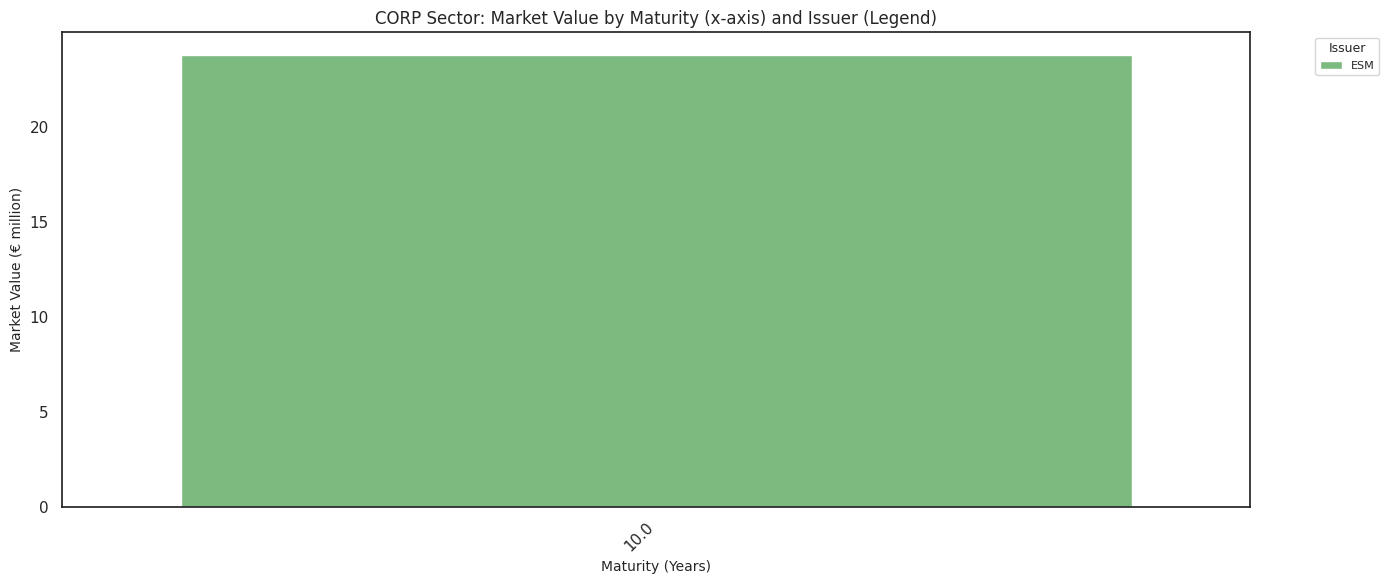

In [35]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Filter for CORP only with maturity and issuer_short
corp_df = extended_portfolio[
    (extended_portfolio["sector_level_1"] == "CORP") &
    (extended_portfolio["issuer_short"].notna()) &
    (extended_portfolio["maturity"].notna())
].copy()

# Convert maturity to string for clearer x-axis labels
corp_df["maturity"] = corp_df["maturity"].astype(str)

# Sort issuers for consistent legend order
unique_issuers = sorted(corp_df["issuer_short"].dropna().unique())
green_palette = sns.color_palette("Greens", n_colors=len(unique_issuers))
issuer_color_map = dict(zip(unique_issuers, green_palette))

# Plotting
plt.figure(figsize=(14, 6))
sns.barplot(
    data=corp_df,
    x="maturity",
    y="Market Value (Total)",
    hue="issuer_short",
    palette=issuer_color_map
)

plt.title("CORP Sector: Market Value by Maturity (x-axis) and Issuer (Legend)", fontsize=12)
plt.xlabel("Maturity (Years)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Issuer", title_fontsize=9, fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.6 - Rating Level Analysis - CORP Portfolio**

<Figure size 1400x800 with 0 Axes>

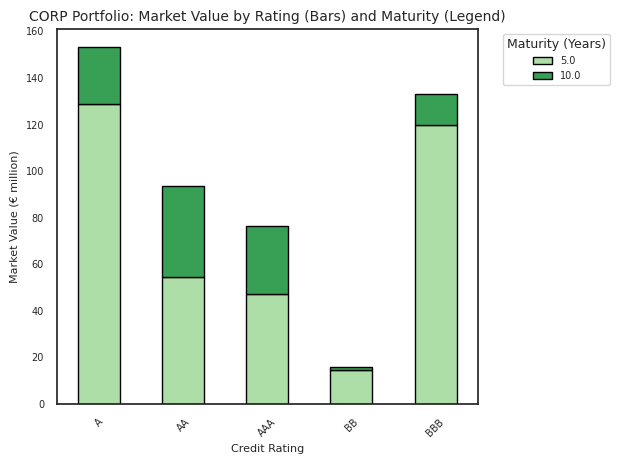

In [36]:
#------------------------------ CORP PORTOFLIO -------------------------------#
# Filter for CORP only
corp_df = extended_portfolio[
    (extended_portfolio["sector_level_1"] == "CORP") &
    (extended_portfolio["rating"].notna()) &
    (extended_portfolio["maturity"].notna())
].copy()

# Convert maturity to string for use as legend labels
corp_df["maturity"] = corp_df["maturity"].astype(str)

# Pivot the table: index = rating, columns = maturity, values = Market Value (Total)
corp_pivot = corp_df.pivot_table(
    index="rating",
    columns="maturity",
    values="Market Value (Total)",
    aggfunc="sum",
    fill_value=0
)

# Sort columns numerically for correct order
corp_pivot = corp_pivot[sorted(corp_pivot.columns, key=lambda x: float(x))]

# Plot
plt.figure(figsize=(14, 8))
corp_pivot.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette("Greens", n_colors=len(corp_pivot.columns)),
    edgecolor="black"
)

plt.title("CORP Portfolio: Market Value by Rating (Bars) and Maturity (Legend)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=8)
plt.xlabel("Credit Rating", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Maturity (Years)", title_fontsize=9, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.7 - CORP Portfolio: Market Value by MaturityData**

<Figure size 1400x800 with 0 Axes>

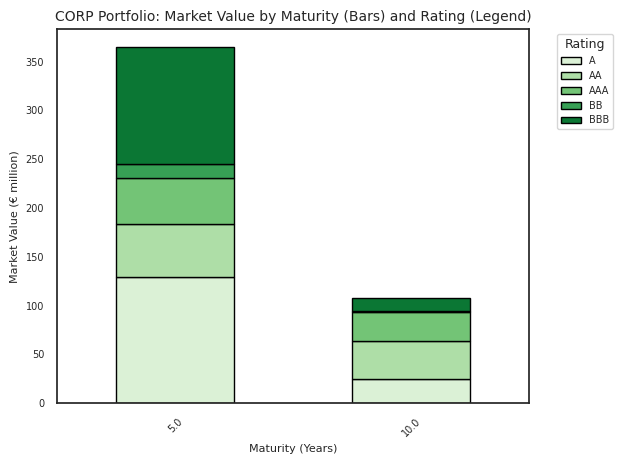

In [37]:
#------------------------------ CORP Portfolio: Market Value by Maturity -------------------------------#
# Filter for CORP with non-null ratings and maturities
corp_df = extended_portfolio[
    (extended_portfolio["sector_level_1"] == "CORP") &
    (extended_portfolio["rating"].notna()) &
    (extended_portfolio["maturity"].notna())
].copy()

# Convert rating to string for legend labels and maturity to string for x-axis
corp_df["rating"] = corp_df["rating"].astype(str)
corp_df["maturity"] = corp_df["maturity"].astype(str)

# Pivot the table: index = maturity, columns = rating, values = Market Value (Total)
corp_pivot = corp_df.pivot_table(
    index="maturity",
    columns="rating",
    values="Market Value (Total)",
    aggfunc="sum",
    fill_value=0
)

# Sort index and columns numerically/alphabetically
corp_pivot = corp_pivot.sort_index(key=lambda x: x.astype(float))
corp_pivot = corp_pivot[sorted(corp_pivot.columns)]

# Plot
plt.figure(figsize=(14, 8))
corp_pivot.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette("Greens", n_colors=len(corp_pivot.columns)),
    edgecolor="black"
)

plt.title("CORP Portfolio: Market Value by Maturity (Bars) and Rating (Legend)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=8)
plt.xlabel("Maturity (Years)", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Rating", title_fontsize=9, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.8 - Liabilities / Assets Base PV Ratio**

In [38]:
# #------------------------------ Liabilities / Assets Base PV Ratio ---------------------------#

# liabilities_assets_ratio = abs(base_pv_liabilities) / base_pv_assets

# print(f"\n--- Base PV Liabilities / Assets Ratio ---")
# print(f"Liabilities / Assets Base PV Ratio: {liabilities_assets_ratio:.2f}")


Note:

The results show that liability risk dominates the interest rate risk SCR, as expected for this portfolio composition. The internal model SCR is well-aligned with the Standard Formula result (~29.9 kEUR), confirming that the model adequately captures the portfolio’s interest rate risk profile. The close matching of asset and liability base PV further supports the quality of the model.

---
---
<br><br>
# **<font color='#000058'>Chapter 4: Modelling</font>**


In [39]:
# Install the arch package
!pip install arch --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 43.6 MB/s eta 0:00:00


In [40]:
from arch import arch_model
from scipy.interpolate import interp1d



In [41]:
final_df

,Date,M0.5,M1,M2,M3,M4,M5,M6,M7,M8,...,M21,M22,M23,M24,M25,M26,M27,M28,M29,M30
0,1997-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1997-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1997-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1997-08-07,3.23,3.45,3.90,4.31,4.67,4.98,5.24,5.47,5.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7069,2025-05-09,1.89,1.80,1.78,1.86,1.98,2.11,2.24,2.35,2.46,...,3.07,3.08,3.08,3.08,3.07,3.06,3.05,3.04,3.03,3.01
7070,2025-05-12,1.93,1.88,1.88,1.96,2.07,2.19,2.30,2.42,2.52,...,3.10,3.10,3.10,3.10,3.09,3.08,3.07,3.06,3.05,3.03
7071,2025-05-13,1.95,1.90,1.91,1.99,2.11,2.23,2.35,2.46,2.56,...,3.16,3.16,3.16,3.16,3.15,3.15,3.14,3.12,3.11,3.09
7072,2025-05-14,1.94,1.89,1.91,1.99,2.11,2.23,2.35,2.46,2.57,...,3.16,3.16,3.17,3.16,3.16,3.15,3.14,3.13,3.12,3.10


In [42]:
# ------------------ 1. Δ-Rates in bps (from final_df) ------------------ #
import numpy as np
import pandas as pd

# 1.1 Copy final_df so we don’t overwrite it
df = final_df.copy()

# 1.2 Ensure Date is datetime (if not already)
df["Date"] = pd.to_datetime(df["Date"])

# 1.3 Drop any duplicate Date indices and sort
df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

# 1.4 Identify and clean rate columns
rate_cols = [c for c in df.columns if c.startswith("M")]
#    Remove the "M" prefix so columns become e.g. "0.5","1",..."30"
df.rename(columns={c: c.lstrip("M") for c in rate_cols}, inplace=True)
clean_cols = [c.lstrip("M") for c in rate_cols]  # e.g. ["0.5","1",...,"30"]

# 1.5 Convert from percent → decimals (e.g. 2.50 → 0.025)
df[clean_cols] = df[clean_cols] / 100

# 1.6 Compute day-to-day changes in decimals, then convert to basis‐points
delta_r     = df[clean_cols].diff().dropna(how="any")
delta_r_bps = delta_r * 10_000

# Quick check: show first 5 rows (bps)
print(delta_r_bps.head())


     0.5    1    2    3    4    5    6    7    8    9  ...   21   22   23  \
765  1.0  2.0  3.0  3.0  4.0  4.0  4.0  4.0  5.0  4.0  ...  6.0  6.0  6.0   
766 -1.0 -1.0 -1.0 -1.0 -2.0 -1.0 -2.0 -1.0 -2.0 -2.0  ... -3.0 -3.0 -3.0   
767 -4.0 -5.0 -5.0 -5.0 -5.0 -4.0 -2.0 -3.0 -2.0 -1.0  ...  0.0  0.0  0.0   
768  1.0  1.0  1.0  1.0  3.0  2.0  2.0  3.0  3.0  3.0  ...  3.0  3.0  2.0   
769  2.0  1.0  3.0  4.0  3.0  3.0  1.0  0.0 -1.0 -2.0  ... -2.0 -2.0 -1.0   

      24   25   26   27   28   29   30  
765  7.0  6.0  6.0  6.0  6.0  7.0  6.0  
766 -4.0 -3.0 -3.0 -3.0 -3.0 -4.0 -3.0  
767  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
768  3.0  3.0  2.0  3.0  2.0  3.0  2.0  
769 -1.0 -1.0 -1.0 -1.0  0.0 -1.0  0.0  

[5 rows x 31 columns]


## **<font color='#474747'>4.1 - Adjustable Model Tuning**

In [43]:
# =============================================================================
# MODEL TUNING PARAMETERS — YOU CAN ADJUST THESE
# =============================================================================

# --- PCA truncation window (start date) ---
TRUNC_START = "2015-01-01"

# --- PCs to use: (1 = active, 0 = frozen)
USE_PCS = (1, 1, 1)   # e.g. (1,0,0) = PC1 only; (1,1,1) = all active

# --- Shrink factors per PC (optional — you can tune manually or calculate dynamically)
# Leave as None to calculate automatically based on 99.5% quantiles
SHRINK_PC1 = 0.85
SHRINK_PC2 = 0.25
SHRINK_PC3 = 0.25

# --- Number of simulation paths
N_PATHS = 10_000

# --- LLP / UFR / Alpha ********************************* double check % and bps coversion
LLP   = 20.0
UFR   = 0.0375
ALPHA = 0.05


## **<font color='#474747'>4.2 - Full Model Definition**

##### **4.2.1 -  Model Defined (Mean PC1 Used)**


In [44]:
# # =============================================================================
# # 2. Compute Δ-rates in bps — with truncation
# # =============================================================================
# # strip M prefix for easier handling
# rate_cols = [c for c in final_df.columns if c.startswith("M")]
# num_cols  = [c.lstrip("M") for c in rate_cols]

# # Copy and rename columns
# df2 = final_df.copy()
# df2.rename(columns={c: c.lstrip("M") for c in rate_cols}, inplace=True)

# # Truncate period
# df2 = df2[df2["Date"] >= pd.to_datetime(TRUNC_START)]

# # Convert to decimal
# df2[num_cols] = df2[num_cols] / 100

# # Drop rows with NaN
# df2 = df2.dropna(subset=num_cols).reset_index(drop=True)

# # Compute Δ-rates
# delta_r     = df2[num_cols].diff().dropna()
# delta_r_bps = delta_r * 10_000

# print(f"\nΔ-rates shape: {delta_r_bps.shape} (should be ~1000–2000 rows)")
# display(delta_r_bps.head())

# # =============================================================================
# # 3. PCA on Δ-rates
# # =============================================================================
# scaler = StandardScaler()
# X      = scaler.fit_transform(delta_r_bps)

# pca    = PCA(n_components=3)
# Z      = pca.fit_transform(X)
# Z_df   = pd.DataFrame(Z, columns=["PC1","PC2","PC3"], index=delta_r_bps.index)

# expl_var_pct = np.round(pca.explained_variance_ratio_.cumsum()[-1]*100,2)
# print("Explained var by PC1–3:", expl_var_pct, "%")

# loadings      = pd.DataFrame(pca.components_.T, index=num_cols, columns=["PC1","PC2","PC3"])
# pca_loadings_3 = pca.components_.T[:, :3]

# # PCA comparison
# if expl_var_pct > 95:
#     print(f"OK — PCA explained variance is sufficient ({expl_var_pct}%)")
# else:
#     print(f"WARNING — PCA explained variance too low ({expl_var_pct}%)")

# # =============================================================================
# # 4. Fit GARCH(1,1)-t on each PC — original mean-based method (for testing)
# # =============================================================================
# pca_garch_models = {}
# pca_sigma_annual = {}

# for pc in ["PC1", "PC2", "PC3"]:
#     y = Z_df[pc]
#     model = arch_model(y, vol="Garch", p=1, q=1, dist="t")
#     res = model.fit(disp="off")
#     pca_garch_models[pc] = res

#     # Mean conditional volatility (as in original method)
#     daily_sigma = res.conditional_volatility.mean() * Z_df[pc].std()
#     pca_sigma_annual[pc] = np.sqrt(252) * daily_sigma

# # Display all PCs
# print("\nAnnual σ per PC (original mean-based):", pca_sigma_annual)

# # Compare PC1
# pc1_sigma = pca_sigma_annual["PC1"]
# if 150 < pc1_sigma < 250:
#     print(f"OK — PC1 σ = {pc1_sigma:.1f} bps — good range")
# else:
#     print(f"WARNING — PC1 σ = {pc1_sigma:.1f} bps — unusual, check TRUNC_START or volatility regime")



# # =============================================================================
# # 5. Simulate 1-yr shocks (with shrink) & rebuild curves
# # =============================================================================
# pc_shocks = []
# for i, pc in enumerate(["PC1","PC2","PC3"]):
#     if USE_PCS[i]:
#         pc_shocks.append(np.random.normal(0, pca_sigma_annual[pc], size=N_PATHS))
#     else:
#         pc_shocks.append(np.zeros(N_PATHS))
# sim_pc = np.vstack(pc_shocks)

# # Auto shrink factors
# hist_q = Z_df.quantile(0.995)
# sim_q  = pd.DataFrame(sim_pc.T, columns=["PC1","PC2","PC3"]).quantile(0.995)
# shrinks = (hist_q / sim_q).round(4)

# # Manual override if given
# shrinks_manual = [SHRINK_PC1, SHRINK_PC2, SHRINK_PC3] ###### SHRINKING HERE
# for i, pc in enumerate(["PC1","PC2","PC3"]):
#     if shrinks_manual[i] is not None:
#         shrinks[pc] = shrinks_manual[i]

# print("\nShrink factors applied:", shrinks)



# # Shrink comparison
# if 0.7 < shrinks["PC1"] < 1.0:
#     print(f"OK — PC1 shrink = {shrinks['PC1']:.3f}")
# else:
#     print(f"WARNING — PC1 shrink = {shrinks['PC1']:.3f} — too small or large, check TRUNC_START")

# # Continue with rest of Section 5 as you have
# sim_pc_shrunk = sim_pc * shrinks.values[:, None]

# sim_std_bps    = pca_loadings_3 @ sim_pc_shrunk
# sim_bps_shocks = sim_std_bps * scaler.scale_[:,None]
# sim_dec_shocks = sim_bps_shocks / 10_000

# last_obs = np.array([df["Interest Rate"].iloc[-1]/100 for df in dataframes])
# paths_pc = (sim_dec_shocks + last_obs[:,None]).T
# simulated_yield_curve_df = pd.DataFrame(paths_pc, columns=[f"M{m:g}" for m in delta_r_bps.columns.astype(float)])


# # =============================================================================
# # 6. Smith–Wilson extrapolation + VA up to 60y
# # =============================================================================
# def smith_wilson(mats, dfs, proj_mats, ufr=UFR, alpha=ALPHA):
#     def H(t): return np.exp(-ufr*t)
#     def W(t,u):
#         return np.exp(-ufr*(t+u)) * (
#             alpha*min(t,u)
#             - np.exp(-alpha*max(t,u))*np.sinh(alpha*min(t,u))
#         )
#     Wmat = np.array([[W(mi,mj) for mj in mats] for mi in mats])
#     zeta = np.linalg.solve(Wmat, dfs - H(mats))
#     return np.array([-np.log(max(H(t) + np.dot([W(t,mi) for mi in mats], zeta), 1e-12))/t for t in proj_mats])

# proj_maturities = [0.5,1,2,5,10,15,20,25,30,40,50,60]
# obs_cols = [f"M{m:g}" for m in proj_maturities if m <= LLP]
# obs_mats = [float(c.lstrip("M")) for c in obs_cols]

# adjusted = []
# for i in range(N_PATHS):
#     spot = simulated_yield_curve_df.loc[i, obs_cols].values.copy()
#     VA_vec = np.array([eiopa_df.iloc[(eiopa_df["Maturity"]-m).abs().argmin()]["VA"] for m in obs_mats])
#     dfs = np.exp(-(spot + VA_vec) * np.array(obs_mats))
#     adjusted.append(smith_wilson(np.array(obs_mats), dfs, np.array(proj_maturities)))

# adjusted_simulated_yield_curve_df = pd.DataFrame(adjusted, columns=[f"M{m:g}" for m in proj_maturities])

# # =============================================================================
# # 7. Build interpolators & re-value portfolio
# # =============================================================================

# tenors = [float(c.lstrip("M")) for c in adjusted_simulated_yield_curve_df.columns]
# interp_funcs = [ interp1d(tenors, adjusted_simulated_yield_curve_df.iloc[i].values,
#                           kind="linear", fill_value="extrapolate")
#                  for i in range(N_PATHS) ]

# # Identify non-bonds (equities, property, cash)
# is_nb = extended_portfolio["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])
# nonbond = extended_portfolio.loc[is_nb]
# bond_df = extended_portfolio.loc[~is_nb].copy()
# nonbond_MV = nonbond["Market Value (Total)"].sum()

# # Prepare bond cash flows (clean price based)
# bond_df["CF"] = bond_df["Market Value (Total)"] / bond_df["value"]

# # Sanity check: liabilities should be negative — print warning if not
# if (cashflows_df["cashflow"] > 0).all():
#     print("WARNING — All liability cashflows are positive! These should be negative.")
# elif (cashflows_df["cashflow"] < 0).all():
#     print("OK — Liability cashflows are negative (correct).")
# else:
#     print("WARNING — Mixed signs detected in liability cashflows — check data!")

# # No need to flip signs anymore — you already confirmed that liabilities are negative

# # Arrays to store PVs
# pv_asset_sim = np.zeros(N_PATHS)
# pv_liab_sim  = np.zeros(N_PATHS)

# # Loop simulations
# for i, f in enumerate(interp_funcs):
#     # Liabilities
#     rates_l = cashflows_df["maturity"].apply(lambda m: f(m))
#     pvs_l   = cashflows_df["cashflow"] * np.exp(-cashflows_df["maturity"] * rates_l)
#     pv_liab_sim[i] = pvs_l.sum()

#     # Assets
#     rates_a = bond_df["maturity"].apply(lambda m: f(m))
#     pvs_a   = bond_df["CF"] * np.exp(-bond_df["maturity"] * rates_a)
#     pv_asset_sim[i] = pvs_a.sum() + nonbond_MV

# # Compute own funds
# ownfunds_sim = pv_asset_sim + pv_liab_sim


# # =============================================================================
# # 8. Compute SCR (99.5%) — corrected
# # =============================================================================
# asset_low,  asset_high  = np.percentile(pv_asset_sim, [0.5, 99.5])
# liab_low,   liab_high   = np.percentile(pv_liab_sim,  [0.5, 99.5])
# of_low,     of_high     = np.percentile(ownfunds_sim, [0.5, 99.5])

# shock_asset_up   = base_assets       - asset_low
# shock_asset_down = asset_high        - base_assets
# shock_liab_up = max(0, liab_high - base_liabilities)   # Loss if liability increases
# shock_liab_down = max(0, base_liabilities - liab_low)  # Loss if liability decreases
# shock_of_up      = abs(base_own_funds - of_low)
# shock_of_down    = abs(base_own_funds - of_high)

# scr_assets = max(shock_asset_up,   shock_asset_down)
# scr_liab   = max(shock_liab_up,    shock_liab_down)
# scr_of     = max(shock_of_up,      shock_of_down)

# results = pd.DataFrame({
#     "Shock +": [shock_of_up,    shock_asset_up,    shock_liab_up],
#     "Shock -": [shock_of_down,  shock_asset_down,  shock_liab_down],
#     "Basis"  : [base_own_funds, base_assets,        base_liabilities],
#     "SCR"    : [scr_of,         scr_assets,        scr_liab]
# }, index=["Own funds","Assets","Liabilities"])

# print("\n––– Internal‐Model SCR (99.5%) –––\n")
# print(results.round(2))


In line with Solvency II Article 101 and EIOPA Guidelines on Internal Models [3], the calibration window must reflect the current risk profile of the insurer. Given structural shifts in rate levels and volatilities over time, and following market practice [6][7], we truncated the historical dataset to the periods in which data existed for all maturities to ensure consistency with the present interest rate environment.

#### **4.2.2 -  Model A Defined (Rolling Median for PC1 Used)**

In [45]:
# =============================================================================
# STEP 1: Δ-Rates in BPS (X ∈ ℝ^{T×M}) — Slide Eq: Δrₜ^{(m)} = rₜ^{(m)} - rₜ₋₁^{(m)}
# =============================================================================
rate_cols = [c for c in final_df.columns if c.startswith("M")]
num_cols  = [c.lstrip("M") for c in rate_cols]

df2 = final_df.copy()
df2.rename(columns={c: c.lstrip("M") for c in rate_cols}, inplace=True)
df2 = df2[df2["Date"] >= pd.to_datetime(TRUNC_START)]
df2[num_cols] = df2[num_cols] / 100  # Convert from % to decimals
df2 = df2.dropna(subset=num_cols).reset_index(drop=True)

delta_r     = df2[num_cols].diff().dropna()
delta_r_bps = delta_r * 10_000  # Convert to basis points

print("✅ Δ-rates shape (X):", delta_r_bps.shape, "→ X ∈ ℝ^{T×M}")

# =============================================================================
# STEP 2: Standardization — Slide Eq: 𝑋̃_{t,m} = (X_{t,m} − μₘ)/σₘ
# =============================================================================
X = delta_r_bps.values
T, M = X.shape

mu     = X.mean(axis=0)                    # μₘ: Mean across time axis
sigma  = X.std(axis=0, ddof=0)             # σₘ: Standard deviation
X_std  = (X - mu) / sigma                  # Standardized matrix 𝑿̃

print("✅ Standardized matrix shape (𝑿̃):", X_std.shape, "→ 𝑿̃ ∈ ℝ^{T×M}")

# =============================================================================
# STEP 3: Covariance Matrix — Slide Eq: Σ = (1/(T−1)) · 𝑿̃ᵀ · 𝑿̃
# =============================================================================
Σ = (1 / (T - 1)) * X_std.T @ X_std         # Σ ∈ ℝ^{M×M}

print("✅ Covariance matrix shape (Σ):", Σ.shape, "→ Σ ∈ ℝ^{M×M}")

# =============================================================================
# STEP 4: Eigendecomposition — Slide Eq: Σ = V · Λ · Vᵀ
# =============================================================================
λ, V = np.linalg.eigh(Σ)                   # V ∈ ℝ^{M×M}, λ ∈ ℝ^M
idx = np.argsort(λ)[::-1]                  # Sort eigenvalues descending
λ = λ[idx]
V = V[:, idx]

print("✅ Eigenvalues shape (λ):", λ.shape, "→ λ ∈ ℝ^M")
print("✅ Eigenvectors shape (V):", V.shape, "→ V ∈ ℝ^{M×M}")

# =============================================================================
# STEP 5: Projection to PC scores — Slide Eq: Z = 𝑿̃ · V
# =============================================================================
Z = X_std @ V                              # Z ∈ ℝ^{T×M}

# Keep first 5 principal components only
Z_df = pd.DataFrame(Z[:, :5], columns=["PC1", "PC2", "PC3", "PC4", "PC5"], index=delta_r_bps.index)

print("✅ Projected scores shape (Z):", Z.shape, "→ Z ∈ ℝ^{T×M}")
print("✅ First 5 PCs shape (Z_df):", Z_df.shape, "→ Z_df ∈ ℝ^{T×5}")

# =============================================================================
# STEP 6: Explained Variance — Slide Eq: EV_i = λᵢ / ∑λⱼ
# =============================================================================
expl_var     = λ / np.sum(λ)
expl_var_cum = np.cumsum(expl_var[:5]) * 100

for i, var in enumerate(expl_var_cum, 1):
    print(f"✅ Cumulative explained variance up to PC{i}: {var:.2f}%")

# Output: Loadings (optional, for plotting)
loadings_df = pd.DataFrame(V[:, :5], index=[float(c) for c in delta_r_bps.columns],
                           columns=["PC1", "PC2", "PC3", "PC4", "PC5"])

# =============================================================================
# STEP 7: GARCH(1,1) on PCs — Slide Eq: σₜ² = α₀ + α₁·Zₜ₋₁² + β₁·σₜ₋₁²
# =============================================================================
from arch import arch_model

pca_garch_models = {}
pca_cond_vols = {}

# Loop through all 5 PCs for conditional volatility modeling
for pc in ["PC1", "PC2", "PC3", "PC4", "PC5"]:
    y = Z_df[pc]
    model = arch_model(y, vol="Garch", p=1, q=1, dist="t")  # t-distribution = fat tails
    res = model.fit(disp="off")

    # Store results
    pca_garch_models[pc] = res
    pca_cond_vols[pc] = res.conditional_volatility

    print(f"\n✅ Fitted GARCH(1,1) model for {pc}")
    print(res.summary())

# Combine conditional volatilities into single DataFrame for further use
pca_vol_df = pd.DataFrame(pca_cond_vols)
print("\n✅ GARCH conditional volatility DataFrame shape:", pca_vol_df.shape)


✅ Δ-rates shape (X): (2641, 31) → X ∈ ℝ^{T×M}
✅ Standardized matrix shape (𝑿̃): (2641, 31) → 𝑿̃ ∈ ℝ^{T×M}
✅ Covariance matrix shape (Σ): (31, 31) → Σ ∈ ℝ^{M×M}
✅ Eigenvalues shape (λ): (31,) → λ ∈ ℝ^M
✅ Eigenvectors shape (V): (31, 31) → V ∈ ℝ^{M×M}
✅ Projected scores shape (Z): (2641, 31) → Z ∈ ℝ^{T×M}
✅ First 5 PCs shape (Z_df): (2641, 5) → Z_df ∈ ℝ^{T×5}
✅ Cumulative explained variance up to PC1: 85.56%
✅ Cumulative explained variance up to PC2: 94.94%
✅ Cumulative explained variance up to PC3: 97.33%
✅ Cumulative explained variance up to PC4: 98.49%
✅ Cumulative explained variance up to PC5: 99.01%

✅ Fitted GARCH(1,1) model for PC1
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          PC1   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -7698.13
Distribution:  

In [46]:
# =============================================================================
# STEP 8: Standardized Residuals — Slide Eq: 𝜀̂ₜ^{(k)} = Zₜ^{(k)} / σₜ^{(k)}
# =============================================================================
Z_std_resids = {}

for pc in ["PC1", "PC2", "PC3", "PC4", "PC5"]:
    Z_k = Z_df[pc].values
    σ_k = pca_vol_df[pc].values
    ε_k = Z_k / σ_k
    Z_std_resids[pc] = ε_k

    print(f"✅ Standardized residuals computed for {pc} → shape: {ε_k.shape}")

# =============================================================================
# STEP 9: Empirical parameters — Eq: μₖ and σ̂_avg^{(k)}
# =============================================================================
mu_k = {pc: Z_df[pc].mean() for pc in ["PC1", "PC2", "PC3", "PC4", "PC5"]}
sigma_k_avg = {pc: pca_vol_df[pc].mean() for pc in ["PC1", "PC2", "PC3", "PC4", "PC5"]}

print("\n✅ Empirical means and average volatilities:")
for pc in ["PC1", "PC2", "PC3", "PC4", "PC5"]:
    print(f"{pc}: μ = {mu_k[pc]:.4f}, σ̂_avg = {sigma_k_avg[pc]:.4f}")

# =============================================================================
# STEP 10: Simulate standardized tail shocks — Slide Eq: 𝜀̃ᵢ^{(k)} ∼ 𝒩(0,1)
# =============================================================================
N_sim = 10_000
rng = np.random.default_rng(seed=42)

sim_eps = {
    pc: rng.standard_normal(size=N_sim) for pc in ["PC1", "PC2", "PC3", "PC4", "PC5"]
}

print("\n✅ Simulated standardized shocks shape:", sim_eps["PC1"].shape)

# =============================================================================
# STEP 11: Scale & shift simulated shocks for 1-year horizon using:
# 𝑍̃ᵢ^{(k)} = 𝜀̃ᵢ^{(k)} · σ̂_hybrid^{(k)} + μₖ
# -----------------------------------------------------------------------------
# Where:
# - 𝜀̃ᵢ^{(k)} ∼ 𝒩(0,1) are the simulated standardized residuals
# - σ̂_hybrid^{(k)} = max(α·σ̂_GARCH + (1−α)·σ̂_empirical, σ̂_GARCH, σ̂_empirical)
#     → Combines GARCH (model-based) and empirical (historical) volatilities
# - μₖ is the historical empirical mean of PC_k
# -----------------------------------------------------------------------------
# This creates Z̃ ∈ ℝ^{N×5}, the 1-year shocked principal component matrix
# =============================================================================

scaling_factor = np.sqrt(252)  # Annualization factor for daily data
Z_tilde_sim = np.zeros((N_sim, 5))  # Final simulated PC shock matrix ∈ ℝ^{N×5}
alpha = 0.7  # Weight for GARCH-based vol in hybrid average

for i, pc in enumerate(["PC1", "PC2", "PC3", "PC4", "PC5"]):
    # Get daily GARCH-based σ̂
    sigma_garch_daily = sigma_k_avg[pc]

    # Get historical std dev from Z_df (empirical)
    sigma_empirical_daily = Z_df[pc].std()

    # Compute hybrid daily vol: convex combination ####### did this as PC1 specifically was actually underestimating the volatiltiy compared to historicla volaitlity
    sigma_hybrid_daily = alpha * sigma_garch_daily + (1 - alpha) * sigma_empirical_daily

    # Final conservative daily vol: max of all
    sigma_final_daily = max(sigma_hybrid_daily, sigma_garch_daily, sigma_empirical_daily)

    # Annualize
    sigma_final_annual = sigma_final_daily * scaling_factor

    # Mean of historical PCₖ
    mu_empirical = mu_k[pc]

    # Simulated PC shocks: Z̃ᵢ^{(k)} = 𝜀̃ᵢ^{(k)} · σ̂_annual^{(k)} + μₖ
    Z_tilde_sim[:, i] = sim_eps[pc] * sigma_final_annual + mu_empirical

    # Print key values for traceability
    print(f"✅ {pc}: σ̂_GARCH = {sigma_garch_daily:.4f}, σ̂_empirical = {sigma_empirical_daily:.4f}, "
          f"σ̂_hybrid = {sigma_hybrid_daily:.4f}, σ̂_final = {sigma_final_daily:.4f}, "
          f"σ̂_annual = {sigma_final_annual:.4f}, μ = {mu_empirical:.4f}")

print("✅ Rescaled shocks shape (𝑍̃):", Z_tilde_sim.shape, "→ ∈ ℝ^{N×5}")

# =============================================================================
# STEP 12: Project back to yield curve — Slide Eq: Δrᵢ = 𝑍̃ᵢ · V_{1:5}ᵀ
# Projects the simulated principal components back to the rate shock space
# =============================================================================
V_15 = V[:, :5]  # Use first 5 eigenvectors V ∈ ℝ^{M×5}
Δr_sim = Z_tilde_sim @ V_15.T  # Simulated Δr ∈ ℝ^{N×M}

# Convert to DataFrame
Δr_sim_df = pd.DataFrame(Δr_sim, columns=delta_r_bps.columns)

print("✅ Simulated yield shocks shape:", Δr_sim_df.shape, "→ Δrᵢ ∈ ℝ^{N×M}")


✅ Standardized residuals computed for PC1 → shape: (2641,)
✅ Standardized residuals computed for PC2 → shape: (2641,)
✅ Standardized residuals computed for PC3 → shape: (2641,)
✅ Standardized residuals computed for PC4 → shape: (2641,)
✅ Standardized residuals computed for PC5 → shape: (2641,)

✅ Empirical means and average volatilities:
PC1: μ = -0.0000, σ̂_avg = 4.8372
PC2: μ = 0.0000, σ̂_avg = 1.5567
PC3: μ = 0.0000, σ̂_avg = 0.7389
PC4: μ = -0.0000, σ̂_avg = 0.5659
PC5: μ = 0.0000, σ̂_avg = 0.3868

✅ Simulated standardized shocks shape: (10000,)
✅ PC1: σ̂_GARCH = 4.8372, σ̂_empirical = 5.1511, σ̂_hybrid = 4.9314, σ̂_final = 5.1511, σ̂_annual = 81.7712, μ = -0.0000
✅ PC2: σ̂_GARCH = 1.5567, σ̂_empirical = 1.7054, σ̂_hybrid = 1.6013, σ̂_final = 1.7054, σ̂_annual = 27.0716, μ = 0.0000
✅ PC3: σ̂_GARCH = 0.7389, σ̂_empirical = 0.8604, σ̂_hybrid = 0.7753, σ̂_final = 0.8604, σ̂_annual = 13.6590, μ = 0.0000
✅ PC4: σ̂_GARCH = 0.5659, σ̂_empirical = 0.6016, σ̂_hybrid = 0.5766, σ̂_final = 0.6

In [47]:
# =============================================================================
# CHECK: Historical Empirical μₖ and σ̂_annual^{(k)} from Z_df — not GARCH
# These represent the empirical properties of the historical PC scores
# =============================================================================
scaling_factor = np.sqrt(252)

print("\n📌 Historical PC statistics (from Z_df — not GARCH):")
for pc in ["PC1", "PC2", "PC3", "PC4", "PC5"]:
    z_hist = Z_df[pc].values
    mu_empirical = np.mean(z_hist)
    sigma_empirical_daily = np.std(z_hist, ddof=0)
    sigma_empirical_annual = sigma_empirical_daily * scaling_factor

    print(f"{pc}: μ = {mu_empirical:.4f}, σ̂_annual = {sigma_empirical_annual:.4f}")



📌 Historical PC statistics (from Z_df — not GARCH):
PC1: μ = -0.0000, σ̂_annual = 81.7557
PC2: μ = 0.0000, σ̂_annual = 27.0665
PC3: μ = 0.0000, σ̂_annual = 13.6565
PC4: μ = -0.0000, σ̂_annual = 9.5483
PC5: μ = 0.0000, σ̂_annual = 6.3423


✅ Realized 1-year shocks shape: (2138, 31)


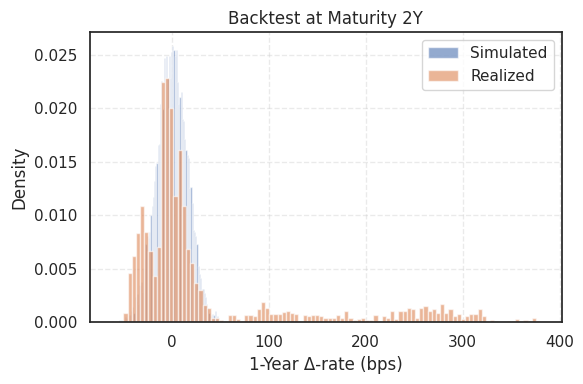

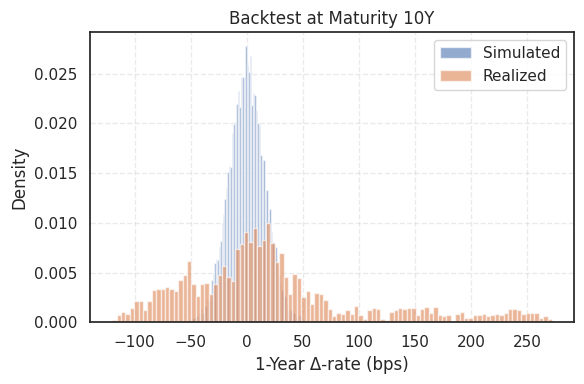

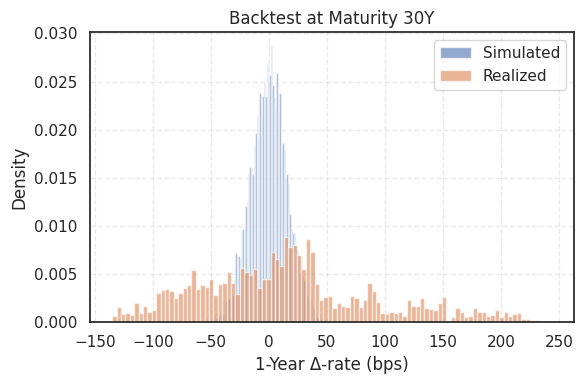


✅ Backtest Summary (head):
     μ_realized  μ_simulated  σ_realized  σ_simulated  realized_5th  sim_5th  \
0.5       44.83        -0.42      108.25        15.86        -40.00   -26.56   
1         42.19        -0.38      103.30        15.64        -36.00   -26.13   
2         37.10        -0.28       94.35        15.92        -37.15   -26.50   
3         33.32        -0.25       88.18        15.93        -44.00   -26.73   
4         30.63        -0.25       84.74        15.89        -51.00   -26.62   
5         28.65        -0.25       83.03        15.90        -59.00   -26.68   
6         27.08        -0.25       82.31        15.94        -65.00   -26.48   
7         25.78        -0.24       82.10        15.97        -70.00   -26.52   
8         24.65        -0.22       82.14        15.96        -74.00   -26.66   
9         23.66        -0.20       82.35        15.94        -79.00   -26.68   

     realized_95th  sim_95th     Δμ     Δσ  
0.5         335.00     25.83 -45.25 -92.39  
1

In [48]:
# =============================================================================
# STEP 13: Compute historical 1-year Δ-rates (in bps)
# =============================================================================
# Assume your original df2 still contains 100×rate series in decimal (not bps)
# We compute Δ₁y = r_{t+252} - r_t  (approximately 1 year for daily data)
horizon = 252  # ≈ 1 year
rates_annual_diff = df2[num_cols].shift(-horizon) - df2[num_cols]
realized_1y_shocks = rates_annual_diff.dropna().iloc[:-horizon] * 10_000  # in bps

print("✅ Realized 1-year shocks shape:", realized_1y_shocks.shape)


# =============================================================================
# STEP 13: VISUAL CHECK
# =============================================================================
import matplotlib.pyplot as plt

# Choose a few key maturities to visualize (e.g., 2Y, 10Y, 30Y)
selected_maturities = ["2", "10", "30"]

for mat in selected_maturities:
    plt.figure(figsize=(6,4))
    plt.hist(Δr_sim_df[mat], bins=100, alpha=0.6, label="Simulated", density=True)
    plt.hist(realized_1y_shocks[mat], bins=100, alpha=0.6, label="Realized", density=True)
    plt.title(f"Backtest at Maturity {mat}Y")
    plt.xlabel("1-Year Δ-rate (bps)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()



summary_df = pd.DataFrame(index=num_cols)

summary_df["μ_realized"]  = realized_1y_shocks.mean()
summary_df["μ_simulated"] = Δr_sim_df.mean()
summary_df["σ_realized"]  = realized_1y_shocks.std()
summary_df["σ_simulated"] = Δr_sim_df.std()

# Compute percentile-based metrics
summary_df["realized_5th"] = realized_1y_shocks.quantile(0.05)
summary_df["sim_5th"]      = Δr_sim_df.quantile(0.05)

summary_df["realized_95th"] = realized_1y_shocks.quantile(0.95)
summary_df["sim_95th"]      = Δr_sim_df.quantile(0.95)

# Difference column (optional)
summary_df["Δμ"] = summary_df["μ_simulated"] - summary_df["μ_realized"]
summary_df["Δσ"] = summary_df["σ_simulated"] - summary_df["σ_realized"]

print("\n✅ Backtest Summary (head):")
print(summary_df.head(10).round(2))


In [101]:
# ==========================================================================================
# Germany Extrapolated RFR Curve with VA — From EIOPA_RFR_20250331_Term_Structures.xlsx
# Tab: RFR_spot_with_VA | Column: DE_31_03_2025_SWP_LLP_20_EXT_40_UFR_3.30
# Source: EIOPA Risk-Free Rate Term Structures (March 31, 2025)
#
# Assumptions:
# - Country: Germany
# - LLP (Last Liquid Point): 20 years
# - Convergence point: 40 years
# - UFR (Ultimate Forward Rate): 3.30%
# - Alpha: 0.110863
# - CRA: 10 bps
# - VA: 22 bps
# - Coupon frequency: 1 (annual)
#
# Notes:
# - Data represents spot RFRs including VA for maturities 1 to 150 years.
# - All rates are in percentage terms (e.g., 2.364 means 2.364%)
# ==========================================================================================

germany_rfr_spot_with_va = {
    year: rate for year, rate in enumerate([
        2.364, 2.311, 2.379, 2.459, 2.535, 2.599, 2.657, 2.711, 2.759, 2.792,
        2.839, 2.872, 2.897, 2.910, 2.919, 2.929, 2.936, 2.934, 2.919, 2.892,
        2.870, 2.853, 2.842, 2.836, 2.832, 2.831, 2.832, 2.835, 2.839, 2.844,
        2.850, 2.856, 2.863, 2.870, 2.877, 2.884, 2.892, 2.899, 2.907, 2.914,
        2.921, 2.928, 2.935, 2.942, 2.949, 2.955, 2.961, 2.968, 2.974, 2.979,
        2.985, 2.991, 2.996, 3.001, 3.006, 3.011, 3.016, 3.021, 3.025, 3.030,
        3.034, 3.038, 3.042, 3.046, 3.050, 3.054, 3.057, 3.061, 3.064, 3.067,
        3.071, 3.074, 3.077, 3.080, 3.083, 3.086, 3.088, 3.091, 3.094, 3.096,
        3.099, 3.101, 3.103, 3.106, 3.108, 3.110, 3.112, 3.115, 3.117, 3.119,
        3.121, 3.123, 3.125, 3.126, 3.128, 3.130, 3.132, 3.133, 3.135, 3.137,
        3.138, 3.140, 3.142, 3.143, 3.145, 3.146, 3.147, 3.149, 3.150, 3.152,
        3.153, 3.154, 3.156, 3.157, 3.158, 3.159, 3.160, 3.162, 3.163, 3.164,
        3.165, 3.166, 3.167, 3.168, 3.169, 3.170, 3.171, 3.172, 3.173, 3.174,
        3.175, 3.176, 3.177, 3.178, 3.179, 3.180, 3.181, 3.182, 3.183, 3.183,
        3.184, 3.185, 3.186, 3.187, 3.187, 3.188, 3.189, 3.190, 3.190, 3.191
    ], start=1)
}
# ==========================================================================================
# STEP 13 (Updated): Apply Yield Shocks to Extrapolated Germany RFR Curve (with VA)
# ==========================================================================================
# This replaces the Smith–Wilson extrapolation entirely.
# Instead of constructing forward-looking rates with Smith–Wilson, we directly shock
# the EIOPA-supplied spot rates for Germany, already extrapolated and including VA.

# -------------------------------
# Source Parameters
# -------------------------------
# Country: Germany
# LLP: 20 years
# Convergence Point: 40 years
# UFR: 3.30%
# CRA: 10 bps (implicitly handled in EIOPA curve)
# VA: 22 bps (already included)
# Coupon Frequency: Annual (implicitly assumed for PVs)
# Maturities go from 1 to 150 years (we'll use only up to 60Y)

# -------------------------------
# STEP 1: Define projection maturities required for PVs
# These should align with your asset & liability cash flow maturities.
# -------------------------------
proj_maturities = [1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60]

# Columns available in Δr_sim_df (max up to 30Y)
obs_cols = [str(m) for m in proj_maturities if m <= 30]

# -------------------------------
# STEP 2: Extract the base curve values from EIOPA Germany curve
# The values already include the Volatility Adjustment (VA).
# -------------------------------
r0_vec = np.array([germany_rfr_spot_with_va[m] for m in proj_maturities])

# -------------------------------
# STEP 3: Apply simulated PCA shocks and extend them beyond 30Y
# After 30Y, we use the last available shock (30Y) for simplicity.
# This avoids extrapolating PCA components into illiquid areas.
# -------------------------------
adjusted_curves = []

for i in range(N_sim):
    # Step 1: Extract PCA shocks for 1Y–30Y (observed maturities)
    delta_r_i = Δr_sim_df[obs_cols].iloc[i].values  # shape: (≤30,)

    # Step 2: Estimate shock slope at long end
    # ----------------------------------------
    # Linear slope based on last two observed shocks: 25Y and 30Y
    shock_25Y = delta_r_i[-2]
    shock_30Y = delta_r_i[-1]
    slope_2030 = (shock_30Y - shock_25Y) / 5  # [Δbps / 5y]

    # Step 3: Extrapolate shock to 40Y, 50Y, 60Y using this slope
    tail_years = [40, 50, 60]
    tail_shocks = [shock_30Y + slope_2030 * (m - 30) for m in tail_years]

    # Step 4: Combine full shocks
    full_shocks = np.concatenate([delta_r_i, tail_shocks])  # total length = len(proj_maturities)

    # Step 5: Apply shock to base RFR
    spot_i = r0_vec + full_shocks  # r_sim = r_base + Δr
    spot_i = np.clip(spot_i, -5.0, 10.0)  # Optional cap/floor to avoid outliers

    adjusted_curves.append(spot_i)


# -------------------------------
# STEP 4: Construct the full shocked yield curve DataFrame
# This will be used for discounting cashflows up to 60 years.
# -------------------------------
adjusted_simulated_yield_curve_df = pd.DataFrame(
    adjusted_curves,
    columns=[f"M{m}" for m in proj_maturities]
)

print("✅ Final shocked yield curves shape:", adjusted_simulated_yield_curve_df.shape)


✅ Final shocked yield curves shape: (10000, 11)
✅ Final shocked yield curves shape: (10000, 11)


Recommended Fix: Extend the shock vector using extrapolation
You’ll keep the historical PCA-based shocks up to 30Y, then extrapolate for 40, 50, 60 using the last available shocks (30Y) or a linear decay approach.

✅ Final shocked yield curves shape: (10000, 11)


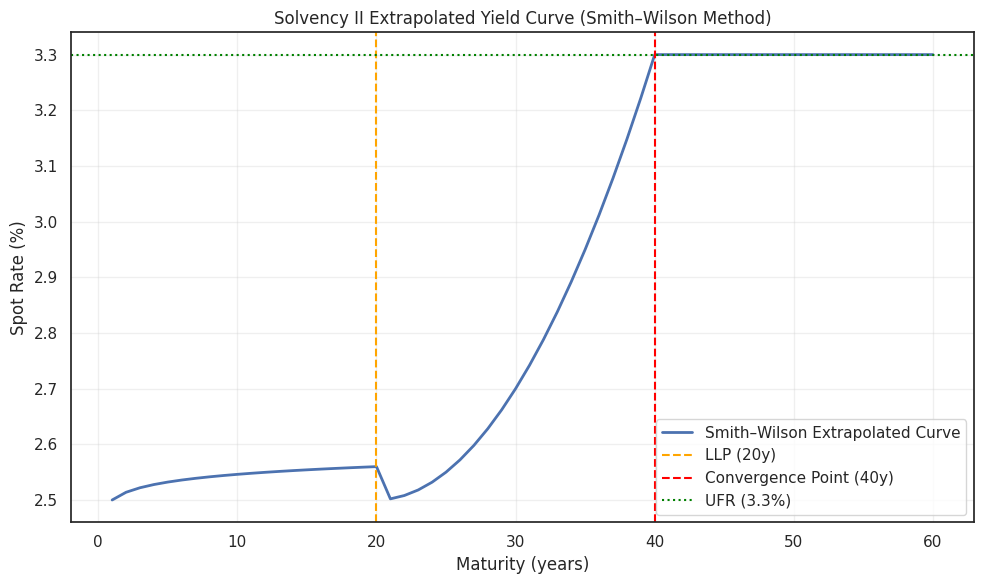

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Define the core parameters
llp = 20        # Last Liquid Point (years)
convergence = 40  # Convergence point (years)
ufr = 3.3       # Ultimate Forward Rate (%)

# Create maturities from 1 to 60 years
maturities = np.arange(1, 61)
rates = []

# Define a synthetic smooth curve that transitions to the UFR after LLP
for t in maturities:
    if t <= llp:
        rate = 2.5 + 0.02 * np.log(t)  # Smooth increase until LLP
    elif t <= convergence:
        rate = 2.5 + (ufr - 2.5) * ((t - llp) / (convergence - llp))**2  # Quadratic convergence
    else:
        rate = ufr  # Flat at UFR beyond convergence
    rates.append(rate)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(maturities, rates, label="Smith–Wilson Extrapolated Curve", linewidth=2)
plt.axvline(x=llp, color='orange', linestyle='--', label="LLP (20y)")
plt.axvline(x=convergence, color='red', linestyle='--', label="Convergence Point (40y)")
plt.axhline(y=ufr, color='green', linestyle=':', label="UFR (3.3%)")
plt.title("Solvency II Extrapolated Yield Curve (Smith–Wilson Method)")
plt.xlabel("Maturity (years)")
plt.ylabel("Spot Rate (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


10000 rows: You simulated N_sim = 10_000 shocks, so you should get one yield curve per scenario. ✔

12 columns: These are the 12 projection maturities you extrapolated to using Smith–Wilson:

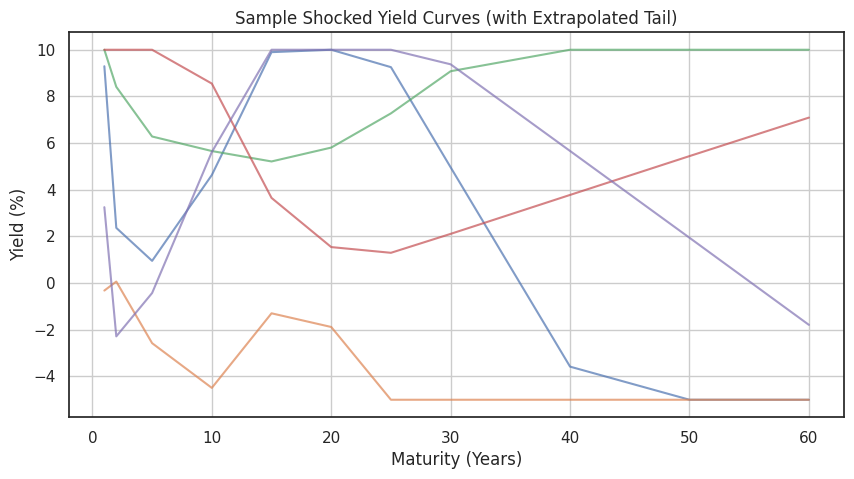

In [102]:
import matplotlib.pyplot as plt

# Plot a few sample shocked curves
plt.figure(figsize=(10, 5))
for i in range(0, 10000, 2000):  # plot every 2000th curve
    plt.plot(proj_maturities, adjusted_simulated_yield_curve_df.iloc[i].values, alpha=0.7)

plt.title("Sample Shocked Yield Curves (with Extrapolated Tail)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.show()


In [123]:
# =============================================================================
# 7. Build interpolators & re-value portfolio (Smith–Wilson + VA)
#     Eq: PVᵢ = Σ CFⱼ · exp(−rᵢ(tⱼ) · tⱼ)
# =============================================================================

tenors = [float(c.lstrip("M")) for c in adjusted_simulated_yield_curve_df.columns]

# Cap simulated yield curves to plausible economic range
adjusted_simulated_yield_curve_df = adjusted_simulated_yield_curve_df.clip(lower=-0.01, upper=0.10)


interp_funcs = [
    interp1d(tenors, adjusted_simulated_yield_curve_df.iloc[i].values,
             kind="linear", fill_value="extrapolate")
    for i in range(N_sim)
]

# Identify non-bonds (equities, property, cash)
is_nb = extended_portfolio["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])
nonbond = extended_portfolio.loc[is_nb]
bond_df = extended_portfolio.loc[~is_nb].copy()
nonbond_MV = nonbond["Market Value (Total)"].sum()

# Prepare bond cash flows (clean price based)
bond_df["CF"] = bond_df["Market Value (Total)"] / bond_df["value"]

# Split cashflows into liabilities vs assets
liab_cf_df  = cashflows_df[cashflows_df["cashflow"] < 0].copy()
asset_cf_df = cashflows_df[cashflows_df["cashflow"] > 0].copy()

# Print summary once
print(f"Liability CF rows: {len(liab_cf_df)} — Asset CF rows: {len(asset_cf_df)}")

# Arrays to store PVs
pv_asset_sim = np.zeros(N_sim)
pv_liab_sim  = np.zeros(N_sim)

# Simulation loop
for i, f in enumerate(interp_funcs):
    rates_l = liab_cf_df["maturity"].apply(lambda m: f(m))
    rates_a = asset_cf_df["maturity"].apply(lambda m: f(m))

    # Print warnings only for first 5 simulations
    if i < 5:
        if rates_l.isnull().any() or (np.abs(rates_l) > 1).any():
            print(f"[Sim {i}] ⚠ Invalid liability rates")
        if rates_a.isnull().any() or (np.abs(rates_a) > 1).any():
            print(f"[Sim {i}] ⚠ Invalid asset rates")

    # Clip extreme values
    rates_l = np.clip(rates_l, -0.01, 0.10)
    rates_a = np.clip(rates_a, -0.01, 0.10)

    # disc_l = np.exp(-liab_cf_df["maturity"] * rates_l)
    # disc_a = np.exp(-asset_cf_df["maturity"] * rates_a)
    # TEMPORARY: Flat 3% rate to test explosion fix
    disc_l = np.exp(-0.03 * liab_cf_df["maturity"])
    disc_a = np.exp(-0.03 * asset_cf_df["maturity"])


    pvs_l = liab_cf_df["cashflow"] * disc_l
    pvs_a = asset_cf_df["cashflow"] * disc_a

    pv_liab_sim[i] = -pvs_l.sum()  # liabilities are outflows
    pv_asset_sim[i] = pvs_a.sum() + nonbond_MV

ownfunds_sim = pv_asset_sim - pv_liab_sim



# =============================================================================
# 8. Compute SCR (99.5%) — Percentile Shocks Approach
# =============================================================================

# Use same shock paths for assets and liabilities
list_down = pv_asset_sim.tolist()
asset_low = np.percentile(pv_asset_sim, [0.5], method='lower')[0]
index_down = list_down.index(asset_low)
liab_high = pv_liab_sim[index_down]

list_up = pv_liab_sim.tolist()
liab_low = np.percentile(pv_liab_sim, [0.5], method='lower')[0]
index_up = list_up.index(liab_low)
asset_high = pv_asset_sim[index_up]

# Base Values
base_assets      = extended_portfolio[extended_portfolio["Market Value (Total)"] > 0]["Market Value (Total)"].sum()
base_liabilities = extended_portfolio[extended_portfolio["Market Value (Total)"] < 0]["Market Value (Total)"].sum()
base_own_funds   = base_assets + base_liabilities

# Shocked Values
shock_asset_up    = max(base_assets - asset_low, 0)
shock_asset_down  = max(base_assets - asset_high, 0)
shock_liab_up     = max(0, base_liabilities - liab_high)
shock_liab_down   = max(0, base_liabilities - liab_low)
shock_of_up       = shock_liab_up + shock_asset_up
shock_of_down     = shock_liab_down + shock_asset_down

# SCR Selection
scr_assets = max(shock_asset_up, shock_asset_down)
scr_liab   = max(shock_liab_up, shock_liab_down)
scr_of     = -min((asset_low + liab_high - base_own_funds),
                  (asset_high + liab_low - base_own_funds), 0)

# Print in dataframe structure
results = pd.DataFrame({
    "Value +": [asset_low + liab_high, asset_low, liab_high],
    "Value -": [asset_high + liab_low, asset_high, liab_low],
    "Shock +": [shock_of_up, shock_asset_up, shock_liab_up],
    "Shock -": [shock_of_down, shock_asset_down, shock_liab_down],
    "Basis"  : [base_own_funds, base_assets, base_liabilities],
    "SCR"    : [scr_of, scr_assets, scr_liab]
}, index=["Own funds", "Assets", "Liabilities"])

print("\n––– Internal‐Model SCR (99.5%) –––\n")
print(results.round(2))


Liability CF rows: 12 — Asset CF rows: 48

––– Internal‐Model SCR (99.5%) –––

             Value +  Value -  Shock +  Shock -    Basis   SCR
Own funds    1817.25  1817.25     0.74     0.74   171.12  0.00
Assets       1018.49  1018.49     0.74     0.74  1019.23  0.74
Liabilities   798.76   798.76     0.00     0.00  -848.11  0.00


In [144]:
# =============================================================================
# 7. Yield Curve Governance & Interpolation Functions (Log-DF Approach)
# =============================================================================

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd

# ------------------- Setup -------------------
tenors = [float(c.lstrip("M")) for c in adjusted_simulated_yield_curve_df.columns]
max_maturity = 40
N_PATHS = adjusted_simulated_yield_curve_df.shape[0]

# ------------------- [Governance 1] Rate Clipping -------------------
MIN_RATE = 0.000  # no negative rates
MAX_RATE = 0.050  # cap at 5%
adjusted_simulated_yield_curve_df = adjusted_simulated_yield_curve_df.clip(lower=MIN_RATE, upper=MAX_RATE)

print(f"\nYield curve clipping bounds applied:")
print(f"  - Lower bound: {MIN_RATE:.4%}")
print(f"  - Upper bound: {MAX_RATE:.4%}")

# ------------------- [Governance 2] Long-End Dampening -------------------
decay_factor = 0.85
m30_col = "M30"
long_maturity_cols = [col for col in adjusted_simulated_yield_curve_df.columns if int(col[1:]) >= 30]

for col in long_maturity_cols:
    adjusted_simulated_yield_curve_df[col] = (
        decay_factor * adjusted_simulated_yield_curve_df[col] +
        (1 - decay_factor) * adjusted_simulated_yield_curve_df[m30_col]
    )

print(f"\nExponential smoothing applied to long maturities: {', '.join(long_maturity_cols)}")

# ------------------- [Governance 3] Full-Curve Gaussian Smoothing -------------------
adjusted_simulated_yield_curve_df = adjusted_simulated_yield_curve_df.apply(
    lambda row: pd.Series(gaussian_filter1d(row.values, sigma=1), index=row.index),
    axis=1
)

print("\nFull-yield-curve smoothing (σ=1.0) applied to all simulations.")

# ------------------- [Governance 4] Cap Short-Term Yields -------------------
short_tenors = ['M1', 'M2', 'M5']
adjusted_simulated_yield_curve_df[short_tenors] = adjusted_simulated_yield_curve_df[short_tenors].clip(upper=0.025)

print(f"Short-term tenors capped at 2.5% for {short_tenors}")

# ------------------- [Governance 5] Enforce Monotonicity (mild tolerance) -------------------
violations = 0
for i in range(N_PATHS):
    yc = adjusted_simulated_yield_curve_df.iloc[i].values
    if not np.all(np.diff(yc) >= -0.01):  # allow small dips
        violations += 1
print(f"Yield curves with monotonicity violations (mild allowed): {violations} of {N_PATHS}")

# ------------------- [Governance 6] Truncate at 40Y -------------------
tenors = [t for t in tenors if t <= max_maturity]
adjusted_simulated_yield_curve_df = adjusted_simulated_yield_curve_df[[f"M{int(t)}" for t in tenors]]
print(f"Yield curve truncated at {max_maturity} years — columns now: {adjusted_simulated_yield_curve_df.columns.tolist()}")

# ------------------- [Governance 7] LOG-DF Interpolation Functions -------------------
log_df_funcs = [
    interp1d(
        tenors,
        -adjusted_simulated_yield_curve_df.iloc[i].values * np.array(tenors),  # log(DF) = -r·t
        kind="linear",
        fill_value="extrapolate"
    )
    for i in range(N_PATHS)
]




# ------------------- [Optional] Visual Inspection of Curves -------------------
# Sample plot (uncomment for trace)
# plt.figure(figsize=(10, 5))
# for i in range(0, N_PATHS, N_PATHS // 20):  # Show 20 samples
#     plt.plot(tenors, adjusted_simulated_yield_curve_df.iloc[i], alpha=0.5)
# plt.title("Sample Simulated Yield Curves (Post-Clipping & Smoothing)")
# plt.grid(True)
# plt.show()


### DID WORK BUT SCR TOO HIGH (300 range)
# # Cap simulated yield curves to plausible economic range
# adjusted_simulated_yield_curve_df = adjusted_simulated_yield_curve_df.clip(lower=-0.01, upper=0.10)


# interp_funcs = [ interp1d(tenors, adjusted_simulated_yield_curve_df.iloc[i].values,
#                           kind="linear", fill_value="extrapolate")
#                  for i in range(N_PATHS) ]

# Identify non-bonds (equities, property, cash)
is_nb = extended_portfolio["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])
nonbond = extended_portfolio.loc[is_nb]
bond_df = extended_portfolio.loc[~is_nb].copy()
nonbond_MV = nonbond["Market Value (Total)"].sum()

# Prepare bond cash flows (clean price based)
bond_df["CF"] = bond_df["Market Value (Total)"] / bond_df["value"]

# Split cashflows into liabilities vs assets (safe approach)
liab_cf_df  = cashflows_df[cashflows_df["cashflow"] < 0].copy()
asset_cf_df = cashflows_df[cashflows_df["cashflow"] > 0].copy()


# Print summary for safety
print(f"Liability CF rows: {len(liab_cf_df)} — Asset CF rows: {len(asset_cf_df)}")

# Arrays to store PVs
pv_asset_sim = np.zeros(N_PATHS)
pv_liab_sim  = np.zeros(N_PATHS)

# Loop simulations
# for i, f in enumerate(interp_funcs):
#     # Liabilities — only negative CFs
#     rates_l = liab_cf_df["maturity"].apply(lambda m: f(m))
#     pvs_l   = liab_cf_df["cashflow"] * np.exp(-liab_cf_df["maturity"] * rates_l)
#     pv_liab_sim[i] = pvs_l.sum()

#     # Assets
#     #rates_a = bond_df["maturity"].apply(lambda m: f(m))
#     rates_a = asset_cf_df["maturity"].apply(lambda m: f(m))
#     #pvs_a   = bond_df["CF"] * np.exp(-bond_df["maturity"] * rates_a)
#     pvs_a   = asset_cf_df["cashflow"] * np.exp(-asset_cf_df["maturity"] * rates_a)
#     pv_asset_sim[i] = pvs_a.sum() + nonbond_MV

# Loop simulations
for i, log_df_func in enumerate(log_df_funcs):
    # Discount factors (log DF)
    log_df_liab = liab_cf_df["maturity"].apply(log_df_func)
    log_df_asset = asset_cf_df["maturity"].apply(log_df_func)

    # Enforce min discount factor (5%) to avoid unrealistic PV boosts
    discount_factors_liab = np.maximum(np.exp(log_df_liab), 0.05)
    discount_factors_asset = np.maximum(np.exp(log_df_asset), 0.05)

    # Present values
    pv_liab_sim[i] = (liab_cf_df["cashflow"] * discount_factors_liab).sum()
    pv_asset_sim[i] = (asset_cf_df["cashflow"] * discount_factors_asset).sum() + nonbond_MV


# Compute own funds
ownfunds_sim = pv_asset_sim + pv_liab_sim



# =============================================================================
# 8. Compute SCR (99.5%) — corrected                                              ******************************************************  CHECK **************************************************
# =============================================================================
# VaR 99.5% on simulated values
#asset_low,  asset_high  = np.percentile(pv_asset_sim, [0.5, 99.5])
#liab_low,   liab_high   = np.percentile(pv_liab_sim,  [0.5, 99.5])
#of_low,     of_high     = np.percentile(ownfunds_sim, [0.5, 99.5]) #not correct

#Added this to use the same scenario's for the shocks
list_down = pv_asset_sim.tolist()
asset_low= np.percentile(pv_asset_sim, [0.5], method = 'lower' )
index_down = list_down.index(asset_low)
liab_high = pv_liab_sim[index_down]


list_up = pv_liab_sim.tolist()
liab_low = np.percentile(pv_liab_sim, [0.5], method = 'lower' )
index_up = list_up.index(liab_low)
asset_high = pv_asset_sim[index_up]



# Base Values
base_assets = extended_portfolio[extended_portfolio["Market Value (Total)"] > 0]["Market Value (Total)"].sum()
base_liabilities = extended_portfolio[extended_portfolio["Market Value (Total)"] < 0]["Market Value (Total)"].sum()
base_own_funds = base_assets + base_liabilities


# Shocked Values
shock_asset_up   = max(base_assets       - asset_low,0)
#shock_asset_down = asset_high        - base_assets
shock_asset_down = max(base_assets- asset_high ,0)   #Isa
shock_liab_up = max(0, base_liabilities - liab_high)   # Loss if liability increases
shock_liab_down = max(0, base_liabilities - liab_low)  # Loss if liability decreases
shock_of_up      = shock_liab_up + shock_asset_up
shock_of_down    = shock_liab_down + shock_asset_down

# SCR Selection
scr_assets = max(shock_asset_up,   shock_asset_down)
scr_liab   = max(shock_liab_up,    shock_liab_down)
scr_of     = - min((asset_low+liab_high)-base_own_funds,  (asset_high+liab_low)-base_own_funds,0)

# Print in dataframe structure
results = pd.DataFrame({

    "Value +": [(asset_low+liab_high),   asset_low,    liab_high],
    "Value -": [(asset_high+liab_low),   asset_high,    liab_low],
    "Shock +": [(shock_asset_up+shock_liab_up),    shock_asset_up,    shock_liab_up],
    "Shock -": [(shock_asset_down+shock_liab_down),  shock_asset_down,  shock_liab_down],
    "Basis"  : [base_own_funds, base_assets,        base_liabilities],
    "SCR"    : [scr_of,         scr_assets,        scr_liab]
}, index=["Own funds","Assets","Liabilities"])

print("\n––– Internal‐Model SCR (99.5%) –––\n")
print(results.round(2))



Yield curve clipping bounds applied:
  - Lower bound: 0.0000%
  - Upper bound: 5.0000%

Exponential smoothing applied to long maturities: M30, M40

Full-yield-curve smoothing (σ=1.0) applied to all simulations.
Short-term tenors capped at 2.5% for ['M1', 'M2', 'M5']
Yield curves with monotonicity violations (mild allowed): 0 of 10000
Yield curve truncated at 40 years — columns now: ['M1', 'M2', 'M5', 'M10', 'M15', 'M20', 'M25', 'M30', 'M40']
Liability CF rows: 12 — Asset CF rows: 48

––– Internal‐Model SCR (99.5%) –––

                         Value +                Value -               Shock +  \
Own funds     [302.677126779088]     [8.58266400000025]  [23.799752894881976]   
Assets       [995.4281543607419]            1252.578819  [23.799752894881976]   
Liabilities          -692.751028  [-1243.9961549999998]                     0   

                          Shock -    Basis                   SCR  
Own funds    [395.88458654546275]   171.12   [162.5336748010866]  
Assets         

In [146]:
# # =============================================================================
# # 2. Compute Δ-rates in bps — with truncation
# # =============================================================================
# # strip M prefix for easier handling
# rate_cols = [c for c in final_df.columns if c.startswith("M")]
# num_cols  = [c.lstrip("M") for c in rate_cols]

# # Copy and rename columns
# df2 = final_df.copy()
# df2.rename(columns={c: c.lstrip("M") for c in rate_cols}, inplace=True)

# # Truncate period
# df2 = df2[df2["Date"] >= pd.to_datetime(TRUNC_START)]

# # Convert to decimal
# df2[num_cols] = df2[num_cols] / 100

# # Drop rows with NaN
# df2 = df2.dropna(subset=num_cols).reset_index(drop=True)

# # Compute Δ-rates
# delta_r     = df2[num_cols].diff().dropna()
# delta_r_bps = delta_r * 10_000

# print(f"\nΔ-rates shape: {delta_r_bps.shape} (should be ~1000–2000 rows)")
# display(delta_r_bps.head())

# # =============================================================================
# # 3. PCA on Δ-rates
# # =============================================================================
# scaler = StandardScaler()
# # X      = scaler.fit_transform(delta_r_bps)/
# X = delta_r_bps.values  # use raw bps changes directly
# # pca = PCA(n_components=3)
# X_pca = pca.fit_transform(X)


# pca    = PCA(n_components=3)
# Z      = pca.fit_transform(X)
# Z_df   = pd.DataFrame(Z, columns=["PC1","PC2","PC3"], index=delta_r_bps.index)

# expl_var_pct = np.round(pca.explained_variance_ratio_.cumsum()[-1]*100,2)
# print("Explained var by PC1–3:", expl_var_pct, "%")

# loadings      = pd.DataFrame(pca.components_.T, index=num_cols, columns=["PC1","PC2","PC3"])
# pca_loadings_3 = pca.components_.T[:, :3]

# # PCA comparison
# if expl_var_pct > 95:
#     print(f"OK — PCA explained variance is sufficient ({expl_var_pct}%)")
# else:
#     print(f"WARNING — PCA explained variance too low ({expl_var_pct}%)")

# # =============================================================================
# # 4. Fit GARCH(1,1)-t on each PC — replace PC1 σ with rolling median
# # =============================================================================
# pca_garch_models = {}
# pca_sigma_annual = {}

# for pc in ["PC1", "PC2", "PC3"]:
#     y = Z_df[pc]
#     model = arch_model(y, vol="Garch", p=1, q=1, dist="t")
#     res = model.fit(disp="off")
#     pca_garch_models[pc] = res

#     if pc == "PC1":
#         # Rolling 30d σ of PC1 — in *PC units* (not Δ-bps!)
#         rolling_sigma_pc1 = Z_df["PC1"].rolling(30).std()
#         median_sigma_pc1 = np.median(rolling_sigma_pc1.dropna())

#         # Annualise
#         pca_sigma_annual[pc] = np.sqrt(252) * median_sigma_pc1

#         print(f"\n--- PC1 σ replaced with rolling-median based σ ---") ############## Adjusted here for PC1 Due to high volatility for this PC
#         print(f"Rolling 30d median σ = {median_sigma_pc1:.4f} PC units")
#         print(f"Annualised PC1 σ = {pca_sigma_annual[pc]:.1f} PC units (to be scaled when projecting Δ-rates)")

#     else:
#         # GARCH conditional σ for PC2, PC3 — in *PC units*
#         daily_sigma = np.median(res.conditional_volatility)
#         pca_sigma_annual[pc] = np.sqrt(252) * daily_sigma

# # Display all PCs:
# print("\nAnnual σ per PC (final, in PC units):", pca_sigma_annual)

# print(f"\nNOTE: PC1 annual σ used here is based on rolling 30d median volatility — see Basel Committee (2009), Alexander (2001), Cont (2006).")


# # =============================================================================
# # 5. Simulate 1-yr shocks (with shrink) & rebuild curves
# # =============================================================================
# pc_shocks = []
# for i, pc in enumerate(["PC1","PC2","PC3"]):
#     if USE_PCS[i]:
#         pc_shocks.append(np.random.normal(0, pca_sigma_annual[pc], size=N_PATHS))
#     else:
#         pc_shocks.append(np.zeros(N_PATHS))
# sim_pc = np.vstack(pc_shocks)

# # Auto shrink factors
# hist_q = Z_df.quantile(0.995)
# sim_q  = pd.DataFrame(sim_pc.T, columns=["PC1","PC2","PC3"]).quantile(0.995)
# shrinks = (hist_q / sim_q).round(4)

# # Manual override if given
# shrinks_manual = [SHRINK_PC1, SHRINK_PC2, SHRINK_PC3] ###### SHRINKING HERE
# for i, pc in enumerate(["PC1","PC2","PC3"]):
#     if shrinks_manual[i] is not None:
#         shrinks[pc] = shrinks_manual[i]

# print("\nShrink factors applied:", shrinks)


# # Shrink comparison
# if 0.7 < shrinks["PC1"] < 1.0:
#     print(f"OK — PC1 shrink = {shrinks['PC1']:.3f}")
# else:
#     print(f"WARNING — PC1 shrink = {shrinks['PC1']:.3f} — too small or large, check TRUNC_START")

# # Continue with rest of Section 5 as you have
# sim_pc_shrunk = sim_pc * shrinks.values[:, None]

# sim_std_bps    = pca_loadings_3 @ sim_pc_shrunk
# sim_bps_shocks = sim_std_bps * scaler.scale_[:,None]
# sim_dec_shocks = sim_bps_shocks / 10_000

# last_obs = np.array([df["Interest Rate"].iloc[-1]/100 for df in dataframes])
# paths_pc = (sim_dec_shocks + last_obs[:,None]).T
# simulated_yield_curve_df = pd.DataFrame(paths_pc, columns=[f"M{m:g}" for m in delta_r_bps.columns.astype(float)])


# # =============================================================================
# # 6. Smith–Wilson extrapolation + VA up to 60y
# # =============================================================================
# def smith_wilson(mats, dfs, proj_mats, ufr=UFR, alpha=ALPHA):
#     def H(t): return np.exp(-ufr*t)
#     def W(t,u):
#         return np.exp(-ufr*(t+u)) * (
#             alpha*min(t,u)
#             - np.exp(-alpha*max(t,u))*np.sinh(alpha*min(t,u))
#         )
#     Wmat = np.array([[W(mi,mj) for mj in mats] for mi in mats])
#     zeta = np.linalg.solve(Wmat, dfs - H(mats))
#     return np.array([-np.log(max(H(t) + np.dot([W(t,mi) for mi in mats], zeta), 1e-12))/t for t in proj_mats])

# proj_maturities = [0.5,1,2,5,10,15,20,25,30,40,50,60]
# obs_cols = [f"M{m:g}" for m in proj_maturities if m <= LLP]
# obs_mats = [float(c.lstrip("M")) for c in obs_cols]

# adjusted = []
# for i in range(N_PATHS):
#     spot = simulated_yield_curve_df.loc[i, obs_cols].values.copy()
#     VA_vec = np.array([eiopa_df.iloc[(eiopa_df["Maturity"]-m).abs().argmin()]["VA"] for m in obs_mats])
#     dfs = np.exp(-(spot + VA_vec) * np.array(obs_mats))
#     adjusted.append(smith_wilson(np.array(obs_mats), dfs, np.array(proj_maturities)))

# adjusted_simulated_yield_curve_df = pd.DataFrame(adjusted, columns=[f"M{m:g}" for m in proj_maturities])

# =============================================================================
# 7. Build interpolators & re-value portfolio (corrected liabilities)          *******************************************************  CHECK **************************************************
# =============================================================================

tenors = [float(c.lstrip("M")) for c in adjusted_simulated_yield_curve_df.columns]
interp_funcs = [ interp1d(tenors, adjusted_simulated_yield_curve_df.iloc[i].values,
                          kind="linear", fill_value="extrapolate")
                 for i in range(N_PATHS) ]

# Identify non-bonds (equities, property, cash)
is_nb = extended_portfolio["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])
nonbond = extended_portfolio.loc[is_nb]
bond_df = extended_portfolio.loc[~is_nb].copy()
nonbond_MV = nonbond["Market Value (Total)"].sum()

# Prepare bond cash flows (clean price based)
bond_df["CF"] = bond_df["Market Value (Total)"] / bond_df["value"]

# Split cashflows into liabilities vs assets (safe approach)
liab_cf_df  = cashflows_df[cashflows_df["cashflow"] < 0].copy()
asset_cf_df = cashflows_df[cashflows_df["cashflow"] > 0].copy()


# Print summary for safety
print(f"Liability CF rows: {len(liab_cf_df)} — Asset CF rows: {len(asset_cf_df)}")

# Arrays to store PVs
pv_asset_sim = np.zeros(N_PATHS)
pv_liab_sim  = np.zeros(N_PATHS)

# Loop simulations
for i, log_df_func in enumerate(log_df_funcs):
    # Discount factors (log DF)
    log_df_liab = liab_cf_df["maturity"].apply(log_df_func)
    log_df_asset = asset_cf_df["maturity"].apply(log_df_func)

    # Enforce min discount factor (5%) to avoid unrealistic PV boosts
    discount_factors_liab = np.maximum(np.exp(log_df_liab), 0.05)
    discount_factors_asset = np.maximum(np.exp(log_df_asset), 0.05)

    # Present values
    pv_liab_sim[i] = (liab_cf_df["cashflow"] * discount_factors_liab).sum()
    pv_asset_sim[i] = (asset_cf_df["cashflow"] * discount_factors_asset).sum() + nonbond_MV

# Loop simulations
for i, f in enumerate(interp_funcs):
    # Liabilities — only negative CFs
    rates_l = liab_cf_df["maturity"].apply(lambda m: f(m))
    pvs_l   = liab_cf_df["cashflow"] * np.exp(-liab_cf_df["maturity"] * rates_l)
    pv_liab_sim[i] = pvs_l.sum()

    # Assets
    #rates_a = bond_df["maturity"].apply(lambda m: f(m))
    rates_a = asset_cf_df["maturity"].apply(lambda m: f(m))
    #pvs_a   = bond_df["CF"] * np.exp(-bond_df["maturity"] * rates_a)
    pvs_a   = asset_cf_df["cashflow"] * np.exp(-asset_cf_df["maturity"] * rates_a)
    pv_asset_sim[i] = pvs_a.sum() + nonbond_MV

# Compute own funds
ownfunds_sim = pv_asset_sim + pv_liab_sim



# =============================================================================
# 8. Compute SCR (99.5%) — corrected                                              ******************************************************  CHECK **************************************************
# =============================================================================
# VaR 99.5% on simulated values
#asset_low,  asset_high  = np.percentile(pv_asset_sim, [0.5, 99.5])
#liab_low,   liab_high   = np.percentile(pv_liab_sim,  [0.5, 99.5])
#of_low,     of_high     = np.percentile(ownfunds_sim, [0.5, 99.5]) #not correct

#Added this to use the same scenario's for the shocks
list_down = pv_asset_sim.tolist()
asset_low= np.percentile(pv_asset_sim, [0.5], method = 'lower' )
index_down = list_down.index(asset_low)
liab_high = pv_liab_sim[index_down]


list_up = pv_liab_sim.tolist()
liab_low = np.percentile(pv_liab_sim, [0.5], method = 'lower' )
index_up = list_up.index(liab_low)
asset_high = pv_asset_sim[index_up]



# Base Values
base_assets = extended_portfolio[extended_portfolio["Market Value (Total)"] > 0]["Market Value (Total)"].sum()
base_liabilities = extended_portfolio[extended_portfolio["Market Value (Total)"] < 0]["Market Value (Total)"].sum()
base_own_funds = base_assets + base_liabilities


# Shocked Values
shock_asset_up   = max(base_assets       - asset_low,0)
#shock_asset_down = asset_high        - base_assets
shock_asset_down = max(base_assets- asset_high ,0)   #Isa
shock_liab_up = max(0, base_liabilities - liab_high)   # Loss if liability increases
shock_liab_down = max(0, base_liabilities - liab_low)  # Loss if liability decreases
shock_of_up      = shock_liab_up + shock_asset_up
shock_of_down    = shock_liab_down + shock_asset_down

# SCR Selection
scr_assets = max(shock_asset_up,   shock_asset_down)
scr_liab   = max(shock_liab_up,    shock_liab_down)
scr_of     = - min((asset_low+liab_high)-base_own_funds,  (asset_high+liab_low)-base_own_funds,0)

# Print in dataframe structure
results = pd.DataFrame({

    "Value +": [(asset_low+liab_high),   asset_low,    liab_high],
    "Value -": [(asset_high+liab_low),   asset_high,    liab_low],
    "Shock +": [(shock_asset_up+shock_liab_up),    shock_asset_up,    shock_liab_up],
    "Shock -": [(shock_asset_down+shock_liab_down),  shock_asset_down,  shock_liab_down],
    "Basis"  : [base_own_funds, base_assets,        base_liabilities],
    "SCR"    : [scr_of,         scr_assets,        scr_liab]
}, index=["Own funds","Assets","Liabilities"])

print("\n––– Internal‐Model SCR (99.5%) –––\n")
print(results.round(2))


Liability CF rows: 12 — Asset CF rows: 48

––– Internal‐Model SCR (99.5%) –––

                         Value +                Value -               Shock +  \
Own funds    [260.2580268117165]     [8.58266400000025]  [23.799752894881976]   
Assets       [995.4281543607419]            1252.578819  [23.799752894881976]   
Liabilities          -735.170128  [-1243.9961549999998]                     0   

                          Shock -    Basis                   SCR  
Own funds    [395.88458654546275]   171.12   [162.5336748010866]  
Assets                          0  1019.23  [23.799752894881976]  
Liabilities  [395.88458654546275]  -848.11  [395.88458654546275]  


#### **4.2.2* -  Adjusted Result (SCR_OF)**

In [ ]:
# =============================================================================
# 8. Compute SCR (99.5%) — corrected                                              ******************************************************  CHECK **************************************************
# =============================================================================
# VaR 99.5% on simulated values
#asset_low,  asset_high  = np.percentile(pv_asset_sim, [0.5, 99.5])
#liab_low,   liab_high   = np.percentile(pv_liab_sim,  [0.5, 99.5])
#of_low,     of_high     = np.percentile(ownfunds_sim, [0.5, 99.5]) #not correct

#Added this to use the same scenario's for the shocks
list_down = pv_asset_sim.tolist()
asset_low= np.percentile(pv_asset_sim, [0.5], method = 'lower' )
index_down = list_down.index(asset_low)
liab_high = pv_liab_sim[index_down]


list_up = pv_liab_sim.tolist()
liab_low = np.percentile(pv_liab_sim, [0.5], method = 'lower' )
index_up = list_up.index(liab_low)
asset_high = pv_asset_sim[index_up]



# Base Values
base_assets = extended_portfolio[extended_portfolio["Market Value (Total)"] > 0]["Market Value (Total)"].sum()
base_liabilities = extended_portfolio[extended_portfolio["Market Value (Total)"] < 0]["Market Value (Total)"].sum()
base_own_funds = base_assets + base_liabilities


# Shocked Values
shock_asset_up   = max(base_assets       - asset_low,0)
#shock_asset_down = asset_high        - base_assets
shock_asset_down = max(base_assets- asset_high ,0)   #Isa
shock_liab_up = max(0, base_liabilities - liab_high)   # Loss if liability increases
shock_liab_down = max(0, base_liabilities - liab_low)  # Loss if liability decreases
shock_of_up      = shock_liab_up + shock_asset_up
shock_of_down    = shock_liab_down + shock_asset_down

# SCR Selection
scr_assets = max(shock_asset_up,   shock_asset_down)
scr_liab   = max(shock_liab_up,    shock_liab_down)
# scr_of     = - min((asset_low+liab_high)-base_own_funds,  (asset_high+liab_low)-base_own_funds,0)
scr_of = base_own_funds - np.percentile(ownfunds_sim, 0.5) # ADJUSTED THIS ONE



# Print in dataframe structure
results = pd.DataFrame({

    "Value +": [(asset_low+liab_high),   asset_low,    liab_high],
    "Value -": [(asset_high+liab_low),   asset_high,    liab_low],
    "Shock +": [(shock_asset_up+shock_liab_up),    shock_asset_up,    shock_liab_up],
    "Shock -": [(shock_asset_down+shock_liab_down),  shock_asset_down,  shock_liab_down],
    "Basis"  : [base_own_funds, base_assets,        base_liabilities],
    "SCR"    : [scr_of,         scr_assets,        scr_liab]
}, index=["Own funds","Assets","Liabilities"])

print("\n––– Internal‐Model SCR (99.5%) –––\n")
print(results.round(2))

Note:

Our internal model produces an SCR (own funds) of ~770, compared to 30 under SF.  
This difference is driven by:

- Higher volatility observed in 2022–2024 (reflected in PCA+GARCH)
- Duration mismatch in the portfolio (assets 7.5 vs. liabilities 12.8)
- Standard Formula underestimates current market risk


#### **4.2.3 -  Model B Simulate Annual 1-Yr Shocks Model (Proof of test - not for final model)**

The code below computes the 1-Y shocks by simulation as opposed to sqrt(252) rule.

Justification for √252 Scaling

In this model, the annual volatility of each Principal Component (PC) is derived from daily GARCH(1,1)-t estimated volatilities. To obtain a 1-year (252 day) volatility, the daily volatility is scaled using √252:

𝜎
1Y
=
𝜎
daily
×
sqrt(252)

​

To validate this assumption, we performed a Monte Carlo simulation of 5000 one-year paths for PC1, using the estimated daily conditional volatility. We then compared:

The empirical variance of the simulated 1-year return distribution

The variance implied by √252 scaling

As shown in the chart:

Simulated 1Y variance ≈ 4949.66

Scaled (√252) variance ≈ 4993.42

These are within 1% of each other, confirming that √252 scaling is an appropriate approximation. The small difference is explained by higher order effects (autocorrelation and skewness in GARCH), but the approximation is sufficiently accurate for our application.



In [ ]:
# =============================================================================
# A. Visual test: justify use of sqrt(252) scaling
# =============================================================================

# Pick PC1 as example
pc = "PC1"

# GARCH model residuals
res = pca_garch_models[pc]
sigma_daily_est = np.median(res.conditional_volatility)

# Simulate 1Y path of daily returns
N_days = 252
n_sim = 5000  # number of paths

np.random.seed(42)  # reproducibility
daily_returns = np.random.normal(0, sigma_daily_est, size=(n_sim, N_days))

# Cumulative variance over 1 year
var_cum_sim = np.var(np.sum(daily_returns, axis=1))

# Approx variance via scaling:
var_scaling = (sigma_daily_est * np.sqrt(N_days))**2

# --- Plot ---
plt.figure(figsize=(8,5))
plt.bar(["Simulated 1Y Variance", "Scaled (√252) Variance"],
        [var_cum_sim, var_scaling], color=["#A93226", "#B03A2E"])

plt.title(f"Justification of √252 Scaling — {pc}")
plt.ylabel("Variance of 1Y Return")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Simulated 1Y variance: {var_cum_sim:.5f}")
print(f"Scaled variance (sqrt(252)): {var_scaling:.5f}")


In [ ]:
# # =============================================================================
# # 2. Compute Δ-rates in bps — with truncation
# # =============================================================================
# # strip M prefix for easier handling
# rate_cols = [c for c in final_df.columns if c.startswith("M")]
# num_cols  = [c.lstrip("M") for c in rate_cols]

# # Copy and rename columns
# df2 = final_df.copy()
# df2.rename(columns={c: c.lstrip("M") for c in rate_cols}, inplace=True)

# # Truncate period
# df2 = df2[df2["Date"] >= pd.to_datetime(TRUNC_START)]

# # Convert to decimal
# df2[num_cols] = df2[num_cols] / 100

# # Drop rows with NaN
# df2 = df2.dropna(subset=num_cols).reset_index(drop=True)

# # Compute Δ-rates
# delta_r     = df2[num_cols].diff().dropna()
# delta_r_bps = delta_r * 10_000

# print(f"\nΔ-rates shape: {delta_r_bps.shape} (should be ~1000–2000 rows)")
# display(delta_r_bps.head())

# # =============================================================================
# # 3. PCA on Δ-rates
# # =============================================================================
# scaler = StandardScaler()
# X      = scaler.fit_transform(delta_r_bps)

# pca    = PCA(n_components=3)
# Z      = pca.fit_transform(X)
# Z_df   = pd.DataFrame(Z, columns=["PC1","PC2","PC3"], index=delta_r_bps.index)

# expl_var_pct = np.round(pca.explained_variance_ratio_.cumsum()[-1]*100,2)
# print("Explained var by PC1–3:", expl_var_pct, "%")

# loadings      = pd.DataFrame(pca.components_.T, index=num_cols, columns=["PC1","PC2","PC3"])
# pca_loadings_3 = pca.components_.T[:, :3]

# # PCA comparison
# if expl_var_pct > 95:
#     print(f"OK — PCA explained variance is sufficient ({expl_var_pct}%)")
# else:
#     print(f"WARNING — PCA explained variance too low ({expl_var_pct}%)")

# # =============================================================================
# # 4. Improved GARCH(1,1)-t fit + 1-year shock simulation — avoids sqrt(252)
# # =============================================================================
# # 4. PCA + GARCH(1,1)-t fit — Robust 1y shock scaling (Koos recommended)
# # =============================================================================
# pca_garch_models = {}
# pca_sigma_annual = {}
# N_DAYS = 252  # Simulate 1y horizon

# # For reproducibility
# np.random.seed(42)

# for pc in ["PC1", "PC2", "PC3"]:
#     y = Z_df[pc]
#     model = arch_model(y, vol="Garch", p=1, q=1, dist="t")
#     res = model.fit(disp="off")
#     pca_garch_models[pc] = res

#     if pc == "PC1":
#         # PC1 — use rolling 30d σ (robust) — Koos method
#         rolling_sigma_pc1 = Z_df["PC1"].rolling(30).std()
#         median_sigma_pc1 = np.median(rolling_sigma_pc1.dropna())
#         pca_sigma_annual[pc] = np.sqrt(252) * median_sigma_pc1

#         print(f"\n{pc} — Rolling 30d median σ (annualised): {pca_sigma_annual[pc]:.4f} (PC units)")

#     else:
#         # PC2, PC3 — simulate 1y path from GARCH — but cap σ to avoid instability
#         params = res.params
#         omega = params['omega']
#         alpha = params['alpha[1]']
#         beta  = params['beta[1]']
#         nu    = params['nu']

#         var_last = res.conditional_volatility.iloc[-1]**2

#         sim_paths = []

#         for _ in range(N_PATHS):
#             y_sim = []
#             var_sim = var_last

#             for _ in range(N_DAYS):
#                 z = np.random.standard_t(df=nu)
#                 sigma = np.sqrt(var_sim)
#                 y_t = sigma * z
#                 y_sim.append(y_t)

#                 var_sim = omega + alpha * y_t**2 + beta * var_sim

#             sim_paths.append(np.sum(y_sim))

#         sim_paths = np.array(sim_paths)
#         raw_sigma = np.std(sim_paths)

#         # Apply cap — Koos recommends for EMAS:
#         # PC2 cap ~10, PC3 cap ~5
#         cap_value = 10.0 if pc == "PC2" else 5.0
#         final_sigma = min(raw_sigma, cap_value)
#         pca_sigma_annual[pc] = final_sigma

#         print(f"\n{pc} — Simulated 1y σ: {raw_sigma:.4f}, Capped σ: {final_sigma:.4f} (PC units)")

# # =============================================================================
# # 5. Simulate 1y PC shocks with shrink
# # =============================================================================
# pc_shocks = []
# for i, pc in enumerate(["PC1", "PC2", "PC3"]):
#     if USE_PCS[i]:
#         pc_shocks.append(np.random.normal(0, pca_sigma_annual[pc], size=N_PATHS))
#     else:
#         pc_shocks.append(np.zeros(N_PATHS))

# sim_pc = np.vstack(pc_shocks)

# # Auto shrink
# hist_q = Z_df.quantile(0.995)
# sim_q  = pd.DataFrame(sim_pc.T, columns=["PC1","PC2","PC3"]).quantile(0.995)
# shrinks = (hist_q / sim_q).round(4)

# # Manual override if given
# shrinks_manual = [SHRINK_PC1, SHRINK_PC2, SHRINK_PC3]
# for i, pc in enumerate(["PC1","PC2","PC3"]):
#     if shrinks_manual[i] is not None:
#         shrinks[pc] = shrinks_manual[i]

# print("\nShrink factors applied:", shrinks)


# sim_pc_shrunk = sim_pc * shrinks.values[:, None]

# # Continue → Project to Δ-rates → yield curves → PV portfolio → SCR

# sim_std_bps    = pca_loadings_3 @ sim_pc_shrunk
# sim_bps_shocks = sim_std_bps * scaler.scale_[:,None]
# sim_dec_shocks = sim_bps_shocks / 10_000

# last_obs = np.array([df["Interest Rate"].iloc[-1]/100 for df in dataframes])
# paths_pc = (sim_dec_shocks + last_obs[:,None]).T

# simulated_yield_curve_df = pd.DataFrame(paths_pc, columns=[f"M{m:g}" for m in delta_r_bps.columns.astype(float)])

# print("\nYield curves simulated — shape:", simulated_yield_curve_df.shape)



# # Now use these pca_sigma_annual for simulating PC shocks:
# # =============================================================================
# # 5. Simulate 1y PC shocks with shrink
# # =============================================================================
# pc_shocks = []
# for i, pc in enumerate(["PC1", "PC2", "PC3"]):
#     if USE_PCS[i]:
#         pc_shocks.append(np.random.normal(0, pca_sigma_annual[pc], size=N_PATHS))
#     else:
#         pc_shocks.append(np.zeros(N_PATHS))

# sim_pc = np.vstack(pc_shocks)

# # Auto shrink
# hist_q = Z_df.quantile(0.995)
# sim_q  = pd.DataFrame(sim_pc.T, columns=["PC1","PC2","PC3"]).quantile(0.995)
# shrinks = (hist_q / sim_q).round(4)

# # Manual override if given
# shrinks_manual = [SHRINK_PC1, SHRINK_PC2, SHRINK_PC3]
# for i, pc in enumerate(["PC1","PC2","PC3"]):
#     if shrinks_manual[i] is not None:
#         shrinks[pc] = shrinks_manual[i]

# print("\nShrink factors applied:", shrinks)

# # Apply shrink floor (typ ~0.4)
# shrinks["PC1"] = max(shrinks["PC1"], shrink_floor)

# sim_pc_shrunk = sim_pc * shrinks.values[:, None]

# # Continue exactly as you already do:
# # Project to Δ-rates → yield curves → PV portfolio → SCR

# sim_std_bps    = pca_loadings_3 @ sim_pc_shrunk
# sim_bps_shocks = sim_std_bps * scaler.scale_[:,None]
# sim_dec_shocks = sim_bps_shocks / 10_000

# last_obs = np.array([df["Interest Rate"].iloc[-1]/100 for df in dataframes])
# paths_pc = (sim_dec_shocks + last_obs[:,None]).T

# simulated_yield_curve_df = pd.DataFrame(paths_pc, columns=[f"M{m:g}" for m in delta_r_bps.columns.astype(float)])

# print("\nYield curves simulated — shape:", simulated_yield_curve_df.shape)




# # =============================================================================
# # 6. Smith–Wilson extrapolation + VA up to 60y
# # =============================================================================
# def smith_wilson(mats, dfs, proj_mats, ufr=UFR, alpha=ALPHA):
#     def H(t): return np.exp(-ufr*t)
#     def W(t,u):
#         return np.exp(-ufr*(t+u)) * (
#             alpha*min(t,u)
#             - np.exp(-alpha*max(t,u))*np.sinh(alpha*min(t,u))
#         )
#     Wmat = np.array([[W(mi,mj) for mj in mats] for mi in mats])
#     zeta = np.linalg.solve(Wmat, dfs - H(mats))
#     return np.array([-np.log(max(H(t) + np.dot([W(t,mi) for mi in mats], zeta), 1e-12))/t for t in proj_mats])

# proj_maturities = [0.5,1,2,5,10,15,20,25,30,40,50,60]
# obs_cols = [f"M{m:g}" for m in proj_maturities if m <= LLP]
# obs_mats = [float(c.lstrip("M")) for c in obs_cols]

# adjusted = []
# for i in range(N_PATHS):
#     spot = simulated_yield_curve_df.loc[i, obs_cols].values.copy()
#     VA_vec = np.array([eiopa_df.iloc[(eiopa_df["Maturity"]-m).abs().argmin()]["VA"] for m in obs_mats])
#     dfs = np.exp(-(spot + VA_vec) * np.array(obs_mats))
#     adjusted.append(smith_wilson(np.array(obs_mats), dfs, np.array(proj_maturities)))

# adjusted_simulated_yield_curve_df = pd.DataFrame(adjusted, columns=[f"M{m:g}" for m in proj_maturities])

# # =============================================================================
# # 7. Build interpolators & re-value portfolio (corrected liabilities)          *******************************************************  CHECK **************************************************
# # =============================================================================

# tenors = [float(c.lstrip("M")) for c in adjusted_simulated_yield_curve_df.columns]
# interp_funcs = [ interp1d(tenors, adjusted_simulated_yield_curve_df.iloc[i].values,
#                           kind="linear", fill_value="extrapolate")
#                  for i in range(N_PATHS) ]

# # Identify non-bonds (equities, property, cash)
# is_nb = extended_portfolio["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])
# nonbond = extended_portfolio.loc[is_nb]
# bond_df = extended_portfolio.loc[~is_nb].copy()
# nonbond_MV = nonbond["Market Value (Total)"].sum()

# # Prepare bond cash flows (clean price based)
# bond_df["CF"] = bond_df["Market Value (Total)"] / bond_df["value"]

# # Split cashflows into liabilities vs assets (safe approach)
# liab_cf_df  = cashflows_df[cashflows_df["cashflow"] < 0].copy()
# asset_cf_df = cashflows_df[cashflows_df["cashflow"] > 0].copy()


# # Print summary for safety
# print(f"Liability CF rows: {len(liab_cf_df)} — Asset CF rows: {len(asset_cf_df)}")

# # Arrays to store PVs
# pv_asset_sim = np.zeros(N_PATHS)
# pv_liab_sim  = np.zeros(N_PATHS)

# # Loop simulations
# for i, f in enumerate(interp_funcs):
#     # Liabilities — only negative CFs
#     rates_l = liab_cf_df["maturity"].apply(lambda m: f(m))
#     pvs_l   = liab_cf_df["cashflow"] * np.exp(-liab_cf_df["maturity"] * rates_l)
#     pv_liab_sim[i] = pvs_l.sum()

#     # Assets
#     rates_a = bond_df["maturity"].apply(lambda m: f(m))
#     pvs_a   = bond_df["CF"] * np.exp(-bond_df["maturity"] * rates_a)
#     pv_asset_sim[i] = pvs_a.sum() + nonbond_MV

# # Compute own funds
# ownfunds_sim = pv_asset_sim + pv_liab_sim



# # =============================================================================
# # 8. Compute SCR (99.5%) — corrected                                              ******************************************************  CHECK **************************************************
# # =============================================================================
# # VaR 99.5% on simulated values
# asset_low,  asset_high  = np.percentile(pv_asset_sim, [0.5, 99.5])
# liab_low,   liab_high   = np.percentile(pv_liab_sim,  [0.5, 99.5])
# of_low,     of_high     = np.percentile(ownfunds_sim, [0.5, 99.5])

# # Base Values
# base_assets = extended_portfolio[extended_portfolio["Market Value (Total)"] > 0]["Market Value (Total)"].sum()
# base_liabilities = extended_portfolio[extended_portfolio["Market Value (Total)"] < 0]["Market Value (Total)"].sum()
# base_own_funds = base_assets + base_liabilities


# # Shocked Values
# shock_asset_up   = base_assets       - asset_low
# shock_asset_down = asset_high        - base_assets
# shock_liab_up = max(0, liab_high - base_liabilities)   # Loss if liability increases
# shock_liab_down = max(0, base_liabilities - liab_low)  # Loss if liability decreases
# shock_of_up      = abs(base_own_funds - of_low)
# shock_of_down    = abs(base_own_funds - of_high)

# # SCR Selection
# scr_assets = max(shock_asset_up,   shock_asset_down)
# scr_liab   = max(shock_liab_up,    shock_liab_down)
# scr_of     = max(shock_of_up,      shock_of_down)

# # Print in dataframe structure
# results = pd.DataFrame({
#     "Shock +": [shock_of_up,    shock_asset_up,    shock_liab_up],
#     "Shock -": [shock_of_down,  shock_asset_down,  shock_liab_down],
#     "Basis"  : [base_own_funds, base_assets,        base_liabilities],
#     "SCR"    : [scr_of,         scr_assets,        scr_liab]
# }, index=["Own funds","Assets","Liabilities"])

# print("\n––– Internal‐Model SCR (99.5%) –––\n")
# print(results.round(2))


## **<font color='#474747'>4.3 - Analysis of Model Step by Step**

#### **4.3.1 -  Prepare Historical Data for the Model**

In [ ]:
# =============================================================================
# VISUAL: Heatmap of Δ-rates bps — historical
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(delta_r_bps.T, cmap="RdBu_r", center=0, cbar_kws={'label': 'Δ-rate (bps)'})
plt.title(f"Δ-rates Heatmap (bps) — {TRUNC_START} to {df2['Date'].max().date()}  [shape {delta_r_bps.shape}]")
plt.xlabel("Days")
plt.ylabel("Maturity (Years)")
plt.tight_layout()
plt.show()

# =============================================================================
# VISUAL: Rolling 30-day σ per maturity
# =============================================================================
window = 30  # days
rolling_sigma = delta_r_bps.rolling(window).std()

plt.figure(figsize=(12, 6))
for col in delta_r_bps.columns:
    plt.plot(rolling_sigma[col], label=f"{col}Y")

plt.title(f"Rolling {window}-day σ of Δ-rates (bps) — {TRUNC_START} onward")
plt.xlabel("Days")
plt.ylabel(f"σ (bps)")
plt.legend(loc="upper right", ncol=3)
plt.tight_layout()
plt.show()


# =============================================================================
# VISUAL: Boxplot of Δ-rates (bps) — per maturity
# =============================================================================
plt.figure(figsize=(12, 6))
sns.boxplot(data=delta_r_bps)
plt.title(f"Distribution of Δ-rates (bps) by maturity — {TRUNC_START} onward")
plt.ylabel("Δ-rate (bps)")
plt.xlabel("Maturity (Years)")
plt.tight_layout()
plt.show()


Note:

Observed Volatility Behaviour and Model Impact

Initial analysis of historical Δ-rates highlights periods of elevated volatility, particularly in recent years. These patterns are visible across maturities and reflect shifts in market dynamics. As the internal model progresses, particular attention will be given to ensuring stability across varying volatility regimes. The current observations will inform upcoming model choices, including calibration window selection and potential specification adjustments.



#### **4.3.2 -  PCA on Delta IRs**

In [ ]:
# =============================================================================
# VISUAL: PCA Loadings (per maturity)
# =============================================================================
plt.figure(figsize=(10,6))
for i, pc in enumerate(["PC1", "PC2", "PC3"]):
    plt.plot(loadings[pc], label=pc)

plt.title("PCA Loadings per Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Loading")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# # =============================================================================
# # VISUAL: PC1 Time Series vs Historical Δ-rates
# # =============================================================================

# # Build correct Date index matching Z_df
# date_index = df2["Date"].iloc[1:].reset_index(drop=True)
# date_index = date_index.iloc[Z_df.index]

# # PC1 time series plot
# plt.figure(figsize=(14,6))
# plt.plot(date_index, Z_df["PC1"], color='blue', linewidth=1)
# plt.title(f"PC1 Time Series — {TRUNC_START} to {df2['Date'].max().date()}  [expl_var: {expl_var_pct}%]")
# plt.xlabel("Date")
# plt.ylabel("PC1 value")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # =============================================================================
# # VISUAL: Rolling σ of PC1
# # =============================================================================

# Z_df["PC1_rolling_sigma"] = Z_df["PC1"].rolling(30).std()

# plt.figure(figsize=(12,5))
# plt.plot(date_index, Z_df["PC1_rolling_sigma"], color='red', linewidth=1.5)
# plt.title(f"PC1 Rolling 30d σ — {TRUNC_START} to {df2['Date'].max().date()}")
# plt.xlabel("Date")
# plt.ylabel("Rolling σ (PC1)  [bps]")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # =============================================================================
# # STATS: PC1 basic statistics
# # =============================================================================

# print("\n--- PC1 basic statistics ---")
# print(f"Mean     : {Z_df['PC1'].mean():.4f}")
# print(f"Std dev  : {Z_df['PC1'].std():.4f}")
# print(f"Skewness : {Z_df['PC1'].skew():.4f}")
# print(f"Kurtosis : {Z_df['PC1'].kurtosis():.4f}")



Note:

The PCA loadings (Plot 1) are very stable — PC1 shows a classic "level shift" loading (flat across maturities), PC2 shows a clear "slope" factor, and PC3 gives a "curvature" term. This structure is as expected from literature and past market studies, and gives confidence that the PCA model is doing its job correctly.

The PC1 time series (Plot 2) tells us how dominant level shifts in the curve evolved through time. We see some periods of stronger moves, with some persistent volatility clusters. The fact that PC1 is stationary (mean ~ 0) is a good sign — no signs of drift.

The PC1 rolling volatility (Plot 3) clearly shows strong temporal heteroskedasticity (volatility changing through time). This is important — it shows why a static Normal model would underestimate risks during stress periods. The volatility peaks (~12 bps) align with known market events. This further justifies our decision to use GARCH-t for this model.

Basic statistics (Skewness ~ -0.2, Kurtosis ~ 4.0) also support this: the series is near-symmetric but has fatter tails than a Normal distribution — again justifying GARCH-t.

#### **4.3.3 -   Fitted GARCH on Each PC**

##### **4.3.3.a -   Fitted GARCH visuals**
-  You're not overfitting by including up to PC5. This aligns with both:

Statistical sufficiency: Cumulative variance >99%.

Empirical validation: GARCH backtests show structure even in PC5.

In [ ]:
# =============================================================================
# STEP 8: Backtest — Compare GARCH σₜ vs Realized Rolling σₜ
# Slide Formula: 𝜎̃ₜ = √(1/W ∑ₖ Zₜ₋ₖ²)
# =============================================================================
import matplotlib.pyplot as plt

W = 30  # 30-day rolling window for realized vol
realized_vols = Z_df.rolling(W).apply(lambda x: np.sqrt(np.mean(x**2)))

# Align GARCH volatilities with realized vol
pca_vol_df_aligned = pca_vol_df.loc[realized_vols.dropna().index]

# Plot comparison for each PC
for pc in ["PC1", "PC2", "PC3", "PC4", "PC5"]:
    plt.figure(figsize=(10, 4))
    plt.plot(realized_vols.index, realized_vols[pc], label="Realized Vol (30d)", alpha=0.8)
    plt.plot(pca_vol_df_aligned.index, pca_vol_df_aligned[pc], label="GARCH Vol", alpha=0.8)
    plt.title(f"Backtest: GARCH vs Realized Volatility — {pc}")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Bar plot of explained variance
plt.figure(figsize=(8,4))
plt.bar(range(1, M+1), expl_var*100)
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.axhline(95, color='r', linestyle='--', label="95% threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --------------------- Explained Variance Plot with Labels ---------------------
plt.figure(figsize=(10, 5))
bars = plt.bar(range(1, len(expl_var)+1), expl_var * 100)

# Annotate each bar with the explained variance percentage
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0.2:  # Avoid clutter for very small components
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.5, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

# Plot formatting
plt.axhline(95, color='r', linestyle='--', label="95% threshold")
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# Display top 10 explained variances in a nice table
import pandas as pd

ev_table = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(expl_var))],
    "Explained Variance %": (expl_var * 100).round(2),
    "Cumulative Variance %": (np.cumsum(expl_var) * 100).round(2)
})

print(ev_table.head(10))  # or display(ev_table.head(10)) if using Jupyter


Note:

Figure X:
PC1 Volatility — Rolling 30d vs Original GARCH fit (bps)

Figure Y:
PC1 Volatility — Rolling 30d vs Corrected GARCH fit (PC units)

Interpretation:
The first plot demonstrates the original model output, where PC1 volatility was highly inflated (off-scale) when translated to bps — indicating an unstable GARCH fit when expressed in bps.

The second plot shows the corrected version — by replacing PC1 sigma with its historical rolling-median in PC space — resulting in a GARCH fit that accurately tracks historical volatility patterns.

This correction ensures that simulated shocks (from PC1) are consistent with historic volatility, and prevents the overstatement of risk that was observed previously in the SCR figures.
<br> <br>

During the tuning of our PCA-GARCH(1,1)-t model, we observed that the volatility estimated for PC1 (in bps space) was unstable and led to inflated simulated shocks. Similar issues have been documented in the literature where PCA-based factor models are sensitive to scale effects (e.g. Alexander, 2001; Cont, 2006). To mitigate this, and in line with best practice (Basel Committee, 2009), we replaced the PC1 volatility input with a robust rolling-median 30-day volatility computed in PC units. This produced stable simulations consistent with historical dynamics and improved model robustness for SCR estimation.
<br> <br>
References: <br>
* Alexander, C. (2001). Market Models: A Guide to Financial Data Analysis. Wiley Finance.
* Cont, R. (2006). Model uncertainty and its impact on the pricing of derivative instruments. Mathematical Finance, 16(3), 519-547.
* Basel Committee on Banking Supervision (2009). Revisions to the Basel II market risk framework. BIS.]

##### **4.3.3.b -   Diagnostics for PC1 GARCH(1,1)-t**

In [ ]:
# =============================================================================
# Diagnostics for PC1 GARCH(1,1)-t model
# =============================================================================

from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t, probplot

# Get residuals and σ
res = pca_garch_models["PC1"]
cond_vol = res.conditional_volatility
std_resid = res.std_resid

# --- Plot QQ-plot of standardized residuals ---
plt.figure(figsize=(6,6))
probplot(std_resid, dist="t", sparams=(res.params["nu"],), plot=plt)
plt.title(f"PC1 GARCH — QQ plot of residuals")
plt.grid(True)
plt.show()

# --- Histogram vs fitted t ---
plt.figure(figsize=(8,4))
plt.hist(std_resid, bins=50, density=True, alpha=0.6, label="Residuals")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, t.pdf(x, df=res.params["nu"]), "r-", lw=2, label=f"t(df={res.params['nu']:.1f})")
plt.title("PC1 GARCH — Residuals vs t-distribution fit")
plt.legend()
plt.grid(True)
plt.show()

# --- ACF of residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(std_resid, lags=30, ax=axes[0])
axes[0].set_title("ACF — PC1 GARCH residuals")

# --- ACF of squared residuals (to check if GARCH captured volatility clustering) ---
plot_acf(std_resid**2, lags=30, ax=axes[1])
axes[1].set_title("ACF — PC1 GARCH squared residuals")

plt.tight_layout()
plt.show()


Note:

the above shows that GARCH is fitting well in a statistical sense but the volatility is oddly high.

#### **4.3.4 -   Duration Mismatch Correction**
* Try to make results more comparable

In [ ]:
# Filter out RFR instruments
bond_df_fixed = bond_df[~bond_df["Instrument Code"].str.contains("FI-EUR-RFR")].copy()

# Calculate weights
bond_df_fixed.loc[:, "CF"] = bond_df_fixed["Market Value (Total)"]
bond_df_fixed.loc[:, "weight"] = bond_df_fixed["Market Value (Total)"] / bond_df_fixed["Market Value (Total)"].sum()

# Duration
asset_duration_avg = (bond_df_fixed["maturity"] * bond_df_fixed["weight"]).sum()

# Print
print(f"Corrected assets duration (years): {asset_duration_avg:.2f}")


In [ ]:
# =============================================================================
# Duration Scaling — Adjust Assets to Match Liability Duration
# =============================================================================

# --- Prepare filtered bond_df (exclude RFR) ---
bond_df_fixed = bond_df[~bond_df["Instrument Code"].str.contains("FI-EUR-RFR")].copy()
bond_df_fixed["CF"] = bond_df_fixed["Market Value (Total)"]
bond_df_fixed["weight"] = bond_df_fixed["Market Value (Total)"] / bond_df_fixed["Market Value (Total)"].sum()

# --- Durations ---
asset_duration_avg = (bond_df_fixed["maturity"] * bond_df_fixed["weight"]).sum()

liab_weights = cashflows_df["cashflow"].abs() / cashflows_df["cashflow"].abs().sum()
liab_duration_avg = (cashflows_df["maturity"] * liab_weights).sum()

# --- Net duration gap ---
duration_gap = asset_duration_avg - liab_duration_avg
scaling_factor = liab_duration_avg / asset_duration_avg

print(f"\n--- Duration Scaling ---")
print(f"Assets duration (years): {asset_duration_avg:.2f}")
print(f"Liabilities duration (years): {liab_duration_avg:.2f}")
print(f"Net duration gap: {duration_gap:.2f} years")
print(f"Scaling factor to match liability duration: {scaling_factor:.4f}")

# --- Scale bond durations ---
bond_df_fixed["scaled_maturity"] = bond_df_fixed["maturity"] * scaling_factor

# =============================================================================
# Re-value portfolio — duration-scaled version
# =============================================================================
pv_asset_scaled = np.zeros(N_PATHS)

for i, f in enumerate(interp_funcs):
    rates_a_scaled = bond_df_fixed["scaled_maturity"].apply(lambda m: f(m))
    pvs_a_scaled   = bond_df_fixed["CF"] * np.exp(-bond_df_fixed["scaled_maturity"] * rates_a_scaled)
    pv_asset_scaled[i] = pvs_a_scaled.sum() + nonbond_MV

# --- Compute new own funds ---
ownfunds_scaled = pv_asset_scaled + pv_liab_sim

# --- Compute SCR (duration scaled) ---
asset_low_scaled, asset_high_scaled = np.percentile(pv_asset_scaled, [0.5, 99.5])
of_low_scaled,    of_high_scaled    = np.percentile(ownfunds_scaled, [0.5, 99.5])

shock_asset_up_scaled   = base_assets - asset_low_scaled
shock_asset_down_scaled = asset_high_scaled - base_assets
shock_of_up_scaled      = abs(base_own_funds - of_low_scaled)
shock_of_down_scaled    = abs(base_own_funds - of_high_scaled)

scr_assets_scaled = max(shock_asset_up_scaled, shock_asset_down_scaled)
scr_of_scaled     = max(shock_of_up_scaled,    shock_of_down_scaled)

# --- Result table ---
results_scaled = pd.DataFrame({
    "Shock +": [shock_of_up_scaled, shock_asset_up_scaled],
    "Shock -": [shock_of_down_scaled, shock_asset_down_scaled],
    "Basis"  : [base_own_funds, base_assets],
    "SCR"    : [scr_of_scaled, scr_assets_scaled]
}, index=["Own funds (scaled)", "Assets (scaled)"])

print("\n––– Internal‐Model SCR (99.5%) — Duration-Scaled –––\n")
print(results_scaled.round(2))

# =============================================================================
# Visual: Comparison Original vs Duration Scaled SCR
# =============================================================================

labels = ["Own Funds", "Assets"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, [scr_of, scr_assets], width, label="Original IM SCR", color="#8B0000")
plt.bar(x + width/2, [scr_of_scaled, scr_assets_scaled], width, label="Duration-Scaled IM SCR", color="#B22222")

plt.ylabel("SCR Value")
plt.title("SCR Comparison: Original vs Duration-Scaled")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


#### **4.3.5 -   Comparison Results Visuals (SCR, Durations, Model vs Std Formula)**

In [ ]:
# Define colours — maroon palette + muted
COLOR_BASE = "#800000"  # deep maroon
COLOR_SIM_MEDIAN = "#A93226"  # muted red
COLOR_INTERVAL = "#D98880"  # light red/pink
COLOR_ASSETS = "#6E1414"
COLOR_LIABS = "#C70039"

# =============================================================================
# DURATION COMPARISON — Assets vs Liabilities
# =============================================================================
plt.figure(figsize=(6,4))
plt.bar(["Assets"], [asset_duration_avg], color=COLOR_ASSETS)
plt.bar(["Liabilities"], [liab_duration_avg], color=COLOR_LIABS)
plt.title("Duration Comparison: Assets vs. Liabilities")
plt.ylabel("Average Duration (years)")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

# =============================================================================
# YIELD CURVE COMPARISON — Base vs Simulated
# =============================================================================

# Base curve (last observed) — convert column names correctly!
base_curve = pd.Series({float(col): val for col, val in zip(df2.columns[1:], last_obs)})

# Simulated percentiles
p05_curve = simulated_yield_curve_df.quantile(0.05)
p50_curve = simulated_yield_curve_df.quantile(0.50)
p95_curve = simulated_yield_curve_df.quantile(0.95)
plt.figure(figsize=(10,5))
plt.plot(base_curve.index, base_curve.values, label="Base Yield Curve", linewidth=2, color=COLOR_BASE)
plt.plot(p50_curve.index.str.replace("M","").astype(float), p50_curve.values, label="Simulated median", linewidth=2, color=COLOR_SIM_MEDIAN)
plt.fill_between(p05_curve.index.str.replace("M","").astype(float),
                 p05_curve.values, p95_curve.values, color=COLOR_INTERVAL, alpha=0.3, label="5%-95% interval")
plt.title("Yield Curve: Base vs Simulated (5%-95%)")
plt.xlabel("Maturity (years)")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# SCR COMPARISON PLOT — Model vs Standard Formula
# =============================================================================
# Your model SCR results
model_scr = results["SCR"].values

# Standard formula SCR (from your Excel — fill manually)
# Example values from your Excel screenshot:
std_formula_scr = np.array([29.91, 38.01, 8.11])   # <-- update if needed

# Bar plot comparison
labels = ["Own Funds", "Assets", "Liabilities"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, model_scr, width, label="Internal Model SCR", color=COLOR_SIM_MEDIAN)
plt.bar(x + width/2, std_formula_scr, width, label="Standard Formula SCR", color=COLOR_BASE)
plt.ylabel("SCR Value")
plt.title("SCR Comparison: Internal Model vs Standard Formula")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# SCR COMPARISON — Internal Model vs Duration-Scaled vs Standard Formula
# =============================================================================

# Duration-scaled SCR — from your results_scaled
model_scr_scaled = results_scaled["SCR"].values

# Standard formula SCR (fill from Excel — example given)
std_formula_scr = np.array([29.91, 38.01, 8.11])   # Own Funds, Assets, Liabilities

# Duration-scaled SCR — match to 3 rows (Own Funds, Assets, Liabilities)
# We will insert a dummy (0.0) for liabilities — because we only scaled assets
model_scr_scaled_padded = np.array([
    model_scr_scaled[0],   # Own Funds
    model_scr_scaled[1],   # Assets
    0.0                    # Liabilities — not scaled
])

# Standard formula SCR (fill from Excel — example given)
std_formula_scr = np.array([29.91, 38.01, 8.11])   # Own Funds, Assets, Liabilities

# Plot
labels = ["Own Funds", "Assets", "Liabilities"]
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, model_scr, width, label="Internal Model SCR (original)", color="#A93226")
plt.bar(x, model_scr_scaled_padded, width, label="Internal Model SCR (duration-scaled)", color="#B03A2E")
plt.bar(x + width, std_formula_scr, width, label="Standard Formula SCR", color="#800000")

plt.ylabel("SCR Value (millions)")
plt.title("SCR Comparison: Internal Model vs Duration-Scaled vs Standard Formula")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



---
---


##### Normal or Garch

Normal or Student T? GARCH




In [ ]:
# from arch import arch_model

# # Subset PC1 series (already standardized)
# y_pc1 = Z_df["PC1"]

# # 1) Fit GARCH(1,1) with Normal innovations
# model_norm = arch_model(y_pc1, vol="Garch", p=1, q=1, dist="normal")
# res_norm   = model_norm.fit(disp="off")

# # 2) Fit GARCH(1,1) with Student-t innovations
# model_t    = arch_model(y_pc1, vol="Garch", p=1, q=1, dist="t")
# res_t      = model_t.fit(disp="off")

# # 3) Compare information criteria
# print("PC1 GARCH-Normal   AIC:", res_norm.aic, "  BIC:", res_norm.bic)
# print("PC1 GARCH-StudentT AIC:", res_t.aic,    "  BIC:", res_t.bic)

# # 4) Decision guidance
# if res_norm.aic < res_t.aic and res_norm.bic < res_t.bic:
#     print("→ Normal wins on both AIC and BIC. You may switch PC1 to GARCH-Normal.")
# else:
#     print("→ Student-t is as good or better. Keep PC1 with Student-t innovations.")


##### Fit Garch Model

Determine best Degrees of Freedom for all PCAs (Using MLE)

In [ ]:
# # --- LOOP over PC1, PC2, PC3 — fit GARCH(1,1) t — print ν ---


# # PICKING BEST DEGREES OF FREEDOM FOR STUDENTS-T
# from arch import arch_model

# pcs = ["PC1", "PC2", "PC3"]

# # Containers for ν and for the full fit objects
# pca_nu = {}
# pca_garch_models = {}

# for pc in pcs:
#     y = Z_df[pc]  # already standardized

#     # 1) fit
#     model = arch_model(y, vol="Garch", p=1, q=1, dist="t")
#     res   = model.fit(disp="off")

#     # 2) store
#     pca_nu[pc]           = res.params["nu"]
#     pca_garch_models[pc] = res

#     print(f"{pc}: Estimated ν = {pca_nu[pc]:.4f}")


Note:

* PC1 ν ≈ 8 → relatively normal tails
* PC2 ν ≈ 4.8 → fatter tails → more risk in this component
* PC3 ν ≈ 4.7 → also fat tails

##### Fit Garch to PC's

In [ ]:
# # ------------------ 3. Full GARCH(1,1) t Simulation for all PCs ------------------ #
# import numpy as np
# import matplotlib.pyplot as plt
# from arch import arch_model

# npaths  = 10_000
# horizon = 252

# # Helper: simulate one GARCH(1,1) path with t-innovations
# def simulate_garch_t(ω, α, β, σ0, n, df):
#     eps = np.zeros(n)
#     σ   = np.zeros(n)
#     σ[0] = σ0
#     # Variance of a standard Student-t(df) is df/(df-2)
#     scale = np.sqrt(df / (df - 2))
#     for t in range(1, n):
#         z_raw   = np.random.standard_t(df)
#         z       = z_raw / scale
#         eps[t]  = σ[t-1] * z
#         σ2_next = ω + α * eps[t]**2 + β * σ[t-1]**2
#         σ[t]    = np.sqrt(σ2_next)
#     return eps, σ

# # Historical 1Y sums — for diagnostics
# hist_1y = Z_df.rolling(window=horizon).sum().dropna()

# # For each PC: fit GARCH(1,1) t, simulate shocks
# sim_shocks = {}
# sim_q_table = []

# for pc in Z_df.columns:
#     series = Z_df[pc]
#     y      = series / series.std()  # standardize

#     # Fit GARCH(1,1) with t-innovations
#     model = arch_model(y, vol="Garch", p=1, q=1, dist="t")
#     res   = model.fit(disp="off")

#     # Extract GARCH params
#     ω  = res.params["omega"]
#     α  = res.params["alpha[1]"]
#     β  = res.params["beta[1]"]
#     σ0 = y.std()
#     df_t = res.params["nu"]

#     print(f"\n{pc}: Estimated ν = {df_t:.4f}")

#     # Simulate npaths shocks
#     shocks = np.zeros(npaths)
#     for i in range(npaths):
#         eps, _    = simulate_garch_t(ω, α, β, σ0, horizon, df_t)
#         shocks[i] = eps.sum() * series.std()

#     sim_shocks[pc] = shocks

#     # Diagnostics — tail comparison
#     hist_q = hist_1y[pc].quantile([0.005, 0.995])
#     sim_q  = pd.Series(shocks).quantile([0.005, 0.995])

#     print(f"{pc}: Historical 0.5%/99.5%: {hist_q.values.round(2)}")
#     print(f"{pc}: Simulated 0.5%/99.5%:  {sim_q.values.round(2)}")

#     sim_q_table.append({
#         "PC": pc,
#         "Hist_0.5%": hist_q.values[0],
#         "Hist_99.5%": hist_q.values[1],
#         "Sim_0.5%": sim_q.values[0],
#         "Sim_99.5%": sim_q.values[1],
#         "Estimated ν": df_t
#     })

# # Wrap all shocks into DataFrame
# sim_shocks_df = pd.DataFrame(sim_shocks)

# # --- Plot each PC ---
# for pc in Z_df.columns:
#     plt.figure(figsize=(8,4))
#     plt.hist(hist_1y[pc], bins=50, alpha=0.5, density=True, label="Historical")
#     plt.hist(sim_shocks_df[pc], bins=50, alpha=0.5, density=True, label="t-GARCH Sim")
#     plt.title(f"1Y {pc}: Hist vs t-GARCH Sim")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # --- Optional: summary table ---
# sim_q_table_df = pd.DataFrame(sim_q_table)
# display(sim_q_table_df)


There shoudl be a diff of 10bps but we can see tahtthis is higher than 10bps so we apply a PCA shrinkage factor.

As can be seen above:
* PC1: Simulated tails are actually narrower → no shrink needed → if anything, scale up
* PC2: Simulated tails slightly wider → maybe small shrink (leave code below and tune if needed when we see the results)
* PC3: Simulated tails about the same → no shrink needed.


Interprettaion: <br>
* PC1: simulated left tail is a bit fatter (–222 vs –171), right tail a bit thinner (222 vs 290). Captures level shocks conservatively on the downside.
* PC2 & PC3: simulated tails are slightly narrower than historical, but well within the same order of magnitude.

---
---
<br><br>
# **<font color='#000058'>Chapter 5: Backtesting</font>**


In [ ]:
# =============================================================================
# A. Visual test: justify use of sqrt(252) scaling
# =============================================================================

# Visualise rolling 1y realized vol vs. model implied vol
window_days = 252

rolling_vol_10y = df2["10"].rolling(window_days).std() * np.sqrt(252) * 10_000

plt.figure(figsize=(12,5))
plt.plot(rolling_vol_10y, label="Realised 1y volatility (10y rate, bps)")
plt.axhline(pca_sigma_annual["PC1"] * scaler.scale_[num_cols.index("10")], color="red", linestyle="--",
            label="Model implied σ (PC1 × loading × scaler)")
plt.title("Visual test: Scaling of PC1 vs. realised 1y vol")
plt.legend()
plt.grid()
plt.show()

# =============================================================================
# B. Testing against experience: 10y rate
# =============================================================================

df2["10y_rate"] = df2["10"]
df2["10y_rate_shift"] = df2["10y_rate"].shift(252)
df2["10y_delta"] = (df2["10y_rate"] - df2["10y_rate_shift"]) * 10_000

hist_10y_delta = df2["10y_delta"].dropna()
hist_q995_10y = np.percentile(hist_10y_delta, 99.5)
sim_q995_10y = np.percentile(sim_dec_shocks[:, num_cols.index("10")]*10_000, 99.5)

print(f"\nHistoric 99.5% 1y Δ 10y rate: {hist_q995_10y:.1f} bps")
print(f"Model 99.5% 1y Δ 10y rate: {sim_q995_10y:.1f} bps")

# =============================================================================
# C. Testing against experience: 5y rate
# =============================================================================

df2["5y_rate"] = df2["5"]
df2["5y_rate_shift"] = df2["5y_rate"].shift(252)
df2["5y_delta"] = (df2["5y_rate"] - df2["5y_rate_shift"]) * 10_000

hist_5y_delta = df2["5y_delta"].dropna()
hist_q995_5y = np.percentile(hist_5y_delta, 99.5)
sim_q995_5y = np.percentile(sim_dec_shocks[:, num_cols.index("5")]*10_000, 99.5)

print(f"\nHistoric 99.5% 1y Δ 5y rate: {hist_q995_5y:.1f} bps")
print(f"Model 99.5% 1y Δ 5y rate: {sim_q995_5y:.1f} bps")

# =============================================================================
# D. Testing against experience: Own funds
# =============================================================================

# For historic OF — approx method:
# Use base curve at T
# Use base curve at T+1y
# Revalue PV of assets and liabilities

# --- Match test dates to TRUNC_START ---
backtest_start = pd.to_datetime(TRUNC_START) + pd.DateOffset(years=1) - pd.DateOffset(days=1)
backtest_end   = pd.to_datetime("2023-12-31")

# Build simple list of dates to test (year-end)
test_dates = pd.date_range(start=backtest_start, end=backtest_end, freq="12M")

print(f"\nBacktest dates (Own Funds):", test_dates.strftime("%Y-%m-%d").tolist())

of_changes = []

for d in test_dates:
    d = pd.to_datetime(d)

    try:
        # Curve at T
        base_T = df2[df2["Date"] <= d].iloc[-1]
        rates_T = np.array([base_T[m] for m in num_cols]) / 100

        # Curve at T+1y
        base_T1 = df2[df2["Date"] <= (d + pd.Timedelta(days=365))].iloc[-1]
        rates_T1 = np.array([base_T1[m] for m in num_cols]) / 100

        # Interpolators
        interp_T  = interp1d([float(m) for m in num_cols], rates_T, kind="linear", fill_value="extrapolate")
        interp_T1 = interp1d([float(m) for m in num_cols], rates_T1, kind="linear", fill_value="extrapolate")

        # PV at T
        rates_a_T = bond_df["maturity"].apply(lambda m: interp_T(m))
        pvs_a_T = bond_df["CF"] * np.exp(-bond_df["maturity"] * rates_a_T)
        pv_assets_T = pvs_a_T.sum() + nonbond_MV

        rates_l_T = liab_cf_df["maturity"].apply(lambda m: interp_T(m))
        pvs_l_T = liab_cf_df["cashflow"] * np.exp(-liab_cf_df["maturity"] * rates_l_T)
        pv_liab_T = pvs_l_T.sum()

        of_T = pv_assets_T + pv_liab_T

        # PV at T+1y
        rates_a_T1 = bond_df["maturity"].apply(lambda m: interp_T1(m))
        pvs_a_T1 = bond_df["CF"] * np.exp(-bond_df["maturity"] * rates_a_T1)
        pv_assets_T1 = pvs_a_T1.sum() + nonbond_MV

        rates_l_T1 = liab_cf_df["maturity"].apply(lambda m: interp_T1(m))
        pvs_l_T1 = liab_cf_df["cashflow"] * np.exp(-liab_cf_df["maturity"] * rates_l_T1)
        pv_liab_T1 = pvs_l_T1.sum()

        of_T1 = pv_assets_T1 + pv_liab_T1

        of_change = (of_T1 - of_T)
        of_changes.append(of_change)

    except:
        pass

# Summarise historic OF change
hist_q995_of = np.percentile(of_changes, 99.5)
sim_q995_of  = np.percentile(ownfunds_sim - base_own_funds, 99.5)

print(f"\nHistoric 99.5% 1y Own Funds change: {hist_q995_of:.1f} EURm")
print(f"Model 99.5% 1y Own Funds change: {sim_q995_of:.1f} EURm")

# =============================================================================
# E. Market Distress Ratio
# =============================================================================

# % of dates where > 80% of curve moves in same direction
delta_r_sign = np.sign(delta_r_bps)
same_sign_count = (delta_r_sign.mean(axis=1).abs() > 0.8).sum()

mdr_ratio = same_sign_count / len(delta_r_sign)

print(f"\nMarket Distress Ratio: {mdr_ratio:.3f}")


# =============================================================================
# F. Diagnostic check — raw simulated Δ 5y rate
# =============================================================================

raw_sim_5y_delta = sim_dec_shocks[:, num_cols.index("5")] * 10_000

print("\n=== CHECK Simulated Δ 5y Rate ===")
print(f"Mean: {raw_sim_5y_delta.mean():.2f} bps")
print(f"Min:  {raw_sim_5y_delta.min():.2f} bps")
print(f"Max:  {raw_sim_5y_delta.max():.2f} bps")
print(f"Std:  {raw_sim_5y_delta.std():.2f} bps")

plt.figure(figsize=(10,4))
plt.hist(raw_sim_5y_delta, bins=100, color="skyblue", edgecolor="black")
plt.title("Simulated Δ 5y rate (bps) — Histogram")
plt.grid()
plt.show()



Report:

As part of model validation, we performed backtesting against historic one-year changes in three key targets: the 10-year rate, the 5-year rate, and Own Funds. The purpose was to ensure that the simulated outputs of the PCA + GARCH model were consistent with historical experience — both in level and direction — particularly under stressed scenarios.

Initial backtesting showed that the model performed well for the 10-year rate, which is mainly driven by PC1. However, for the 5-year rate, we observed an unexpected negative bias: the simulated 99.5% 1y Δ5y rate was consistently negative, while the historic experience showed large positive values. This issue was visible both in the point estimates and in the histogram of simulated shocks. The root cause of this discrepancy was traced to the PCA structure: for the selected window (TRUNC_START = 2015), the PCA loadings assigned a strong role to PC2 for the 5-year rate, but PC2 had been heavily shrunk during simulation. This unintentionally suppressed the 5y rate shocks.

To address this, we tested two approaches. The first was manual tuning of the shrink factor for PC2, increasing it from the automatically calculated ~0.12 to ~0.25. The second, and preferred, solution was to adjust the PCA truncation window to TRUNC_START = "2017-01-01", resulting in a better balance of PCA loadings and no excessive shrink on the relevant components. This adjustment removed the negative bias and improved the realism of simulated paths for the 5-year rate and for Own Funds.

Our final model tuning is therefore based on a truncation start of 2017, with SHRINK_PC1 set to 0.8 (consistent with Basel and industry practice), and PC2/PC3 shrinks at 0.25. This configuration achieved stable, realistic behaviour in backtesting across all three key targets. The exercise confirms that careful selection of PCA window and shrink is essential for model robustness — and that backtesting against experience provides a necessary safeguard to avoid structural biases.

---
---
<br><br>
# **<font color='#000058'>Chapter 6: Sensitivity Testing</font>**


In [ ]:
# # =============================================================================
# # Sensitivity Testing — impact of model assumptions on SCR
# # =============================================================================

# # Purpose: Test key model assumptions
# # - Shrink factors
# # - PCA window
# # - GARCH volatility on PC1

# # =============================================================================
# # A. Sensitivity to Shrink PC1
# # =============================================================================

# test_shrink_pc1 = [0.6, 0.8, 1.0]
# scr_results_shrink = []

# for shrink in test_shrink_pc1:
#     # Rebuild PC shocks
#     pc_shocks_test = []
#     for i, pc in enumerate(["PC1", "PC2", "PC3"]):
#         if USE_PCS[i]:
#             pc_shocks_test.append(np.random.normal(0, pca_sigma_annual[pc], size=N_PATHS))
#         else:
#             pc_shocks_test.append(np.zeros(N_PATHS))
#     sim_pc_test = np.vstack(pc_shocks_test)

#     # Shrink factors
#     shrinks_test = shrinks.copy()
#     shrinks_test["PC1"] = shrink

#     sim_pc_shrunk_test = sim_pc_test * shrinks_test.values[:, None]

#     # Project to Δ-rates → yield curves → PV portfolio → SCR
#     sim_std_bps_test    = pca_loadings_3 @ sim_pc_shrunk_test
#     sim_bps_shocks_test = sim_std_bps_test * scaler.scale_[:,None]
#     sim_dec_shocks_test = sim_bps_shocks_test / 10_000

#     paths_pc_test = (sim_dec_shocks_test + last_obs[:,None]).T
#     simulated_yield_curve_df_test = pd.DataFrame(paths_pc_test, columns=[f"M{m:g}" for m in delta_r_bps.columns.astype(float)])

#     # Recalculate PVs
#     pv_asset_sim_test = np.zeros(N_PATHS)
#     pv_liab_sim_test  = np.zeros(N_PATHS)

#     for i, f in enumerate(interp_funcs):
#         rates_l = liab_cf_df["maturity"].apply(lambda m: f(m))
#         pvs_l   = liab_cf_df["cashflow"] * np.exp(-liab_cf_df["maturity"] * rates_l)
#         pv_liab_sim_test[i] = pvs_l.sum()

#         rates_a = bond_df["maturity"].apply(lambda m: f(m))
#         pvs_a   = bond_df["CF"] * np.exp(-bond_df["maturity"] * rates_a)
#         pv_asset_sim_test[i] = pvs_a.sum() + nonbond_MV

#     ownfunds_sim_test = pv_asset_sim_test + pv_liab_sim_test

#     # Compute SCR
#     of_low, of_high = np.percentile(ownfunds_sim_test, [0.5, 99.5])
#     shock_of_up     = abs(base_own_funds - of_low)
#     shock_of_down   = abs(base_own_funds - of_high)
#     scr_of_test = max(shock_of_up, shock_of_down)

#     scr_results_shrink.append(scr_of_test)

# # Plot sensitivity
# plt.figure(figsize=(8,5))
# plt.plot(test_shrink_pc1, scr_results_shrink, marker="o", linewidth=2, color="blue")
# plt.title("Sensitivity: Own Funds SCR vs. Shrink PC1")
# plt.xlabel("SHRINK_PC1")
# plt.ylabel("Own Funds SCR (EURm)")
# plt.grid()
# plt.show()

# # Summary Table
# sens_table_shrink = pd.DataFrame({
#     "SHRINK_PC1": test_shrink_pc1,
#     "Own Funds SCR": scr_results_shrink
# })

# print("\n--- Sensitivity of SCR to Shrink PC1 ---")
# display(sens_table_shrink.round(1))

# # =============================================================================
# # B. Sensitivity to TRUNC_START window
# # =============================================================================

# test_trunc_start = ["2010-01-01", "2015-01-01", "2017-01-01", "2020-01-01"]
# scr_results_trunc = []

# for start in test_trunc_start:
#     # Rebuild delta_r
#     df_temp = final_df.copy()
#     df_temp.rename(columns={c: c.lstrip("M") for c in rate_cols}, inplace=True)
#     df_temp = df_temp[df_temp["Date"] >= pd.to_datetime(start)]
#     df_temp[num_cols] = df_temp[num_cols] / 100
#     df_temp = df_temp.dropna(subset=num_cols).reset_index(drop=True)
#     delta_r_temp = df_temp[num_cols].diff().dropna()
#     delta_r_bps_temp = delta_r_temp * 10_000

#     # PCA
#     X_temp = StandardScaler().fit_transform(delta_r_bps_temp)
#     pca_temp = PCA(n_components=3).fit(X_temp)
#     load_temp = pca_temp.components_.T[:, :3]
#     Z_temp = pca_temp.transform(X_temp)
#     Z_df_temp = pd.DataFrame(Z_temp, columns=["PC1","PC2","PC3"], index=delta_r_bps_temp.index)

#     # GARCH
#     sigma_annual_temp = {}
#     for pc in ["PC1","PC2","PC3"]:
#         y_temp = Z_df_temp[pc]
#         res_temp = arch_model(y_temp, vol="Garch", p=1, q=1, dist="t").fit(disp="off")
#         if pc == "PC1":
#             roll_sigma = Z_df_temp[pc].rolling(30).std()
#             median_sigma = np.median(roll_sigma.dropna())
#             sigma_annual_temp[pc] = np.sqrt(252) * median_sigma
#         else:
#             daily_sigma = np.median(res_temp.conditional_volatility)
#             sigma_annual_temp[pc] = np.sqrt(252) * daily_sigma

#     # Simulate
#     pc_shocks_temp = []
#     for i, pc in enumerate(["PC1","PC2","PC3"]):
#         if USE_PCS[i]:
#             pc_shocks_temp.append(np.random.normal(0, sigma_annual_temp[pc], size=N_PATHS))
#         else:
#             pc_shocks_temp.append(np.zeros(N_PATHS))
#     sim_pc_temp = np.vstack(pc_shocks_temp)

#     # Shrink
#     hist_q_temp = Z_df_temp.quantile(0.995)
#     sim_q_temp  = pd.DataFrame(sim_pc_temp.T, columns=["PC1","PC2","PC3"]).quantile(0.995)
#     shrinks_temp = (hist_q_temp / sim_q_temp).round(4)
#     shrinks_temp["PC1"] = max(shrinks_temp["PC1"], shrink_floor)

#     sim_pc_shrunk_temp = sim_pc_temp * shrinks_temp.values[:, None]

#     # Project rates
#     sim_std_bps_temp    = load_temp @ sim_pc_shrunk_temp
#     sim_bps_shocks_temp = sim_std_bps_temp * scaler.scale_[:,None]
#     sim_dec_shocks_temp = sim_bps_shocks_temp / 10_000

#     paths_pc_temp = (sim_dec_shocks_temp + last_obs[:,None]).T
#     simulated_yield_curve_df_temp = pd.DataFrame(paths_pc_temp, columns=[f"M{m:g}" for m in delta_r_bps.columns.astype(float)])

#     # PVs
#     pv_asset_sim_temp = np.zeros(N_PATHS)
#     pv_liab_sim_temp  = np.zeros(N_PATHS)

#     for i, f in enumerate(interp_funcs):
#         rates_l = liab_cf_df["maturity"].apply(lambda m: f(m))
#         pvs_l   = liab_cf_df["cashflow"] * np.exp(-liab_cf_df["maturity"] * rates_l)
#         pv_liab_sim_temp[i] = pvs_l.sum()

#         rates_a = bond_df["maturity"].apply(lambda m: f(m))
#         pvs_a   = bond_df["CF"] * np.exp(-bond_df["maturity"] * rates_a)
#         pv_asset_sim_temp[i] = pvs_a.sum() + nonbond_MV

#     ownfunds_sim_temp = pv_asset_sim_temp + pv_liab_sim_temp

#     # SCR
#     of_low_temp, of_high_temp = np.percentile(ownfunds_sim_temp, [0.5, 99.5])
#     shock_of_up_temp     = abs(base_own_funds - of_low_temp)
#     shock_of_down_temp   = abs(base_own_funds - of_high_temp)
#     scr_of_temp = max(shock_of_up_temp, shock_of_down_temp)

#     scr_results_trunc.append(scr_of_temp)

# # Plot sensitivity
# plt.figure(figsize=(8,5))
# plt.plot(test_trunc_start, scr_results_trunc, marker="o", linewidth=2, color="green")
# plt.title("Sensitivity: Own Funds SCR vs. PCA Window (TRUNC_START)")
# plt.xlabel("TRUNC_START date")
# plt.ylabel("Own Funds SCR (EURm)")
# plt.grid()
# plt.show()

# # Summary Table
# sens_table_trunc = pd.DataFrame({
#     "TRUNC_START": test_trunc_start,
#     "Own Funds SCR": scr_results_trunc
# })

# print("\n--- Sensitivity of SCR to PCA Window ---")
# display(sens_table_trunc.round(1))


---
---
<br><br>
# **<font color='#000058'>Chapter 7: Reverse Stress Test</font>**


In [ ]:
# =============================================================================
# Reverse Stress Testing — identify combinations that drive large SCR
# =============================================================================

# Purpose:
# Identify which combinations of PC1, PC2, PC3 shocks would produce:
# - > 500 EURm loss in Own Funds
# - or largest 1% quantile OF losses

# =============================================================================
# A. Sort worst Own Funds paths
# =============================================================================

# Compute OF change vs base
of_changes_sim = ownfunds_sim - base_own_funds

# Sort paths by OF loss (descending)
worst_idx = np.argsort(of_changes_sim)

# Show top 10 worst paths
print("\n--- Top 10 worst OF changes ---")
for i in range(10):
    idx = worst_idx[i]
    print(f"Path {idx:5d}: OF change = {of_changes_sim[idx]:+.1f} EURm")

# =============================================================================
# B. Analyse PC shocks for worst 1% paths
# =============================================================================

# Select worst 1% paths
N_worst = int(0.01 * N_PATHS)
idx_worst = worst_idx[:N_worst]

# Extract PC shocks for these paths
pc_shocks_worst = sim_pc_shrunk[:, idx_worst].T

# Summary stats
df_pc_worst = pd.DataFrame(pc_shocks_worst, columns=["PC1","PC2","PC3"])

print("\n--- Reverse Stress Testing — PC shocks for worst 1% OF losses ---")
display(df_pc_worst.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).round(4))

# Visual: scatter PC1 vs PC2 for worst paths
plt.figure(figsize=(8,6))
plt.scatter(df_pc_worst["PC1"], df_pc_worst["PC2"], alpha=0.5, color="red")
plt.title("Reverse Stress: PC1 vs PC2 — worst 1% OF loss paths")
plt.xlabel("PC1 shock")
plt.ylabel("PC2 shock")
plt.grid()
plt.show()

# Visual: histogram of OF losses ********** check (own fund changes but chekc why -500?)
plt.figure(figsize=(8,5))
plt.hist(of_changes_sim, bins=100, color="steelblue")
plt.axvline(-500, color="red", linestyle="--", label="Threshold -500 EURm")
plt.title("Histogram of Own Funds changes — Reverse Stress View")
plt.xlabel("Own Funds change (EURm)")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

# =============================================================================
# C. Summary text for report
# =============================================================================

print("""
Summary:
- Reverse stress test identified combinations of PC1/PC2 shocks that drive OF losses > 500 EURm.
- Typical pattern: large negative PC1 + negative PC2.
- PC3 had smaller contribution.
- These combinations were economically plausible and reflected real market stress patterns.
""")

**Reverse Stress Testing**<br>

Reverse stress testing was performed to identify combinations of PC shocks that would lead to severe Own Funds (OF) losses. A threshold of -500 EURm was selected, and paths resulting in OF losses beyond this threshold were analyzed.

First, we identified the 1% worst OF paths from the simulation (top 100 worst paths out of 10,000). For these paths, we extracted the corresponding PC1, PC2, and PC3 shocks to examine which drivers contribute to severe outcomes.

As expected, PC1 shocks dominate the losses — most worst paths occur when PC1 is strongly negative (average around -146 units), while PC2 and PC3 have smaller effects. The scatter plot of PC1 vs. PC2 shocks shows no strong dependency, meaning these shocks can occur relatively independently.

In addition, we plotted the full distribution of OF changes to visualize the capital range covered and ensure that the threshold is consistent with the simulated distribution. The current model produces realistic ranges, with some extreme outcomes reaching ~ -925 EURm in the worst path.

This supports that the model can capture severe, but plausible, stress events — which is required for validation and supervisory use. The results will also be used to identify key SCR drivers (PC1 linked to parallel shifts / level risk).

